In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_164987/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [3]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

In [4]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

In [5]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

In [6]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.75it/s]


nskipped | ntotal: 119  |  50000


In [7]:
lowptpho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho2to15_27092024/"
lowptpho_dataset = ClassificationDataset(lowptpho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho2to15_27092024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 32.34it/s]


nskipped | ntotal: 589  |  30000


In [8]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:31<00:01, 15.18it/s]


nskipped | ntotal: 20625  |  70628


In [9]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:47<03:56, 47.24s/it]


nskipped | ntotal: 0  |  95549


In [10]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset), " lenlowptpho:",len(lowptpho_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549  lenlowptpho: 29411


In [11]:
nphos_high = len(pho_dataset)
nphos_low = len(lowptpho_dataset)
nphos_tot = int(1.3 * nphos_high) # tot number of photons = high pt pho + 30% low pt pho
idxstotsamp = np.arange(nphos_tot)
lowptpho = torch.utils.data.Subset(lowptpho_dataset, idxstotsamp[:int(0.3*nphos_high)]) #low pt photons: 30% of high pt photons 
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos_tot)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos_tot)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, lowptpho, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > nphohigh | nlowpho | nphotot | nhizpu | nlozpu | nTOT:",
      len(pho_dataset)," | ",len(lowptpho)," | ",nphos_tot," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

print(idxs)

total samples > nphohigh | nlowpho | nphotot | nhizpu | nlozpu | nTOT: 49881  |  14964  |  64845  |  19453  |  45391  |  129689
N_train, N_test: 103751 , 25938
[95134 30242 45307 ... 15378 51205 77603]


In [12]:
# test
nphos_tot + len(hizpusel) +len(lowzpusel)

129689

In [13]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.2),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.2),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

In [14]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:41<00:00,  4.12it/s]


train loss: 0.37119995574386133
train acc: 0.8540737


  0%|                                                                                                                            | 0/44 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 13.39it/s]


test loss: 0.329393056305972
test acc: 0.86286527
new best acc: 0.86286527
epoch: 1
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.2290119213520447
train acc: 0.90558165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.17826498062773186
test acc: 0.92532194
new best acc: 0.92532194
epoch: 2
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.18119655067176488
train acc: 0.92761517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.16670336709781128
test acc: 0.9370036
new best acc: 0.9370036
epoch: 3
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.17150761428251432
train acc: 0.93160546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.17413801327347755
test acc: 0.93665665
epoch: 4
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.16369451866673596
train acc: 0.935538


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.1305946218357845
test acc: 0.94749016
new best acc: 0.94749016
epoch: 5
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.15487018804674205
train acc: 0.93816924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.73it/s]


test loss: 0.13678217526863923
test acc: 0.946642
epoch: 6
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.15648854196588427
train acc: 0.93759096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.76it/s]


test loss: 0.15605217082933945
test acc: 0.9363482
epoch: 7
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.14794209491827584
train acc: 0.941109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.37it/s]


test loss: 0.17649578540162605
test acc: 0.9393168
epoch: 8
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.14514574210423264
train acc: 0.9422849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.67it/s]


test loss: 0.19693963398987596
test acc: 0.93839157
epoch: 9
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.13907816187839286
train acc: 0.94505113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.23it/s]


test loss: 0.20817592926323414
test acc: 0.9381217


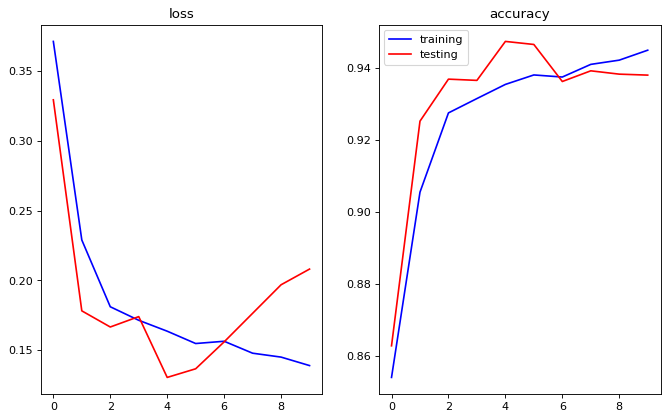

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


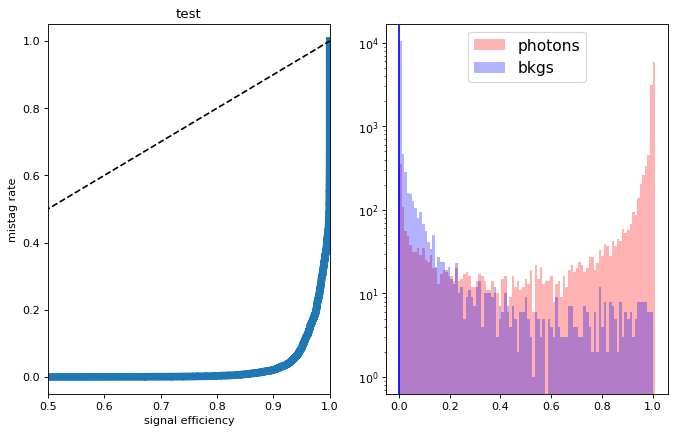

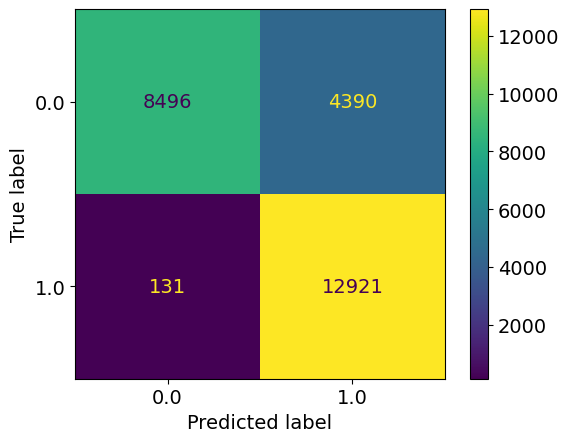

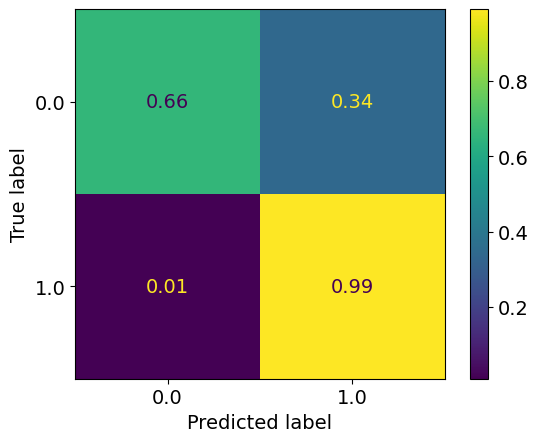

epoch: 10
Learning rate: 0.0009046152093405279


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.1397321965825351
train acc: 0.9438367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.87it/s]


test loss: 0.131498446688056
test acc: 0.95030457
new best acc: 0.95030457
epoch: 11
Learning rate: 0.000885372348954578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.16it/s]


train loss: 0.13857626480001933
train acc: 0.9444054


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.03it/s]


test loss: 0.12237769068980758
test acc: 0.9506515
new best acc: 0.9506515
epoch: 12
Learning rate: 0.0008646085999671836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.40it/s]


train loss: 0.13550317205617882
train acc: 0.9453981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.12572889758104627
test acc: 0.95207804
new best acc: 0.95207804
epoch: 13
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.13237188855519874
train acc: 0.9466704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.63it/s]


test loss: 0.13462507267567245
test acc: 0.9458324
epoch: 14
Learning rate: 0.0008188518951657368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1295682722433454
train acc: 0.94788486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.13919585790823807
test acc: 0.9478757
epoch: 15
Learning rate: 0.0007940395201612855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.12896797396888623
train acc: 0.9474897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.84it/s]


test loss: 0.17103783430700953
test acc: 0.9436734
epoch: 16
Learning rate: 0.0007680667055046367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.12729360985790375
train acc: 0.94756675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.43it/s]


test loss: 0.11010659045793793
test acc: 0.95354307
new best acc: 0.95354307
epoch: 17
Learning rate: 0.0007410359540293891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.1266617449807983
train acc: 0.9482704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.69it/s]


test loss: 0.13871179148554802
test acc: 0.9498805
epoch: 18
Learning rate: 0.0007130539437624405


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.12693646718139592
train acc: 0.9480583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.26it/s]


test loss: 0.12599002248184246
test acc: 0.95030457
epoch: 19
Learning rate: 0.0006842311069145497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.12379549947604968
train acc: 0.9490222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.13937925174832344
test acc: 0.945948


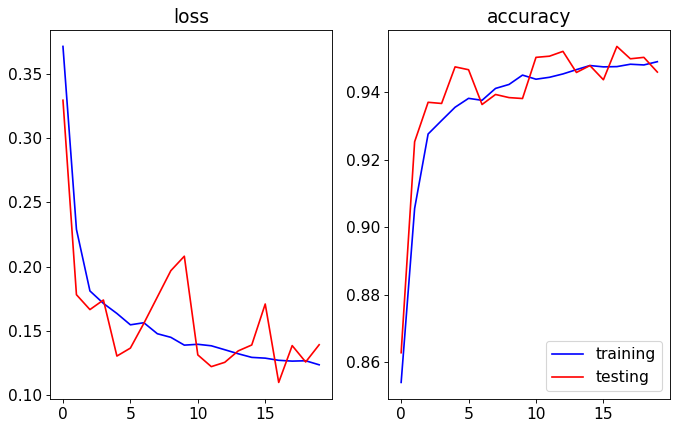

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.23it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


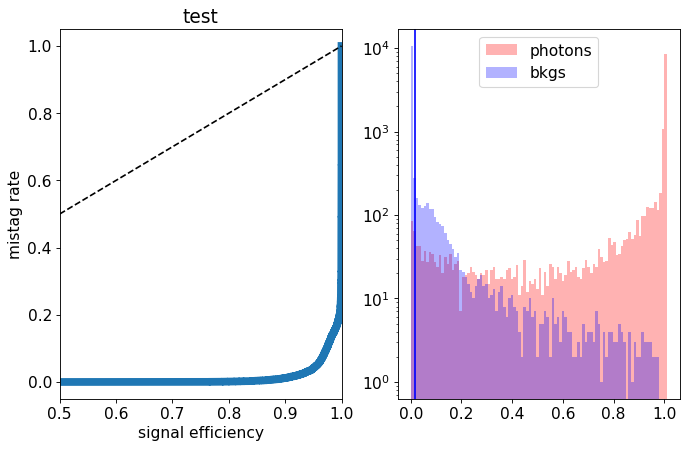

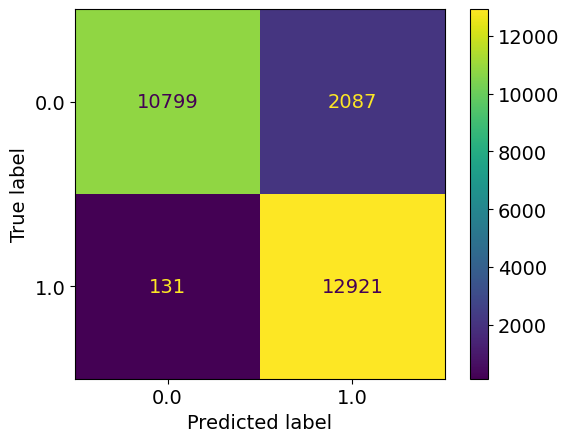

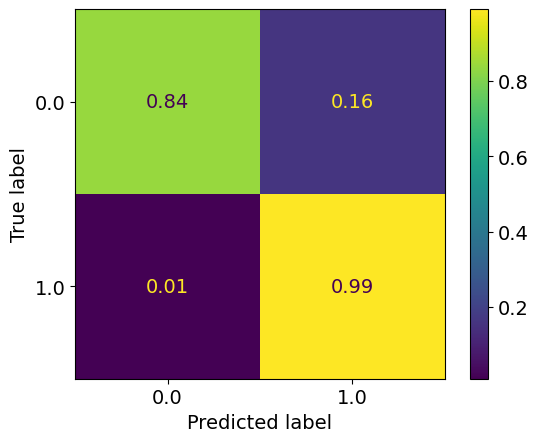

epoch: 20
Learning rate: 0.0006546811940548538


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.12268583558370612
train acc: 0.9488005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.11254381269893864
test acc: 0.95354307
epoch: 21
Learning rate: 0.0006245208251893391


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.12287656743230158
train acc: 0.9494077


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.11275618421760472
test acc: 0.95570207
new best acc: 0.95570207
epoch: 22
Learning rate: 0.0005938690295149558


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.12170262272991886
train acc: 0.9509306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.1107982224361463
test acc: 0.9555864
epoch: 23
Learning rate: 0.0005628467756657573


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1214661893644774
train acc: 0.9495523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.77it/s]


test loss: 0.13920432566241783
test acc: 0.95034313
epoch: 24
Learning rate: 0.0005315764943049666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.12085753855849966
train acc: 0.9499764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.11651012436910109
test acc: 0.954584
epoch: 25
Learning rate: 0.0005001815949470823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.12019928333731746
train acc: 0.95046794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.16it/s]


test loss: 0.1074439271945845
test acc: 0.9541985
epoch: 26
Learning rate: 0.0004687859789169048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.1186754684572275
train acc: 0.95099807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.12762641280212186
test acc: 0.9495335
epoch: 27
Learning rate: 0.0004375135503676123


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.11787488565624105
train acc: 0.95126796


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.24it/s]


test loss: 0.13498323190618644
test acc: 0.9503817
epoch: 28
Learning rate: 0.0004064877272876757


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.42it/s]


train loss: 0.11755729651864553
train acc: 0.9514704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.85it/s]


test loss: 0.11434318057515404
test acc: 0.9543141
epoch: 29
Learning rate: 0.00037583095442644083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11521248282552454
train acc: 0.9525113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.40it/s]


test loss: 0.11863771859895099
test acc: 0.9535045


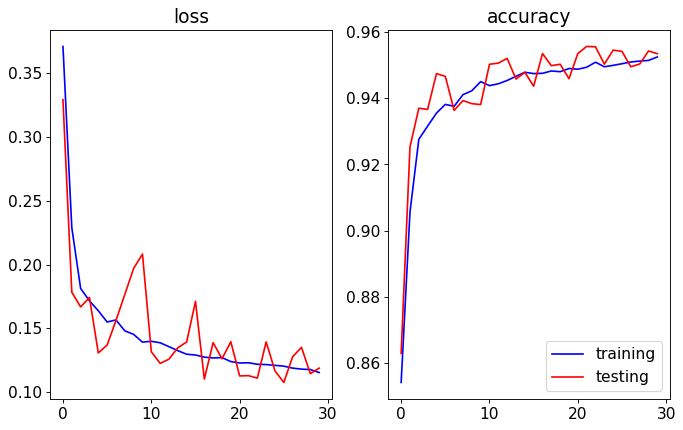

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


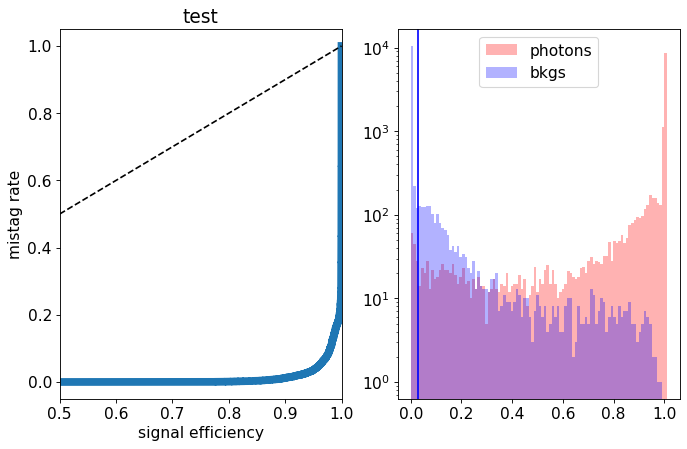

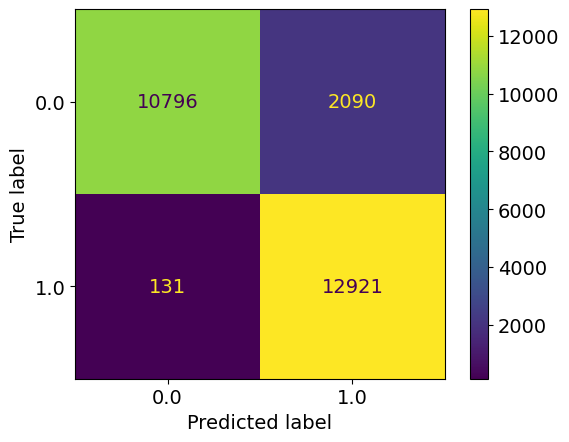

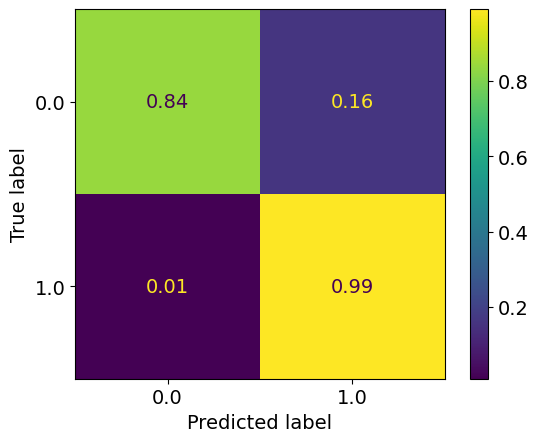

epoch: 30
Learning rate: 0.000345664220060644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11671170945456952
train acc: 0.951133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1019505804235285
test acc: 0.95770687
new best acc: 0.95770687
epoch: 31
Learning rate: 0.00031610657850895675


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.11570301613194404
train acc: 0.9524245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.51it/s]


test loss: 0.12711535648188807
test acc: 0.9521551
epoch: 32
Learning rate: 0.00028727468027898187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.11557290173334882
train acc: 0.9521258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.10383432544767857
test acc: 0.95693576
epoch: 33
Learning rate: 0.00025928231170099157


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11481956233178948
train acc: 0.95309925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.11461081660606644
test acc: 0.95439124
epoch: 34
Learning rate: 0.0002322399458652666


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.11420536583903208
train acc: 0.95324385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.55it/s]


test loss: 0.11321750875901092
test acc: 0.95477676
epoch: 35
Learning rate: 0.00020625430663527867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11495166586313633
train acc: 0.9527041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.11259723657911475
test acc: 0.9550081
epoch: 36
Learning rate: 0.0001814279474573593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11428402329800445
train acc: 0.952839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.12978606823493133
test acc: 0.95165396
epoch: 37
Learning rate: 0.00015785884662909916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11401867056857644
train acc: 0.95261735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.11438135303218257
test acc: 0.9552394
epoch: 38
Learning rate: 0.0001356400206237693


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.1137628358051267
train acc: 0.9526848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.31it/s]


test loss: 0.11539807356894016
test acc: 0.9540443
epoch: 39
Learning rate: 0.00011485915699679673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.11380312841579404
train acc: 0.9527523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.18it/s]


test loss: 0.11238941533321684
test acc: 0.955278


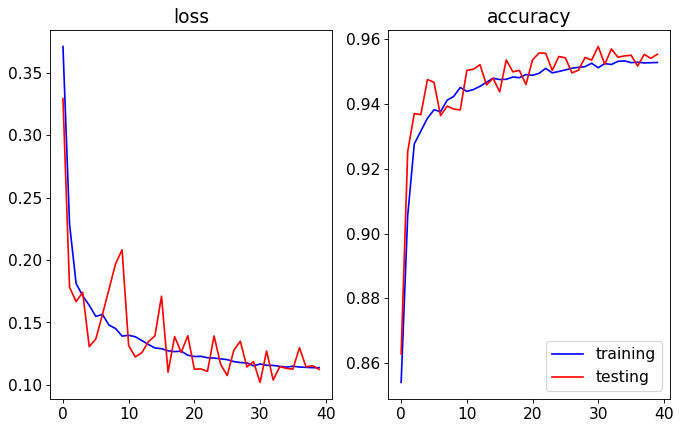

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


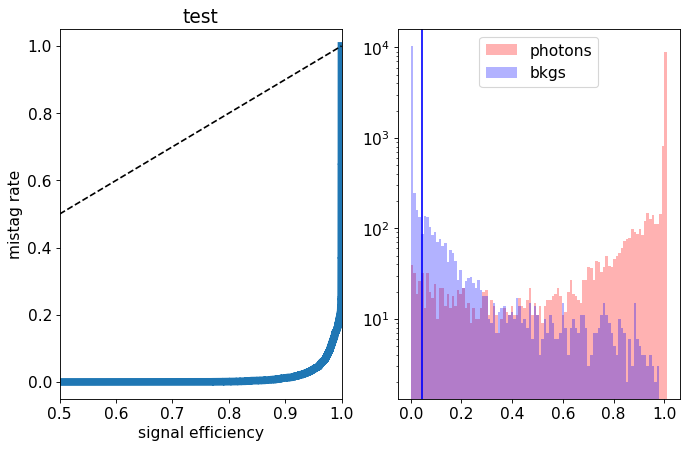

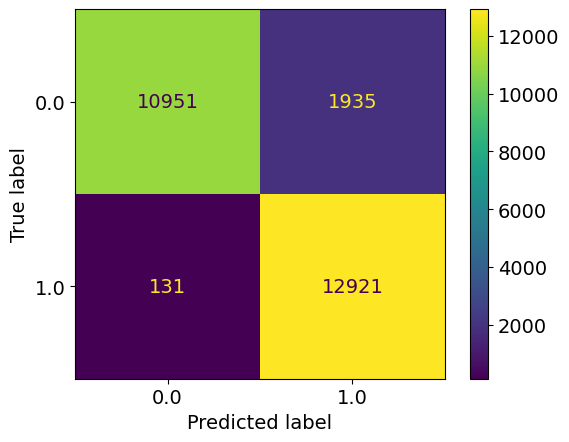

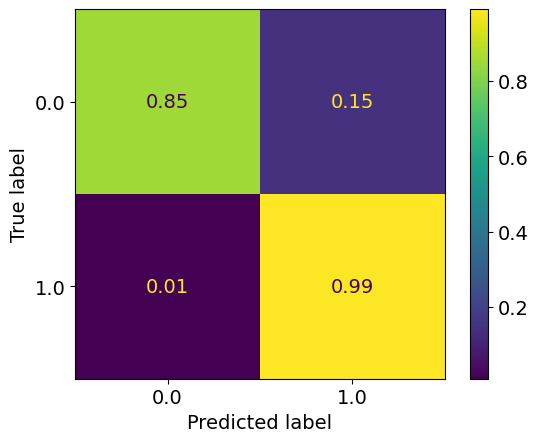

epoch: 40
Learning rate: 9.559826832304369e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.18it/s]


train loss: 0.1129139491674528
train acc: 0.9533884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.45it/s]


test loss: 0.11160249991173093
test acc: 0.955278
epoch: 41
Learning rate: 7.793336853064242e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.11254673937841647
train acc: 0.95358115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.13063584386625074
test acc: 0.95238644
epoch: 42
Learning rate: 6.193417290874859e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.11188611207325334
train acc: 0.9541306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.11818476105955514
test acc: 0.9525407
epoch: 43
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.11213919912287265
train acc: 0.95358115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.12235231054100124
test acc: 0.9525792
epoch: 44
Learning rate: 3.5178637275523064e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.1117090647448005
train acc: 0.95390886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.12500943582166324
test acc: 0.95234793
epoch: 45
Learning rate: 2.4527889139894345e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1108484895243121
train acc: 0.954439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.1147951443086971
test acc: 0.95304185
epoch: 46
Learning rate: 1.5753612203285418e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.19it/s]


train loss: 0.11165783532782098
train acc: 0.9541402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.26it/s]


test loss: 0.1167350292883136
test acc: 0.95331174
epoch: 47
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.11231855582984197
train acc: 0.9534173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.11it/s]


test loss: 0.1170415673404932
test acc: 0.9532732
epoch: 48
Learning rate: 3.965441941372383e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.19it/s]


train loss: 0.11104752386064198
train acc: 0.9536872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.07it/s]


test loss: 0.11907642876560037
test acc: 0.95331174
epoch: 49
Learning rate: 9.980711385892405e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.11106379399065337
train acc: 0.9540631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.11952675895934756
test acc: 0.9533503


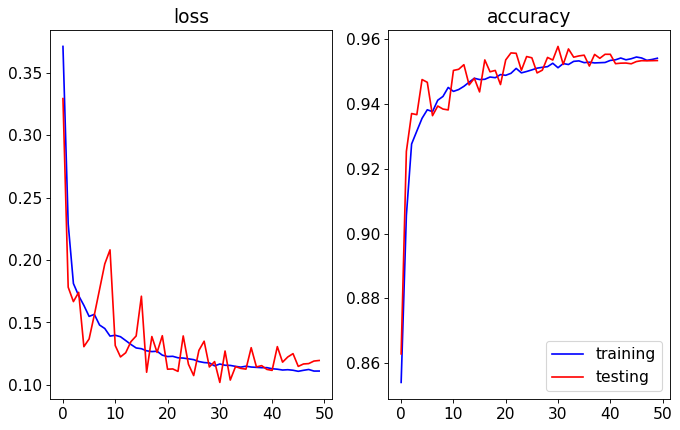

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.54it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


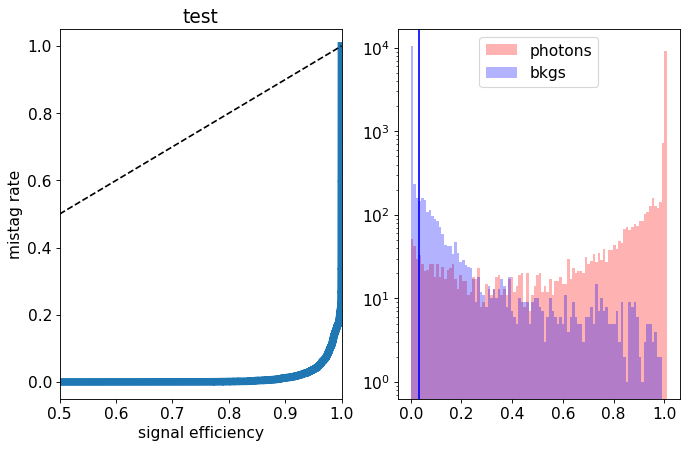

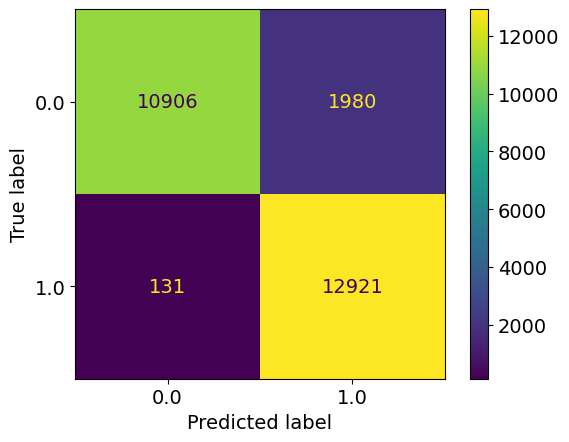

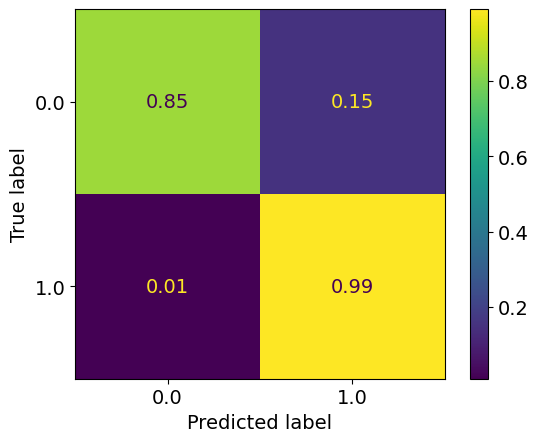

epoch: 50
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.12324707248824181
train acc: 0.94906074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.11125604215670716
test acc: 0.95338887
epoch: 51
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.12326352983024079
train acc: 0.9494656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.76it/s]


test loss: 0.10985512896017595
test acc: 0.9547382
epoch: 52
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.12088234477132731
train acc: 0.95032334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.1435701303522695
test acc: 0.946642
epoch: 53
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.12110764033704824
train acc: 0.94999564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.14it/s]


test loss: 0.10231843252073634
test acc: 0.95708996
epoch: 54
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11880737164117008
train acc: 0.9513161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.11289092170243914
test acc: 0.9526949
epoch: 55
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.11942789733754416
train acc: 0.95065105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.78it/s]


test loss: 0.1038523522967642
test acc: 0.95643455
epoch: 56
Learning rate: 0.0009649550618418059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11680702494748066
train acc: 0.95154744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.13027899187396874
test acc: 0.94949496
epoch: 57
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11609816314340327
train acc: 0.9520968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.81it/s]


test loss: 0.11809911731291901
test acc: 0.9529262
epoch: 58
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11676917474910703
train acc: 0.9520968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.10579144548286092
test acc: 0.95439124
epoch: 59
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11802880177435847
train acc: 0.9510559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.12567757882855154
test acc: 0.95096


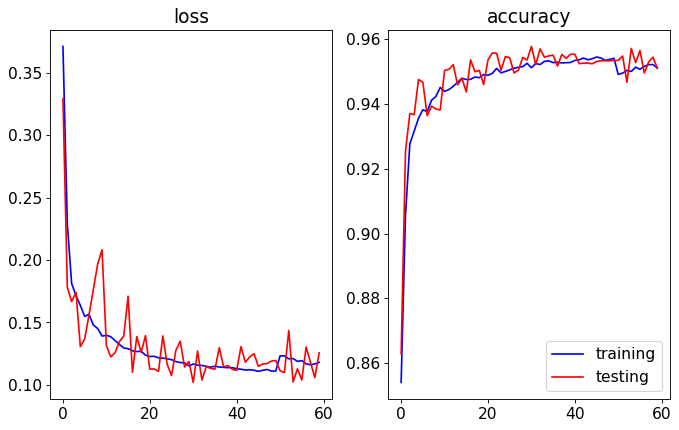

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


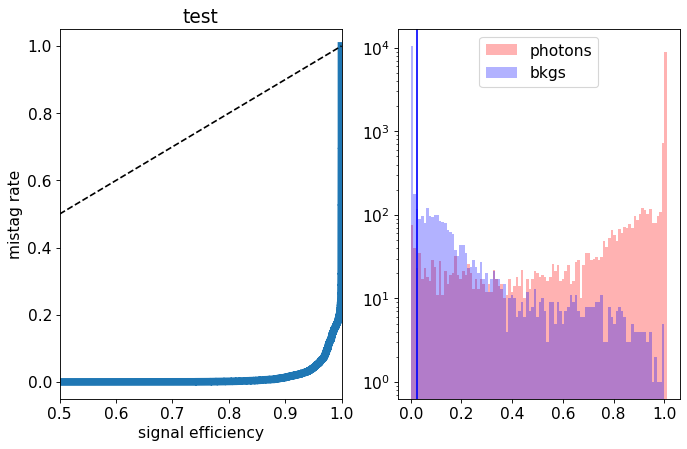

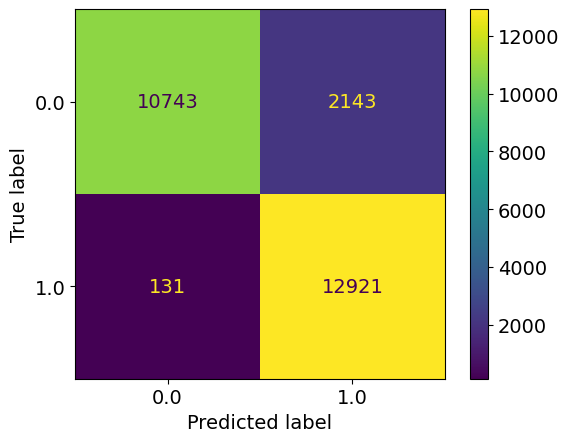

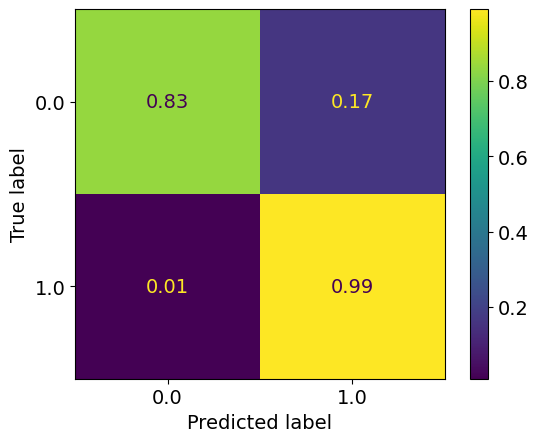

epoch: 60
Learning rate: 0.0009046152093405278


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.11797827426236489
train acc: 0.95166314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.39it/s]


test loss: 0.1273888579823754
test acc: 0.94725883
epoch: 61
Learning rate: 0.000885372348954578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.11463203255324006
train acc: 0.95274264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.53it/s]


test loss: 0.11254482072862712
test acc: 0.9531961
epoch: 62
Learning rate: 0.0008646085999671836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.18it/s]


train loss: 0.1166436320784464
train acc: 0.9516438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.17it/s]


test loss: 0.10923968983644788
test acc: 0.9565117
epoch: 63
Learning rate: 0.0008424059074095433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.116770188889407
train acc: 0.95196193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16939760812304236
test acc: 0.9452155
epoch: 64
Learning rate: 0.0008188518951657367


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11602869375764979
train acc: 0.95166314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.10321801663799719
test acc: 0.95678157
epoch: 65
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11451948391047516
train acc: 0.95234746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.83it/s]


test loss: 0.10888683922927488
test acc: 0.9546997
epoch: 66
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.1147146194828728
train acc: 0.9527523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.10502033900808204
test acc: 0.957437
epoch: 67
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.11368860071794146
train acc: 0.95322454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.59it/s]


test loss: 0.11576492068442432
test acc: 0.9558948
epoch: 68
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.11438183417554536
train acc: 0.95232815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.13083279877901077
test acc: 0.95304185
epoch: 69
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11390888690948486
train acc: 0.95396674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.11601313796233047
test acc: 0.9541599


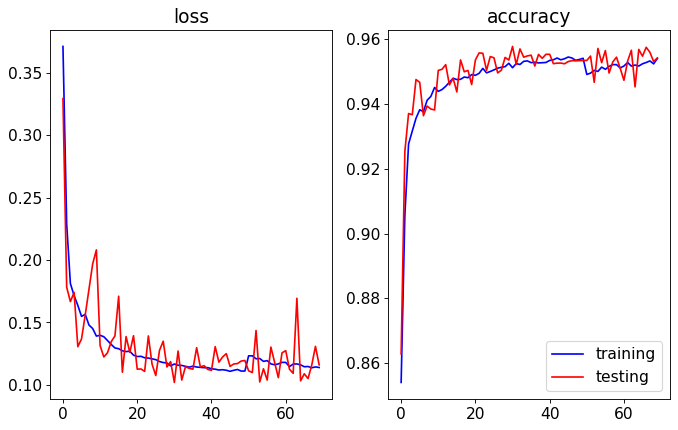

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


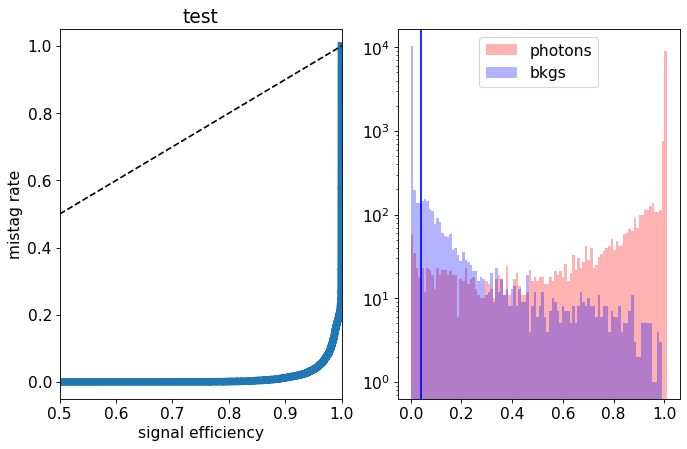

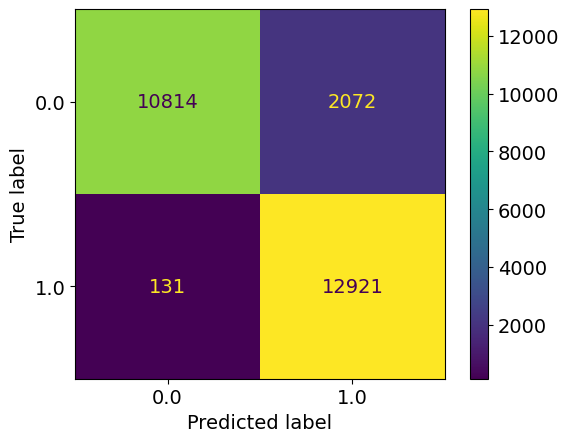

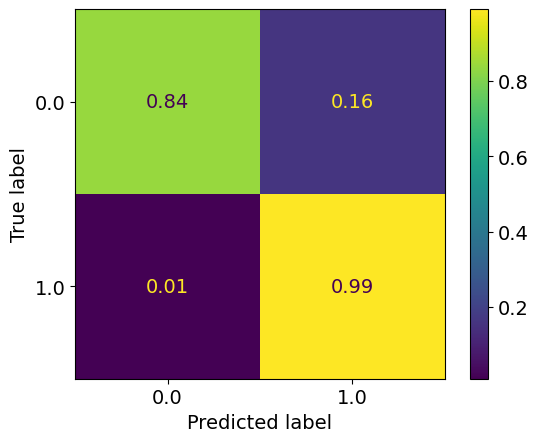

epoch: 70
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11289332285954085
train acc: 0.9532149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.12737085788764738
test acc: 0.951731
epoch: 71
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11228217335277899
train acc: 0.9534462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.37it/s]


test loss: 0.11885163763707335
test acc: 0.95288765
epoch: 72
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.11295270812132455
train acc: 0.95360047


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.13586518134583125
test acc: 0.9513455
epoch: 73
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11137144896336373
train acc: 0.9535619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.11058336809616197
test acc: 0.95439124
epoch: 74
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.11202469291542307
train acc: 0.9536197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.14644124020229687
test acc: 0.94802994
epoch: 75
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10986291660222015
train acc: 0.95466065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.14373413304036314
test acc: 0.9525792
epoch: 76
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11013678655114477
train acc: 0.9547378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.10264295542782004
test acc: 0.9569743
epoch: 77
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11023337592107023
train acc: 0.9542462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.14551804587244987
test acc: 0.9514997
epoch: 78
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10998675532940495
train acc: 0.9548727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.11060720428147099
test acc: 0.9550081
epoch: 79
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.11061391044903353
train acc: 0.9544101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.30it/s]


test loss: 0.12993328205563806
test acc: 0.9514997


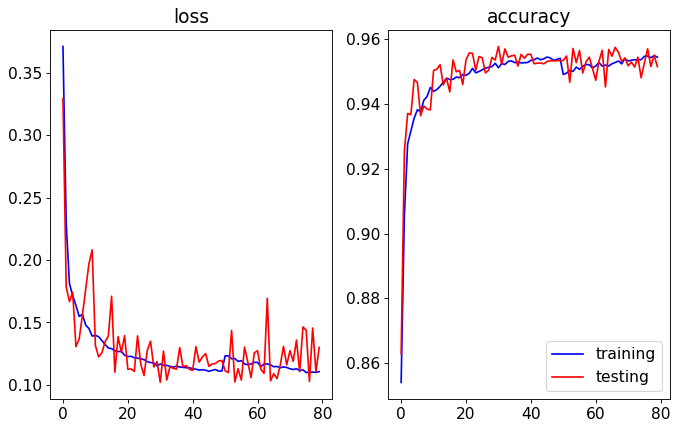

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


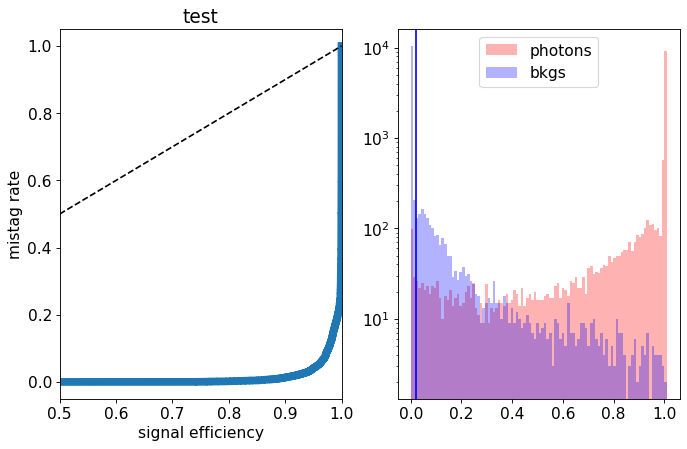

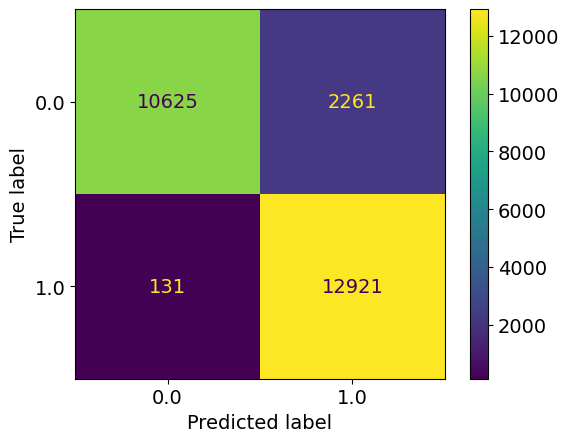

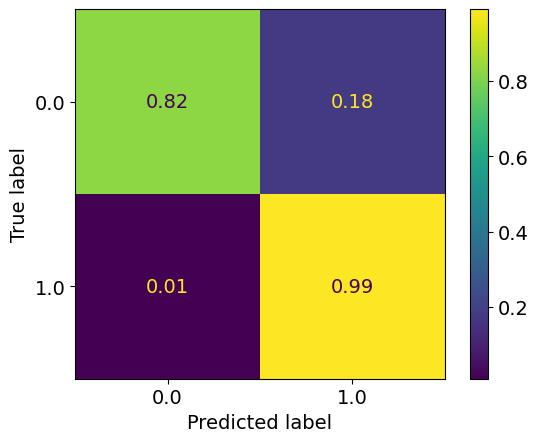

epoch: 80
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10944732713561527
train acc: 0.9545547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.15it/s]


test loss: 0.1294863804836165
test acc: 0.953119
epoch: 81
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10931630484286071
train acc: 0.9548727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.11731654659590939
test acc: 0.956049
epoch: 82
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.10847754978892431
train acc: 0.95558596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.21it/s]


test loss: 0.15143427947028118
test acc: 0.9477986
epoch: 83
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10851951326765766
train acc: 0.95522934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.13199330866336823
test acc: 0.95381296
epoch: 84
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10873550030192888
train acc: 0.9553354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.14288016239350493
test acc: 0.95207804
epoch: 85
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.108467918686095
train acc: 0.9550269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.12893360768529502
test acc: 0.95369726
epoch: 86
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10781530118574296
train acc: 0.9554896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.12623852931640364
test acc: 0.95396715
epoch: 87
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10743621883192503
train acc: 0.95575947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.156176184727387
test acc: 0.9499576
epoch: 88
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10745203443345307
train acc: 0.95579803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.20it/s]


test loss: 0.13514084673740648
test acc: 0.9521551
epoch: 89
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.43it/s]


train loss: 0.10747543194821116
train acc: 0.95568234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.23it/s]


test loss: 0.12912847050888973
test acc: 0.9529262


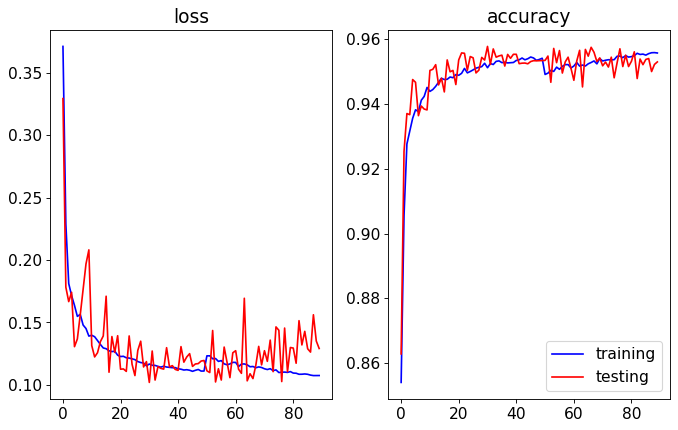

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.70it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


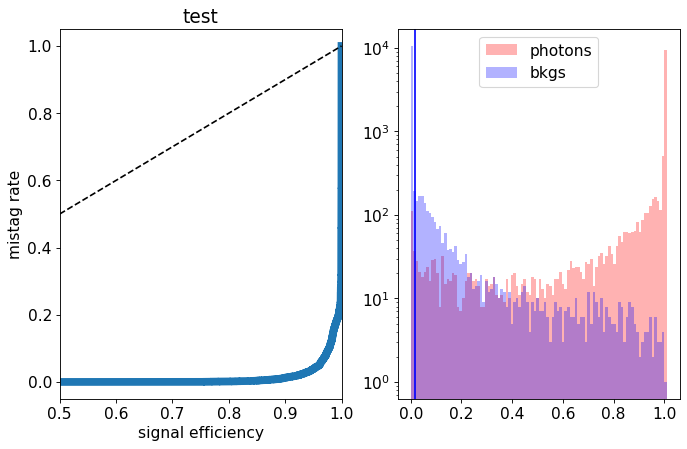

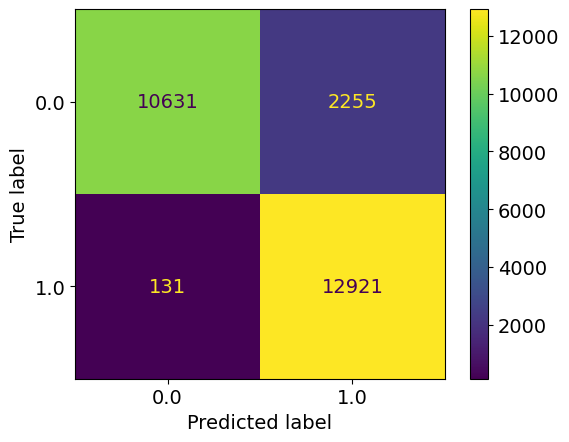

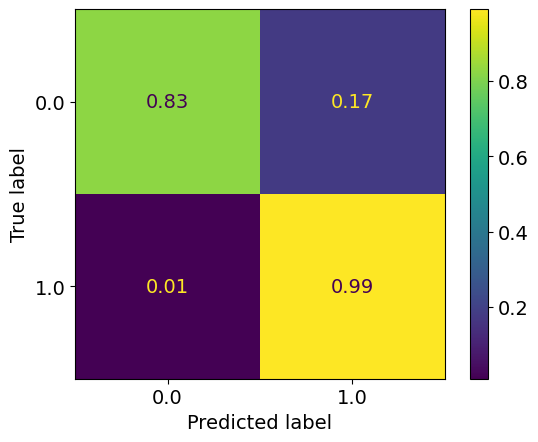

epoch: 90
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10682029165112214
train acc: 0.95558596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1420954049310901
test acc: 0.950266
epoch: 91
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10696491586162865
train acc: 0.95571125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.12339643101123246
test acc: 0.9536202
epoch: 92
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10715417495008149
train acc: 0.95598114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.13377270576628772
test acc: 0.95192385
epoch: 93
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1066445705690825
train acc: 0.9559522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.08it/s]


test loss: 0.1342655127360062
test acc: 0.9528491
epoch: 94
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1064786824446193
train acc: 0.9560872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.12875485928221184
test acc: 0.9522708
epoch: 95
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.10657965008578549
train acc: 0.9560486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.10it/s]


test loss: 0.1371001870456067
test acc: 0.95130694
epoch: 96
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10591296184097411
train acc: 0.9562318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.1278466357087547
test acc: 0.95358163
epoch: 97
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.1057045015296495
train acc: 0.95618355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.93it/s]


test loss: 0.13321571560068565
test acc: 0.95246357
epoch: 98
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10653500857553042
train acc: 0.9559426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.13361429135230454
test acc: 0.95234793
epoch: 99
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10682630448499857
train acc: 0.9554896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.13361077146096664
test acc: 0.95234793


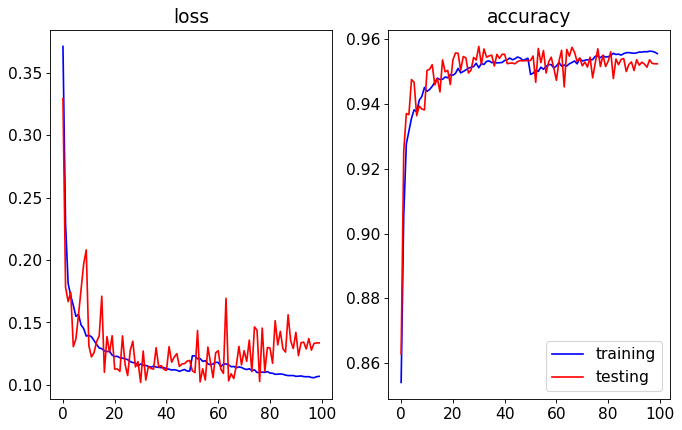

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


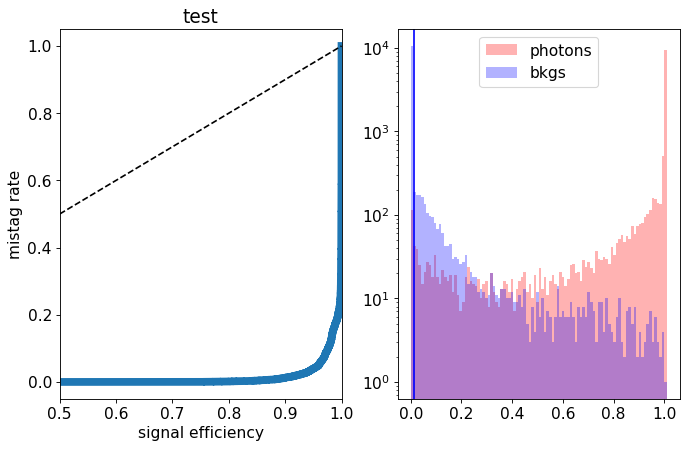

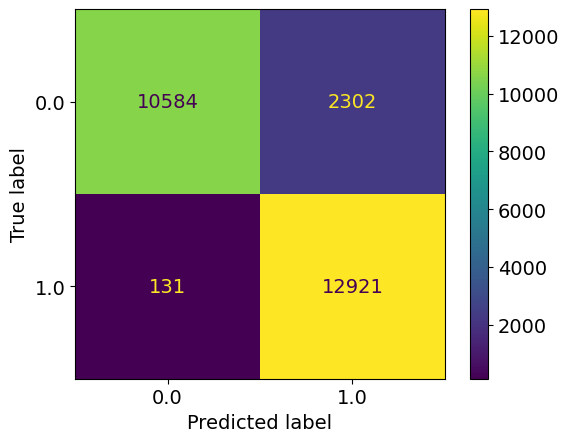

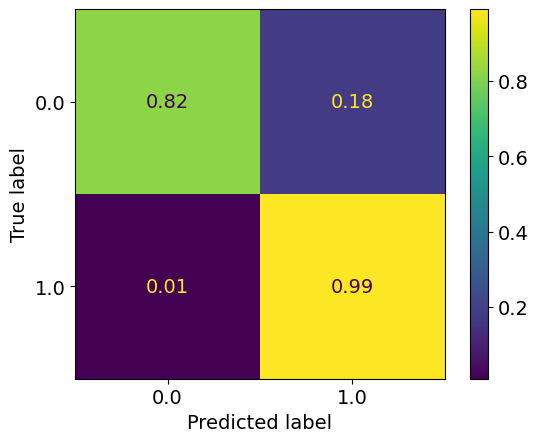

epoch: 100
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11500578632072217
train acc: 0.9524824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.16693203439089385
test acc: 0.94818413
epoch: 101
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.11471627062628034
train acc: 0.9529643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.1397911481220614
test acc: 0.95230937
epoch: 102
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.11321348421318683
train acc: 0.9530318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.56it/s]


test loss: 0.13172801059078088
test acc: 0.95180815
epoch: 103
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.21it/s]


train loss: 0.11283845131452373
train acc: 0.95328236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.27it/s]


test loss: 0.13814601877873595
test acc: 0.9482227
epoch: 104
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.11376824182582039
train acc: 0.95328236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.38it/s]


test loss: 0.1155142467468977
test acc: 0.9530804
epoch: 105
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11380643173621569
train acc: 0.952733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.12845952487127346
test acc: 0.95072865
epoch: 106
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11187206759962733
train acc: 0.9538125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.42it/s]


test loss: 0.16625253822315822
test acc: 0.9457938
epoch: 107
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11222243102299685
train acc: 0.9534173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.12265966392376206
test acc: 0.95520085
epoch: 108
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11233860607436627
train acc: 0.95396674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.12032420950179751
test acc: 0.9485311
epoch: 109
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.62it/s]


train loss: 0.11450120612892802
train acc: 0.95327276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.78it/s]


test loss: 0.14651678045364944
test acc: 0.94991904


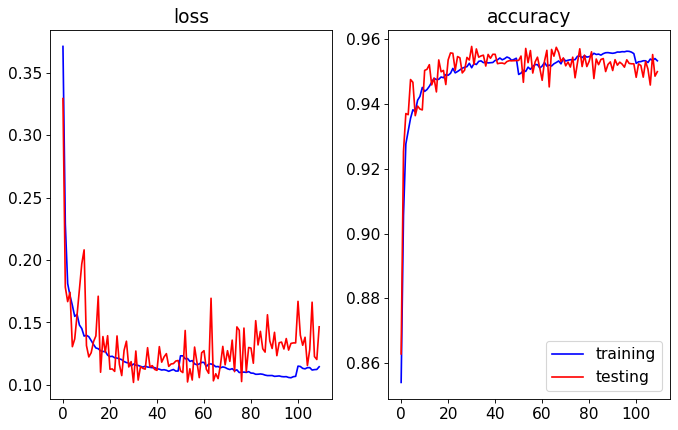

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


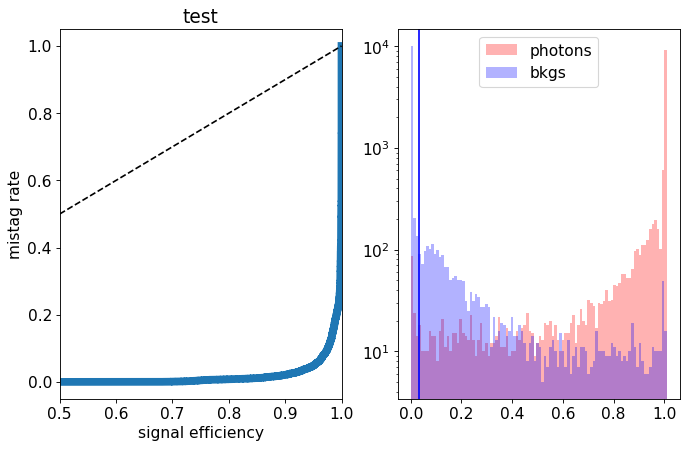

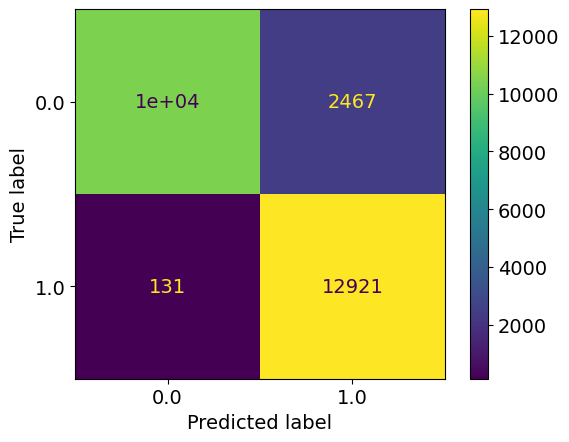

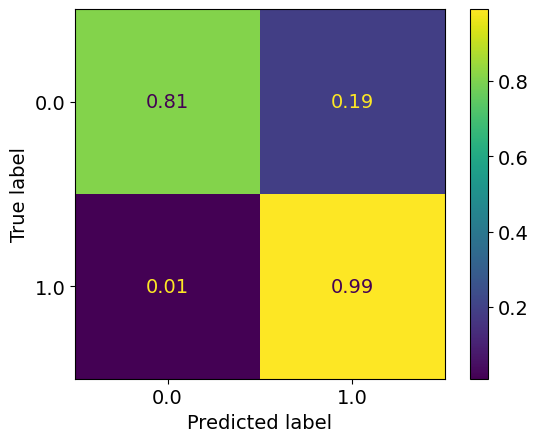

epoch: 110
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.21it/s]


train loss: 0.11274321316983658
train acc: 0.95304143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.12394247068600221
test acc: 0.95354307
epoch: 111
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1106588975284141
train acc: 0.95438117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.15865422074090352
test acc: 0.9461408
epoch: 112
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.19it/s]


train loss: 0.1113963462627692
train acc: 0.95385104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.35it/s]


test loss: 0.1073203193531795
test acc: 0.95466113
epoch: 113
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.11099870645069662
train acc: 0.95352334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.53it/s]


test loss: 0.11401051384481517
test acc: 0.95439124
epoch: 114
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11046733892377401
train acc: 0.9541113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.12665569003332744
test acc: 0.95250213
epoch: 115
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10998907663746377
train acc: 0.9546896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.04it/s]


test loss: 0.12562071413479067
test acc: 0.95273346
epoch: 116
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.11091249703155087
train acc: 0.9543908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.67it/s]


test loss: 0.15471623939546672
test acc: 0.9445987
epoch: 117
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.10896567948636292
train acc: 0.95447755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.94it/s]


test loss: 0.10948760248720646
test acc: 0.95535505
epoch: 118
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10948786983600242
train acc: 0.954998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.93it/s]


test loss: 0.13648738627406684
test acc: 0.9517696
epoch: 119
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10903734851607008
train acc: 0.9547378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.33it/s]


test loss: 0.11979657784104347
test acc: 0.9541599


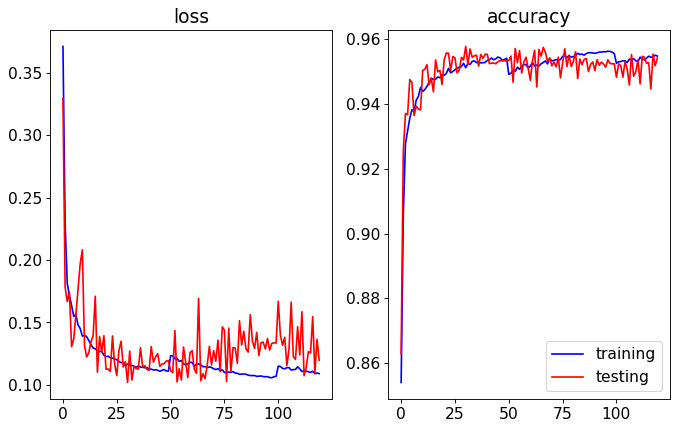

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.38it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


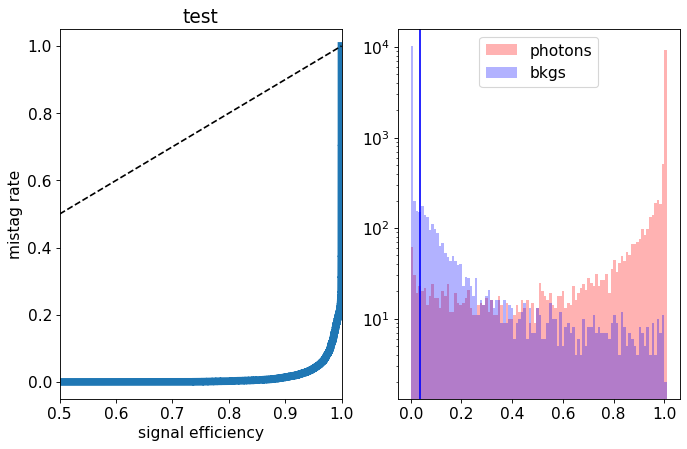

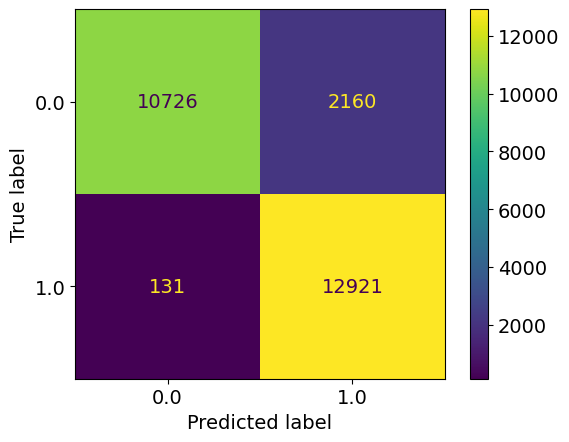

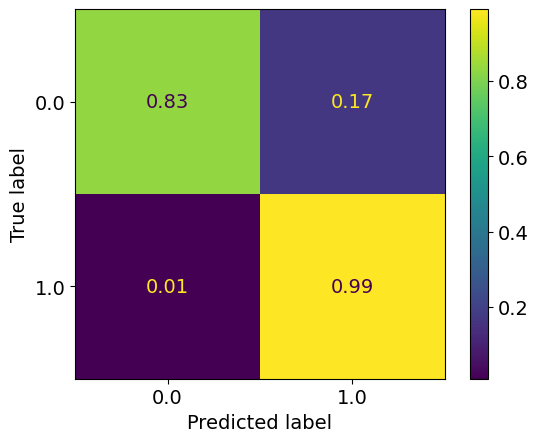

epoch: 120
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.10887499394788908
train acc: 0.9545161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.35it/s]


test loss: 0.18250583417036317
test acc: 0.9454854
epoch: 121
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.24it/s]


train loss: 0.10906439537257817
train acc: 0.9551233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.35it/s]


test loss: 0.14412491988729348
test acc: 0.9497263
epoch: 122
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.10838132902893717
train acc: 0.95535463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.31it/s]


test loss: 0.13717994280159473
test acc: 0.9521166
epoch: 123
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10817828520357264
train acc: 0.9549209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.60it/s]


test loss: 0.1165984311903065
test acc: 0.95396715
epoch: 124
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10690225126770879
train acc: 0.9549113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.12556413865902208
test acc: 0.9536587
epoch: 125
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10680354769863834
train acc: 0.95560527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.1130451915616339
test acc: 0.95423704
epoch: 126
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10772201660051511
train acc: 0.9553643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.69it/s]


test loss: 0.12014212797988545
test acc: 0.95493096
epoch: 127
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.1062980135310592
train acc: 0.9564438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.1228185969997536
test acc: 0.9548539
epoch: 128
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.10766630860939191
train acc: 0.9554896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.70it/s]


test loss: 0.13261033882471648
test acc: 0.9514612
epoch: 129
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10614900476153875
train acc: 0.9558366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.12783250957727432
test acc: 0.95462257


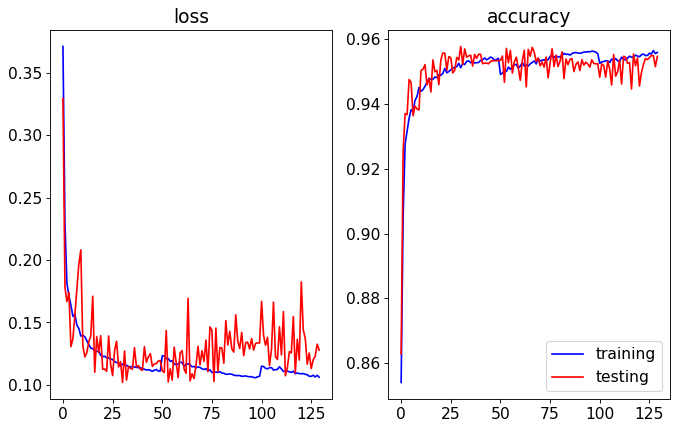

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


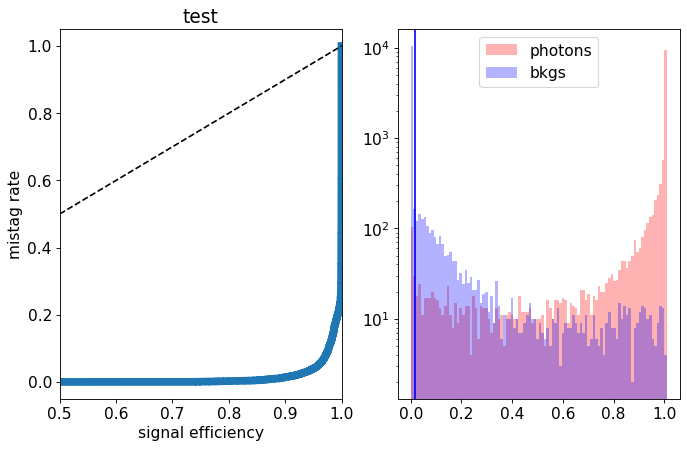

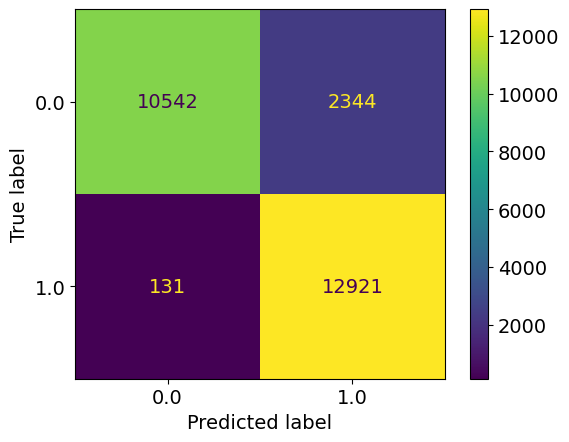

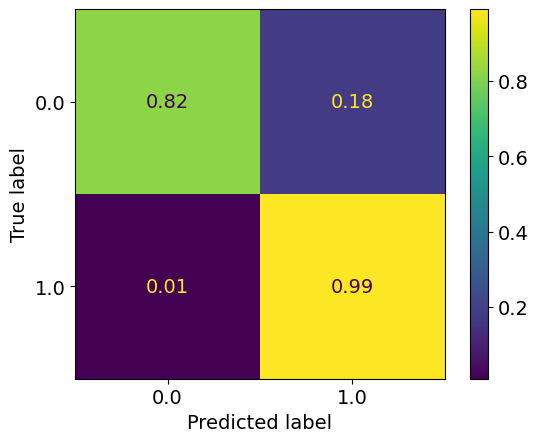

epoch: 130
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10655267932856013
train acc: 0.95588475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.1177499472078952
test acc: 0.9546997
epoch: 131
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10697657658013306
train acc: 0.9556631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.62it/s]


test loss: 0.13073907944966445
test acc: 0.95130694
epoch: 132
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10695829276921433
train acc: 0.9556534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.12158563631502065
test acc: 0.9546997
epoch: 133
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10625946444238542
train acc: 0.9564052


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.14174009520899167
test acc: 0.9526949
epoch: 134
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.1062223543493734
train acc: 0.9562221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.12742888216267934
test acc: 0.9515768
epoch: 135
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10621873870750383
train acc: 0.9563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.13406346585940232
test acc: 0.95192385
epoch: 136
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10506704359213052
train acc: 0.9567715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.13089796816083518
test acc: 0.95396715
epoch: 137
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10524468817290543
train acc: 0.956251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.14546782184730878
test acc: 0.95042026
epoch: 138
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10534013988654738
train acc: 0.956492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.64it/s]


test loss: 0.14352655952627008
test acc: 0.9511142
epoch: 139
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10545652196069673
train acc: 0.9560197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.82it/s]


test loss: 0.1343782716854052
test acc: 0.9528491


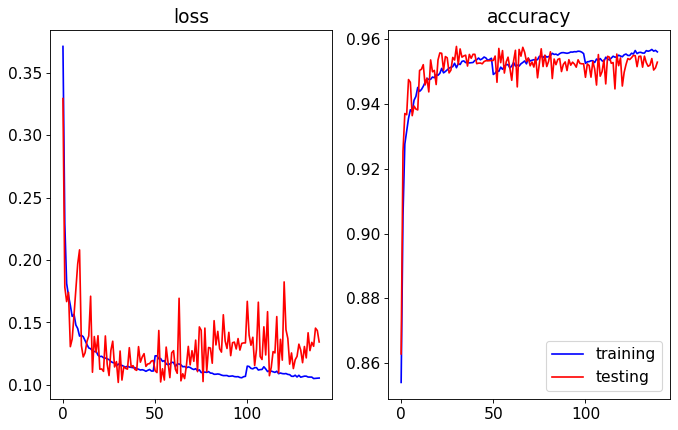

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.26it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


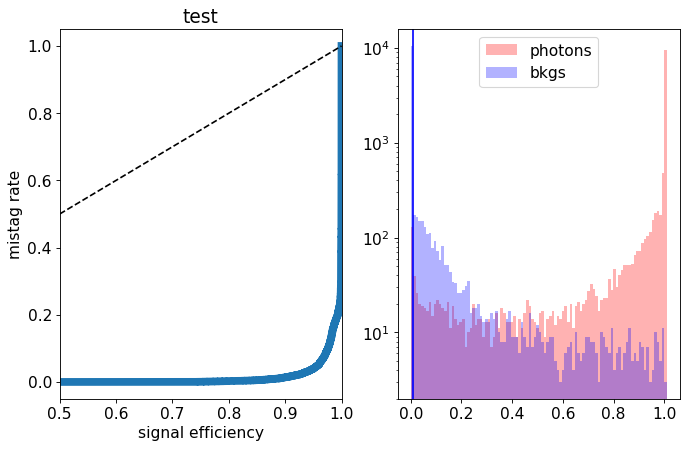

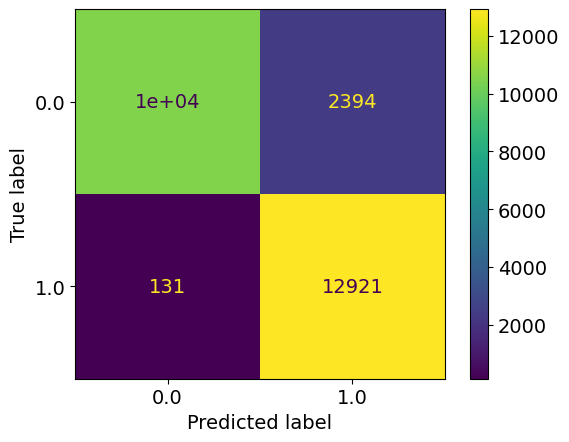

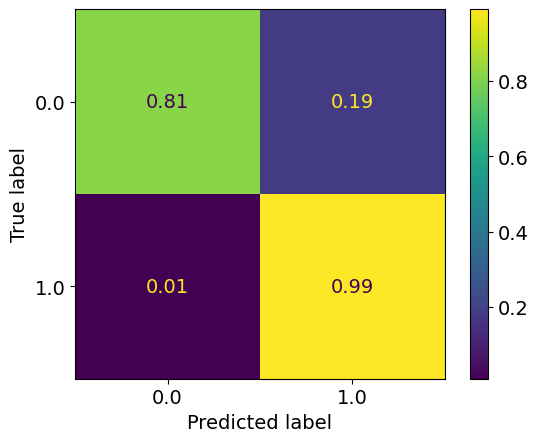

epoch: 140
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10450407294179663
train acc: 0.9572245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.13724271529777485
test acc: 0.9525407
epoch: 141
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.1054469482445648
train acc: 0.9562607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.14312341352078048
test acc: 0.951731
epoch: 142
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10443964040692831
train acc: 0.95638597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.14184830405495383
test acc: 0.95196235
epoch: 143
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10466258064170793
train acc: 0.9568968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.13865386779335412
test acc: 0.95130694
epoch: 144
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10483269156575892
train acc: 0.9565595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.133257513188503
test acc: 0.9529262
epoch: 145
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.10509392920601575
train acc: 0.9567908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.13751910762353378
test acc: 0.95250213
epoch: 146
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1042209872706777
train acc: 0.9564631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.14163647981529887
test acc: 0.9520009
epoch: 147
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10409287483878218
train acc: 0.95756185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.13958669030530887
test acc: 0.95165396
epoch: 148
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10391308571820314
train acc: 0.9568582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.13880307938564906
test acc: 0.95180815
epoch: 149
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10408505444237262
train acc: 0.9574847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.77it/s]


test loss: 0.13731343409215863
test acc: 0.9518853


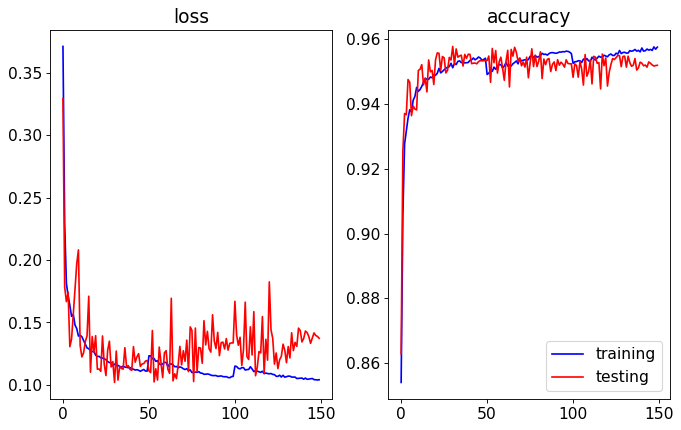

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.80it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


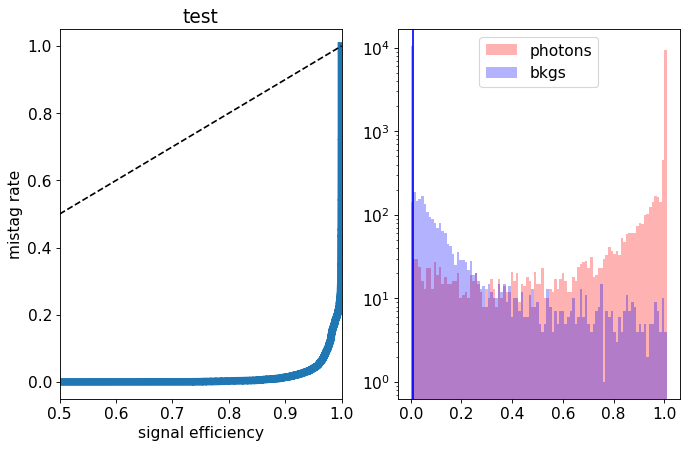

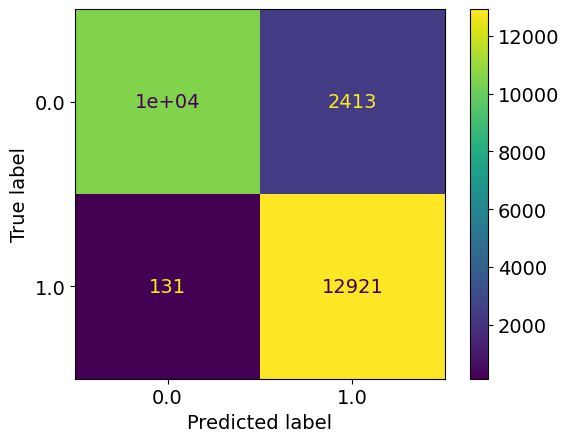

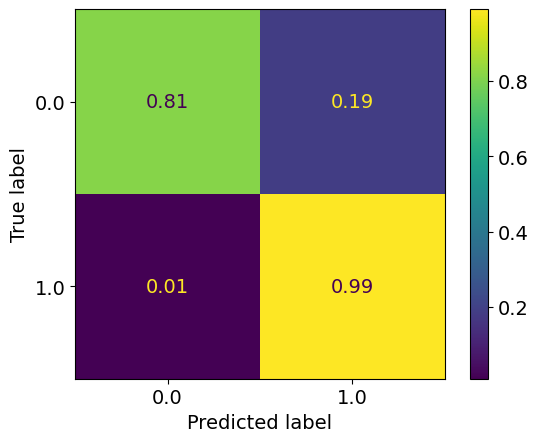

epoch: 150
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.11308580202002057
train acc: 0.95297396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.1571663689206947
test acc: 0.94976485
epoch: 151
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.11078729958548023
train acc: 0.9541884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1308957294306972
test acc: 0.9532732
epoch: 152
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.11065249722127969
train acc: 0.9540149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.16736660508269613
test acc: 0.94856966
epoch: 153
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.11012275387786027
train acc: 0.9544101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.14971900612793185
test acc: 0.94668055
epoch: 154
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.11042137491392952
train acc: 0.954092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.12345533462410624
test acc: 0.951731
epoch: 155
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11071095637158851
train acc: 0.9536486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.13951336575502699
test acc: 0.95138407
epoch: 156
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.11092493648646194
train acc: 0.954198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.11351586048575965
test acc: 0.9544298
epoch: 157
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.49it/s]


train loss: 0.11006775907526127
train acc: 0.95475703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.05it/s]


test loss: 0.13721816089342942
test acc: 0.9486468
epoch: 158
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.21it/s]


train loss: 0.10942294595041716
train acc: 0.9549402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.45it/s]


test loss: 0.11106781830841844
test acc: 0.9562418
epoch: 159
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10863686598449773
train acc: 0.95505583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.14669234254820782
test acc: 0.9468733


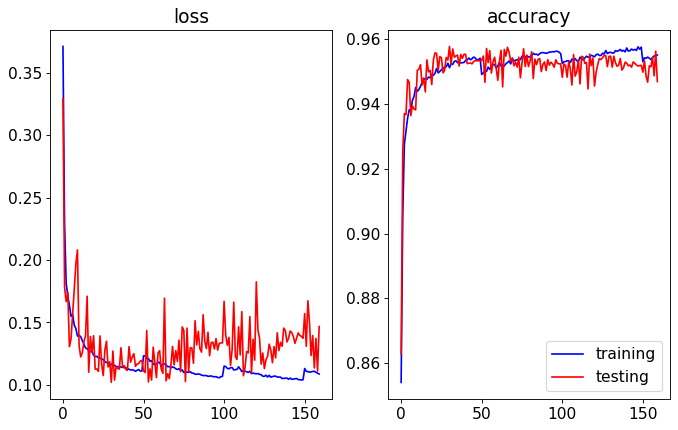

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


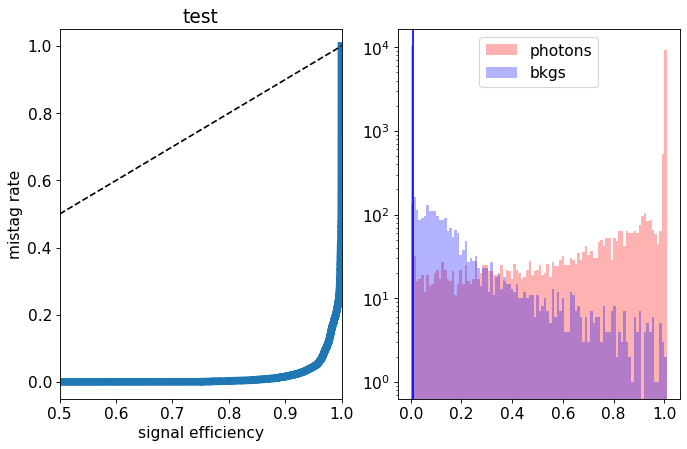

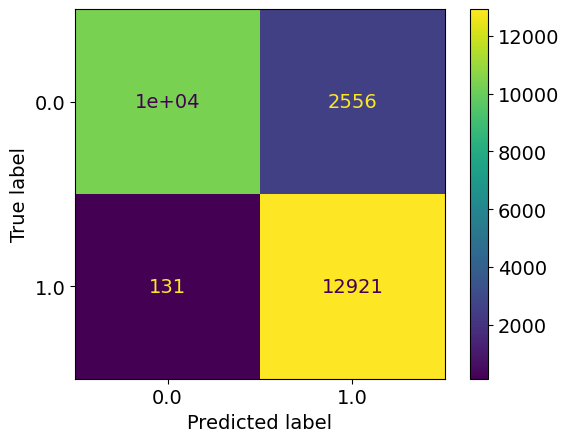

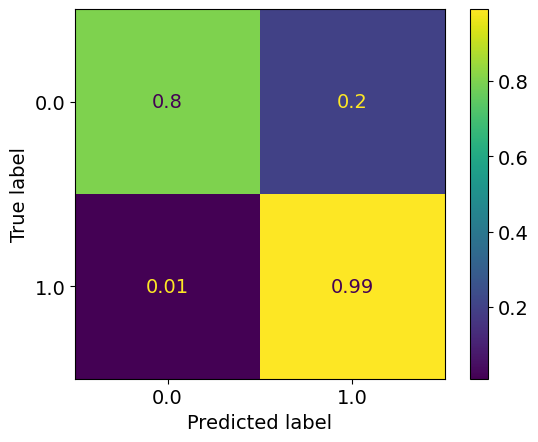

epoch: 160
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.11014929521462821
train acc: 0.9545547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.14426829242570835
test acc: 0.9510756
epoch: 161
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10906093571916481
train acc: 0.9545739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.1324765666980635
test acc: 0.952425
epoch: 162
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10860800131552481
train acc: 0.95527756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.84it/s]


test loss: 0.12092134966091676
test acc: 0.9491865
epoch: 163
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10982469990418825
train acc: 0.9541016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.69it/s]


test loss: 0.1474320399151607
test acc: 0.95138407
epoch: 164
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.10881984285536529
train acc: 0.9548438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.1482062627646056
test acc: 0.951731
epoch: 165
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10921214391730424
train acc: 0.9546125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.17410029809583316
test acc: 0.9476444
epoch: 166
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.10856667238508345
train acc: 0.9552197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.12134032764218071
test acc: 0.954584
epoch: 167
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.1078582375466479
train acc: 0.9551233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.1304912365634333
test acc: 0.9528491
epoch: 168
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10789905824413189
train acc: 0.9552679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.1414893538775769
test acc: 0.95180815
epoch: 169
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10770400488652246
train acc: 0.95579803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.11792342466386882
test acc: 0.9542756


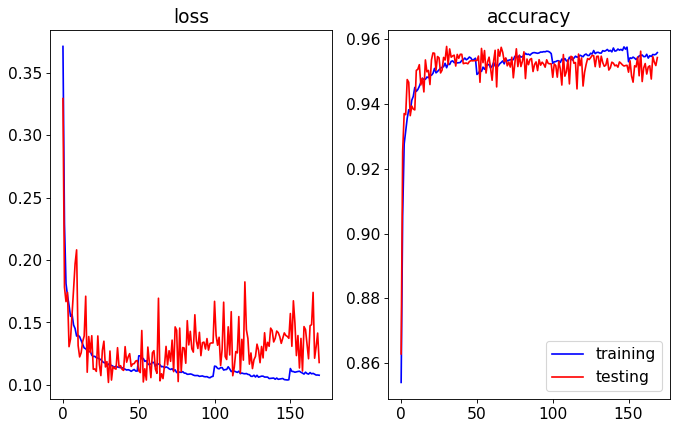

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


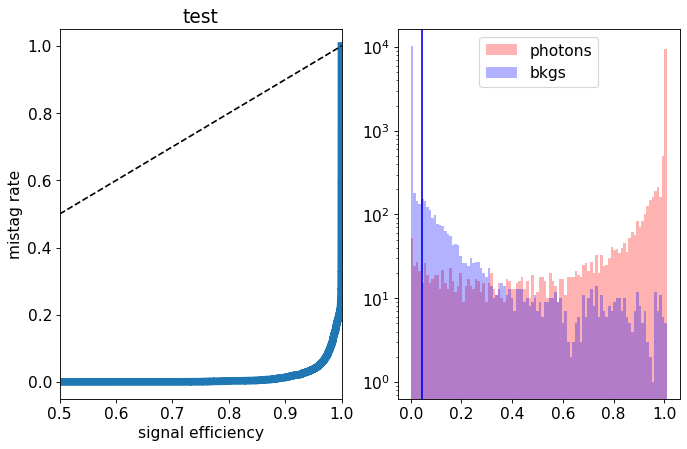

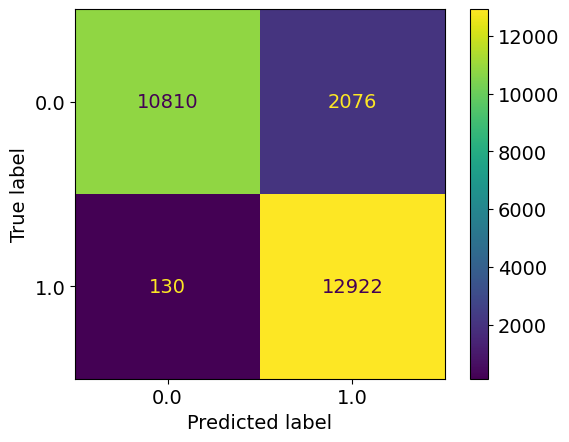

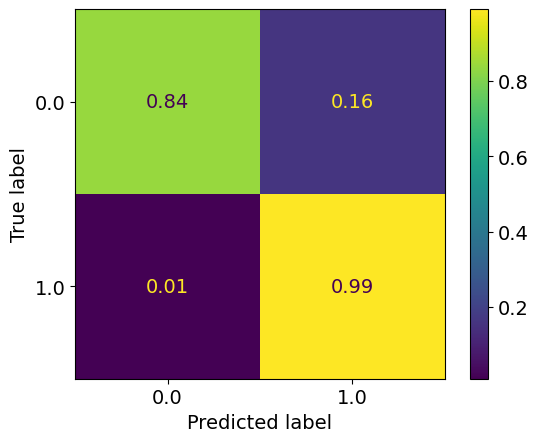

epoch: 170
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10695643232047902
train acc: 0.95546067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.17it/s]


test loss: 0.13465295867486435
test acc: 0.95142263
epoch: 171
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10737477294626953
train acc: 0.95575947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.15665588646449827
test acc: 0.94934076
epoch: 172
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.10672152718539872
train acc: 0.9559233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.88it/s]


test loss: 0.10655360101637515
test acc: 0.956743
epoch: 173
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.10608899675180457
train acc: 0.9556438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.28it/s]


test loss: 0.1297516091303392
test acc: 0.95412135
epoch: 174
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.1066792830824852
train acc: 0.9557402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.1362948678433895
test acc: 0.95165396
epoch: 175
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.10663180359009373
train acc: 0.9557691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.13482612845572559
test acc: 0.95196235
epoch: 176
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10591995039944015
train acc: 0.9564727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.14815294945781882
test acc: 0.95088285
epoch: 177
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10538333146213796
train acc: 0.9560679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.13724240457469766
test acc: 0.9520009
epoch: 178
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10517790517366002
train acc: 0.95621246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.12847800214182248
test acc: 0.953119
epoch: 179
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10561249039076656
train acc: 0.9562028


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.18586318702860313
test acc: 0.94425166


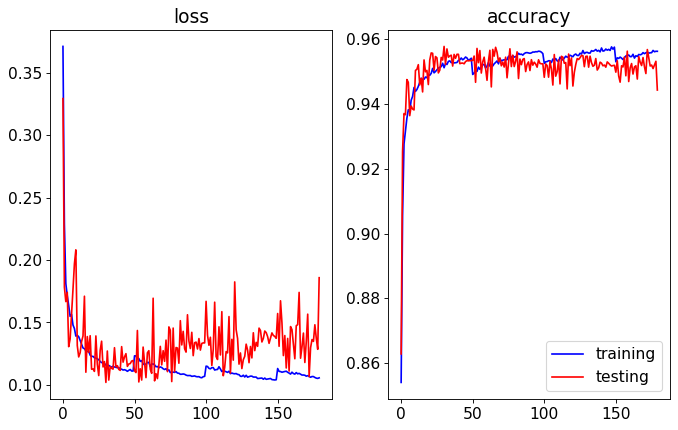

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


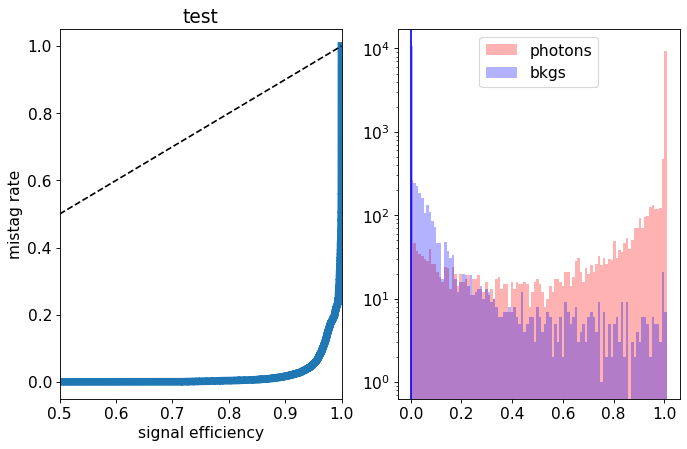

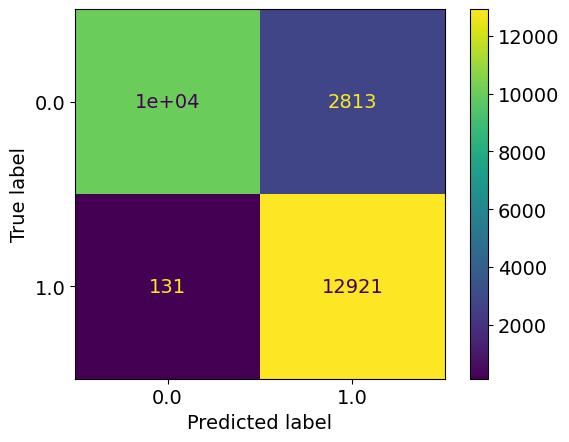

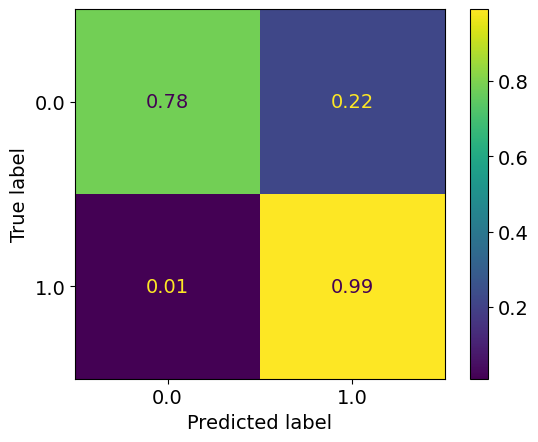

epoch: 180
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10644405546215917
train acc: 0.9563474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.15435432541099461
test acc: 0.94872385
epoch: 181
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.10568923890762935
train acc: 0.9561161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.44it/s]


test loss: 0.1237983422523195
test acc: 0.9529648
epoch: 182
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10600853048135779
train acc: 0.95615464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.13003381494094024
test acc: 0.9520395
epoch: 183
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10468792674169375
train acc: 0.9565884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.39it/s]


test loss: 0.13256447863849727
test acc: 0.95180815
epoch: 184
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10444188647704318
train acc: 0.9564631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.15328315730122002
test acc: 0.9499576
epoch: 185
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10430465242421696
train acc: 0.95675224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.14084791273555972
test acc: 0.95084435
epoch: 186
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1037782548652219
train acc: 0.9570992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.1390324504199353
test acc: 0.95153826
epoch: 187
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10370116917728689
train acc: 0.95746547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.15378442508253184
test acc: 0.9497263
epoch: 188
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10333917406253043
train acc: 0.9574462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.14880018241026186
test acc: 0.9501118
epoch: 189
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.10339124100228955
train acc: 0.956945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.1480781717056578
test acc: 0.9506901


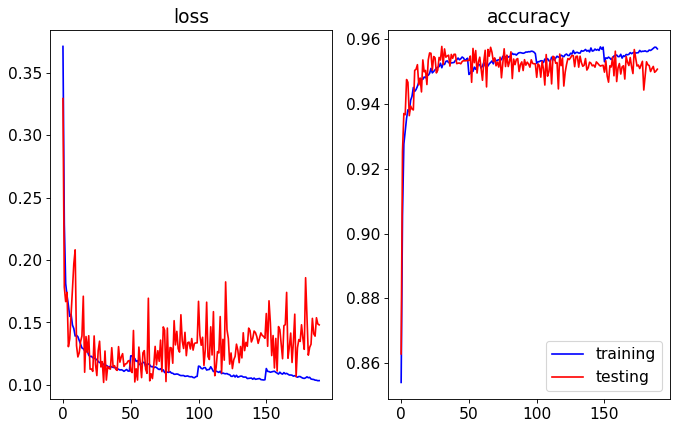

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


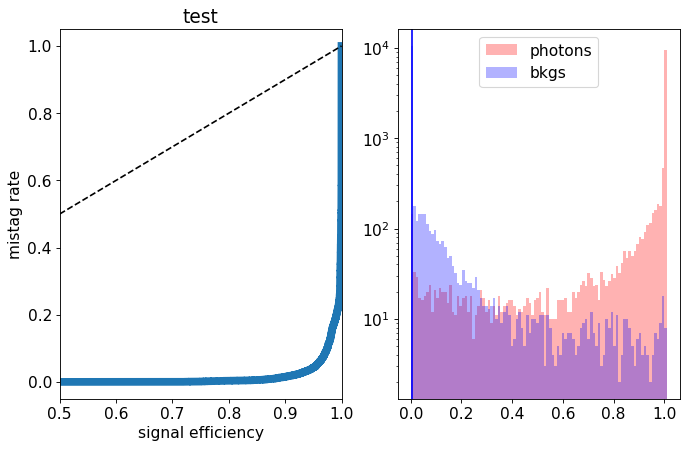

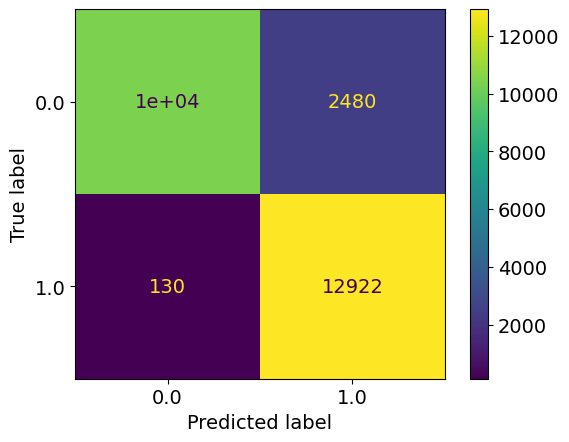

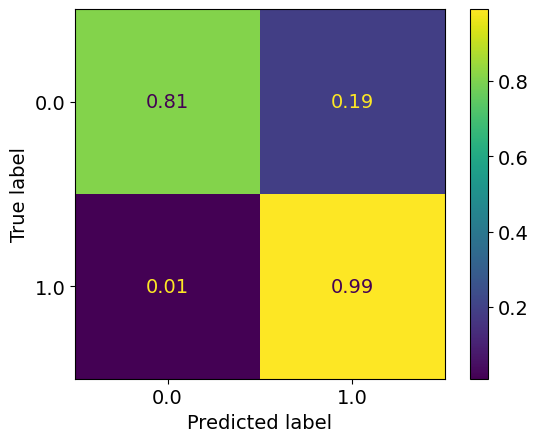

epoch: 190
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10343262122545628
train acc: 0.95636666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.14832878823984752
test acc: 0.950613
epoch: 191
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.1044996721896133
train acc: 0.9567137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.90it/s]


test loss: 0.13713877614248882
test acc: 0.9517696
epoch: 192
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10355541058358429
train acc: 0.95695466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.1418688962744041
test acc: 0.95084435
epoch: 193
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1031778301892942
train acc: 0.95702213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.14229385927319527
test acc: 0.95099854
epoch: 194
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10301637240400204
train acc: 0.95776427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.15214910408989948
test acc: 0.95007324
epoch: 195
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10180920181591387
train acc: 0.95770645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1456333254887299
test acc: 0.9504973
epoch: 196
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10259369971779729
train acc: 0.9571667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.37it/s]


test loss: 0.1491971987892281
test acc: 0.95022744
epoch: 197
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10225364328981135
train acc: 0.9574751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.14558098278939724
test acc: 0.95057446
epoch: 198
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10327640998397948
train acc: 0.9570703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.35it/s]


test loss: 0.14484221522103657
test acc: 0.9506515
epoch: 199
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10185704681742398
train acc: 0.9582366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.142664277756756
test acc: 0.950613


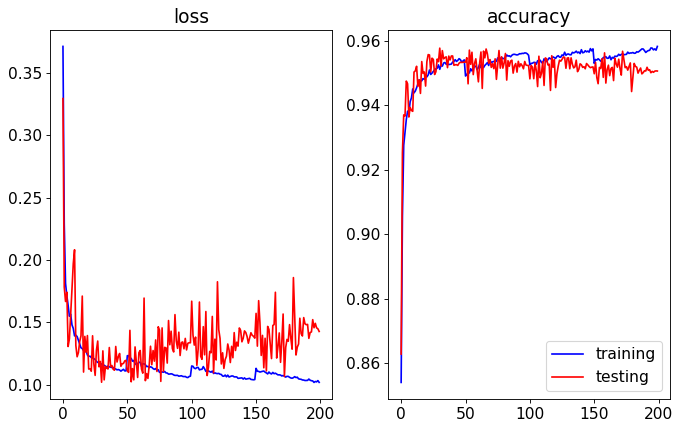

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


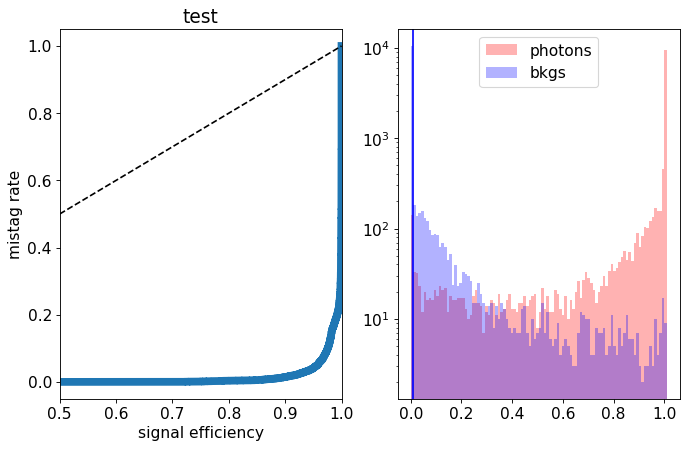

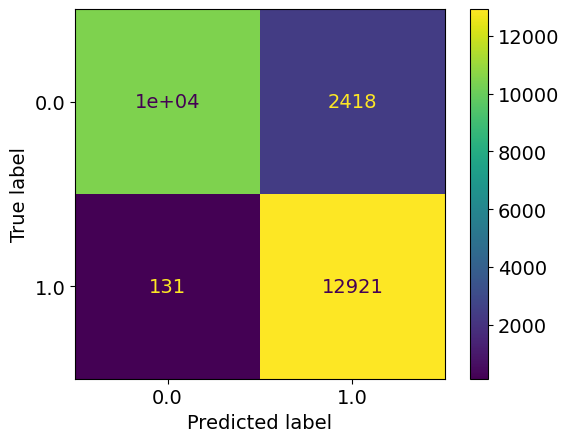

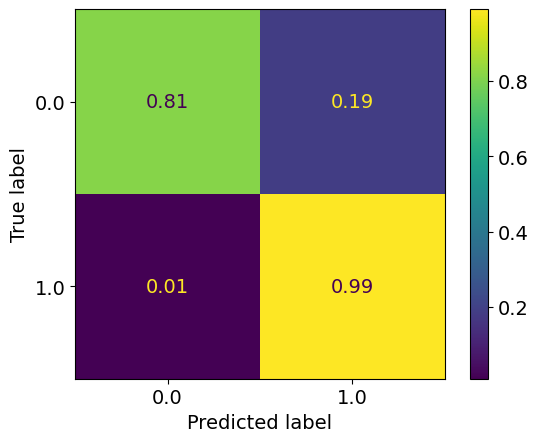

epoch: 200
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.10975961120142413
train acc: 0.95490164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.75it/s]


test loss: 0.14235077916898511
test acc: 0.95030457
epoch: 201
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.11058144913071152
train acc: 0.9540631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.39it/s]


test loss: 0.11760058203204111
test acc: 0.9548539
epoch: 202
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.1088627678465981
train acc: 0.95504624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.16114879865199327
test acc: 0.94802994
epoch: 203
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10915184809121094
train acc: 0.9548727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.13355348479341378
test acc: 0.9516925
epoch: 204
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10828119079243241
train acc: 0.95540285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.13874982788481496
test acc: 0.9513455
epoch: 205
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10863868737151858
train acc: 0.9553932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.73it/s]


test loss: 0.13838011415844614
test acc: 0.95096
epoch: 206
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.10it/s]


train loss: 0.10922226740445705
train acc: 0.9546414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.15it/s]


test loss: 0.11133932610127059
test acc: 0.95612615
epoch: 207
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.10770509529837294
train acc: 0.95516187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.18it/s]


test loss: 0.12873878042128953
test acc: 0.9514612
epoch: 208
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.10788125402665552
train acc: 0.9546896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.07it/s]


test loss: 0.12416395799002865
test acc: 0.95489246
epoch: 209
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10984035912965763
train acc: 0.9544583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.11it/s]


test loss: 0.13227706588804722
test acc: 0.9532346


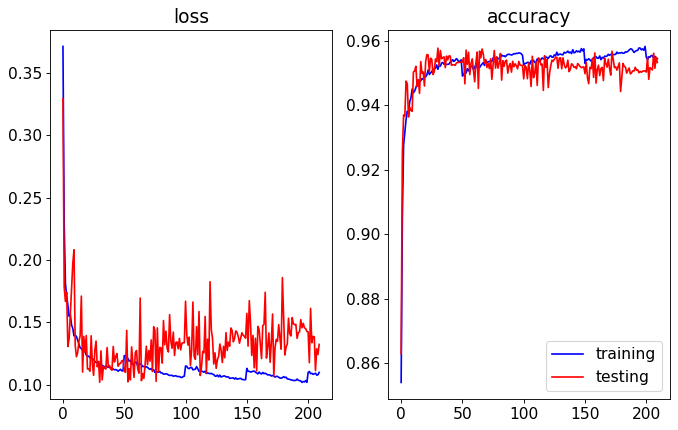

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


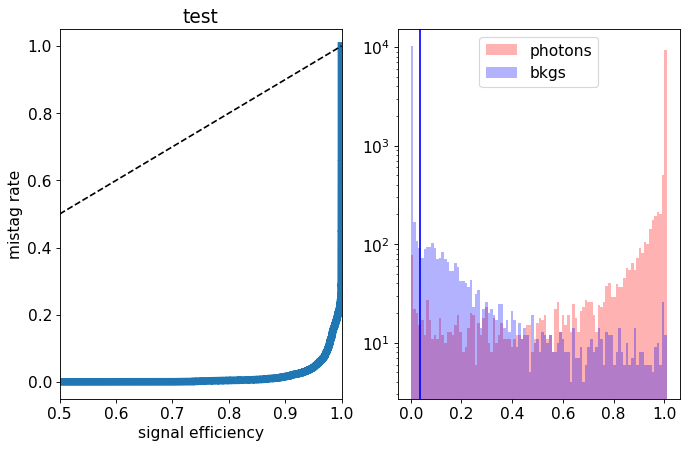

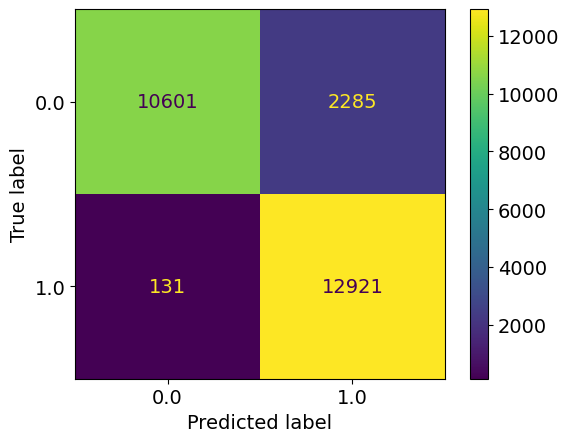

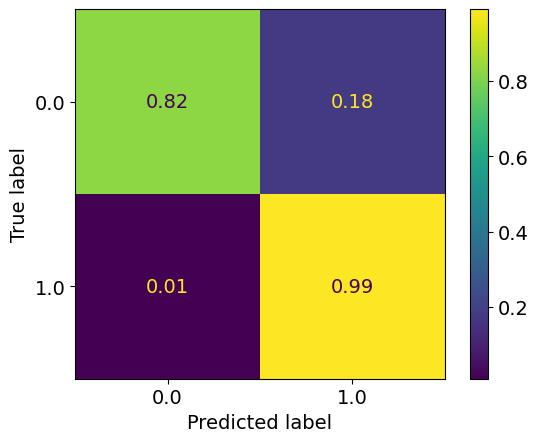

epoch: 210
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.10759361501718533
train acc: 0.95568234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.45it/s]


test loss: 0.1348098082975908
test acc: 0.9494178
epoch: 211
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10665357362672773
train acc: 0.9559233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.1709698782387105
test acc: 0.9464878
epoch: 212
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10759775702319394
train acc: 0.95546067


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.1427373867481947
test acc: 0.9495335
epoch: 213
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10648536372046939
train acc: 0.95618355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.14376159181649034
test acc: 0.94818413
epoch: 214
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10728820210936442
train acc: 0.955692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.16468563879078085
test acc: 0.94922507
epoch: 215
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10637644441486094
train acc: 0.955933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.1580271063880487
test acc: 0.948454
epoch: 216
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.1061798698037346
train acc: 0.9563185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.30it/s]


test loss: 0.1561223485253074
test acc: 0.9491865
epoch: 217
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.10674469302155379
train acc: 0.9559619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.1246075995943763
test acc: 0.95126843
epoch: 218
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10619384791120628
train acc: 0.95582694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.92it/s]


test loss: 0.1672883772037246
test acc: 0.9452541
epoch: 219
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10659602181070801
train acc: 0.955692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.12605441683395344
test acc: 0.954584


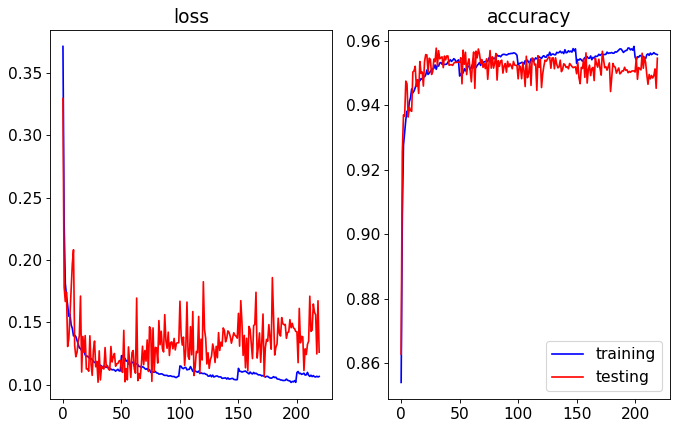

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


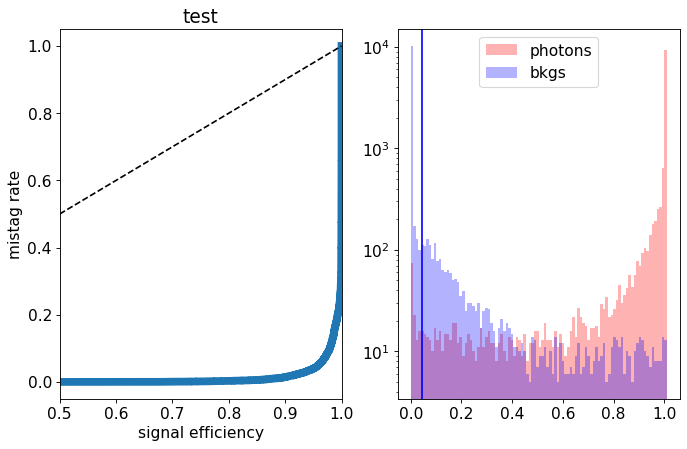

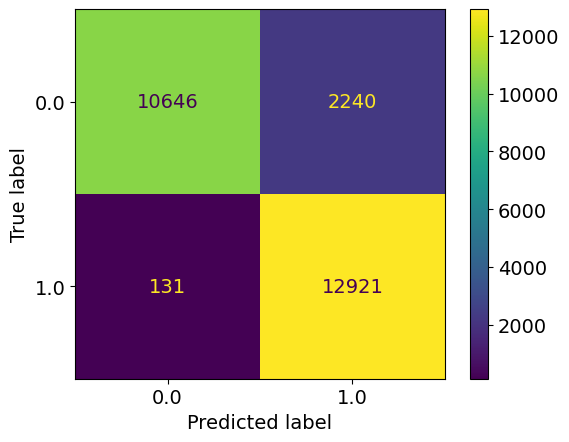

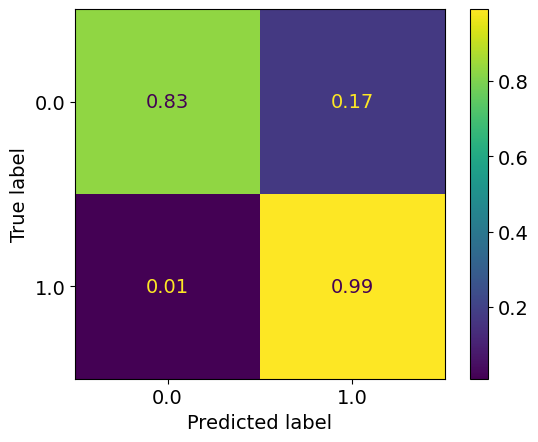

epoch: 220
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.105098185339415
train acc: 0.9561643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.15476800078018146
test acc: 0.9474516
epoch: 221
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10641232468833813
train acc: 0.95600045


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.1307828143577684
test acc: 0.9513455
epoch: 222
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10588192870851197
train acc: 0.9566751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.78it/s]


test loss: 0.13950457373125988
test acc: 0.9520395
epoch: 223
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10519100131327017
train acc: 0.95651126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.16906548562374982
test acc: 0.9477986
epoch: 224
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.1047347953295432
train acc: 0.9558655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.14276244982399725
test acc: 0.952425
epoch: 225
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10516797367892514
train acc: 0.95638597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.13440284844149242
test acc: 0.9516925
epoch: 226
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10435003838959457
train acc: 0.9572534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.93it/s]


test loss: 0.1340744769708677
test acc: 0.951731
epoch: 227
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10364827918523999
train acc: 0.9571185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.13693655095994473
test acc: 0.95369726
epoch: 228
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10372846831992871
train acc: 0.95737875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.154406300322576
test acc: 0.9483769
epoch: 229
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10429360562494036
train acc: 0.95695466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.15002952922474255
test acc: 0.95238644


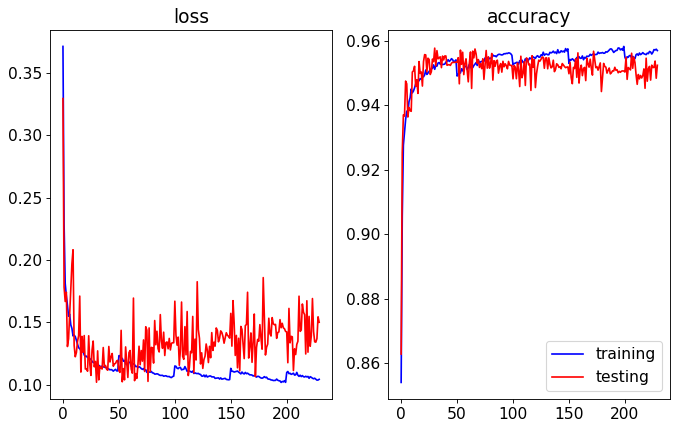

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.58it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


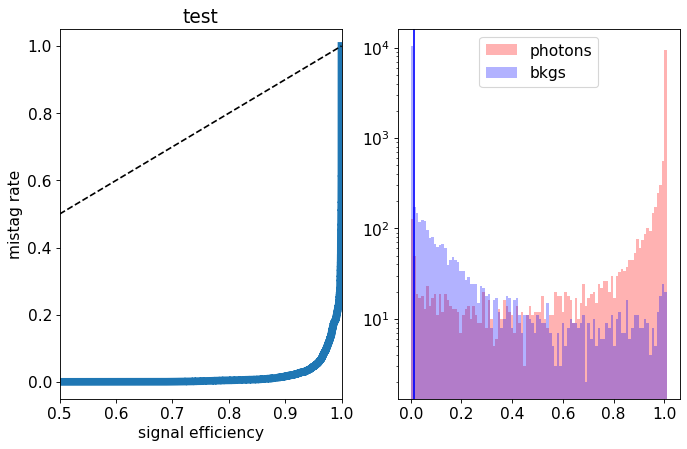

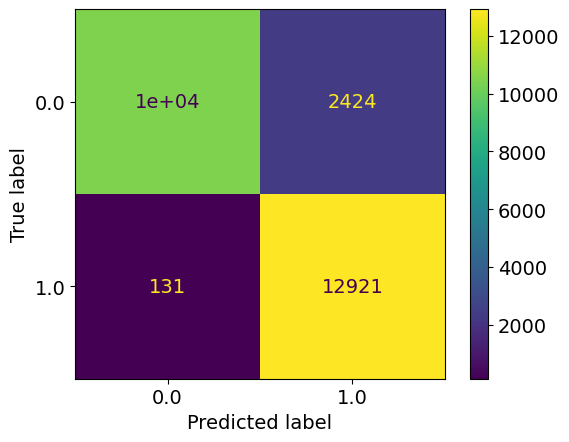

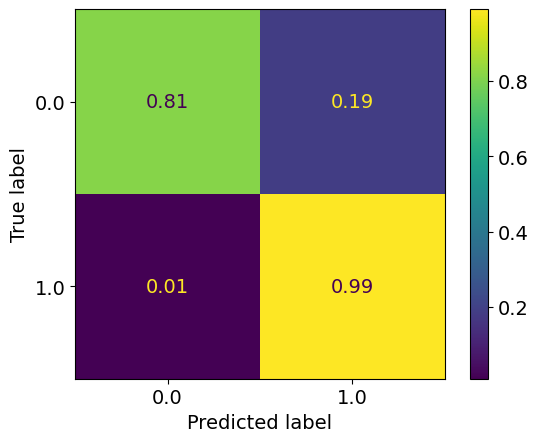

epoch: 230
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.1041495923620428
train acc: 0.9565305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.13522670485756613
test acc: 0.95072865
epoch: 231
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10298203831979993
train acc: 0.95770645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.14089785939590496
test acc: 0.95126843
epoch: 232
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10370401491147245
train acc: 0.95737875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.15616180815479971
test acc: 0.94868535
epoch: 233
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10388165994445024
train acc: 0.957157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.15585783479565923
test acc: 0.94937927
epoch: 234
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10329539880070383
train acc: 0.9574462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.87it/s]


test loss: 0.1437140056355433
test acc: 0.95115274
epoch: 235
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.1028060958521559
train acc: 0.9578414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.15475072593174197
test acc: 0.95030457
epoch: 236
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10321357579245044
train acc: 0.95776427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.79it/s]


test loss: 0.1353176294571974
test acc: 0.95096
epoch: 237
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10280016590060526
train acc: 0.95750403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.59it/s]


test loss: 0.15099299665201793
test acc: 0.94872385
epoch: 238
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.10345852375030518
train acc: 0.9567908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.1440699217333035
test acc: 0.95007324
epoch: 239
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.10319619083163366
train acc: 0.9575715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.34it/s]


test loss: 0.14708860557187686
test acc: 0.949572


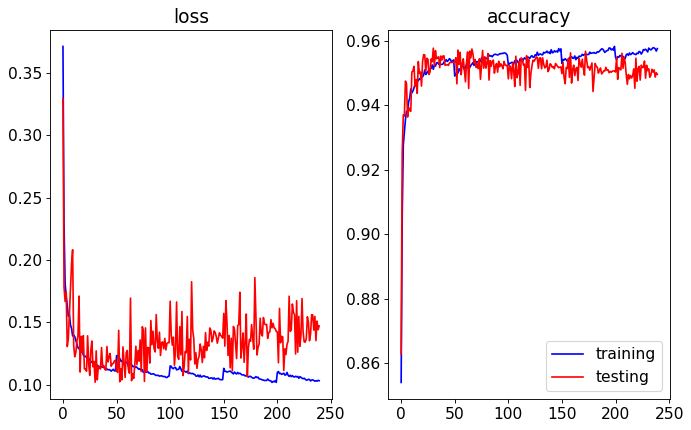

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


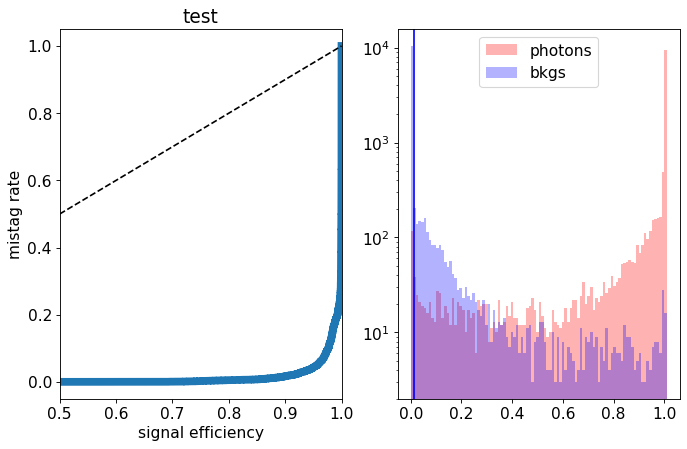

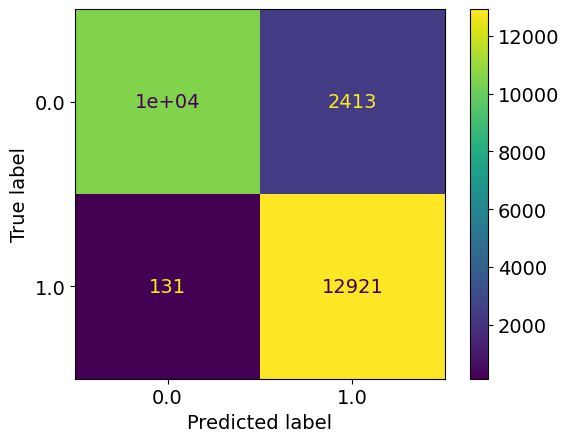

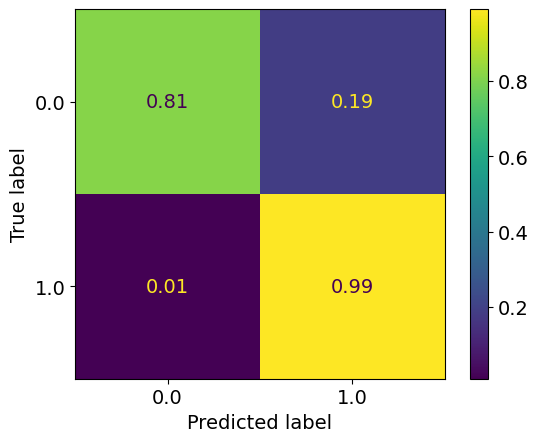

epoch: 240
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.10206579597871428
train acc: 0.9576968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.91it/s]


test loss: 0.1479837125675245
test acc: 0.9501118
epoch: 241
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10188786211730427
train acc: 0.9577257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.72it/s]


test loss: 0.14168289642442355
test acc: 0.950613
epoch: 242
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10232669007399178
train acc: 0.95783174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.01it/s]


test loss: 0.14120950482108377
test acc: 0.9514612
epoch: 243
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10225357989527586
train acc: 0.95774496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.14117606068876656
test acc: 0.9511142
epoch: 244
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10220505327330848
train acc: 0.95783174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.1454153780571439
test acc: 0.9501118
epoch: 245
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.10134203908588156
train acc: 0.9578124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.14188221723518588
test acc: 0.95022744
epoch: 246
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.10152936253072209
train acc: 0.9575137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.09it/s]


test loss: 0.14823503453623166
test acc: 0.9501504
epoch: 247
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.48it/s]


train loss: 0.1016498618043227
train acc: 0.957957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.14584310048005797
test acc: 0.950266
epoch: 248
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10237953010838845
train acc: 0.9576101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.68it/s]


test loss: 0.14520901831036265
test acc: 0.95030457
epoch: 249
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.10170041153885725
train acc: 0.95761967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.1465939347716895
test acc: 0.9503817


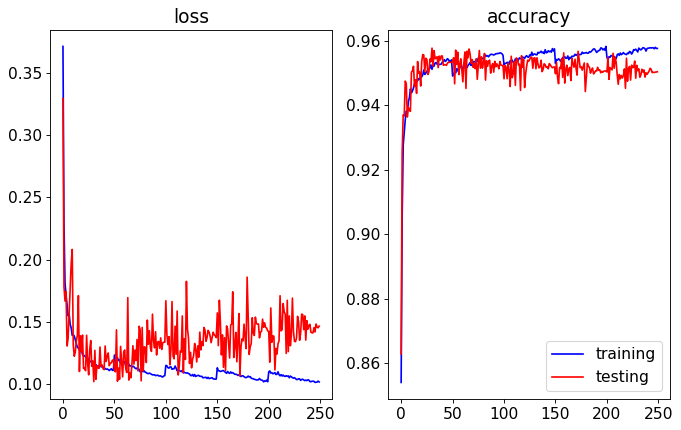

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.27it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


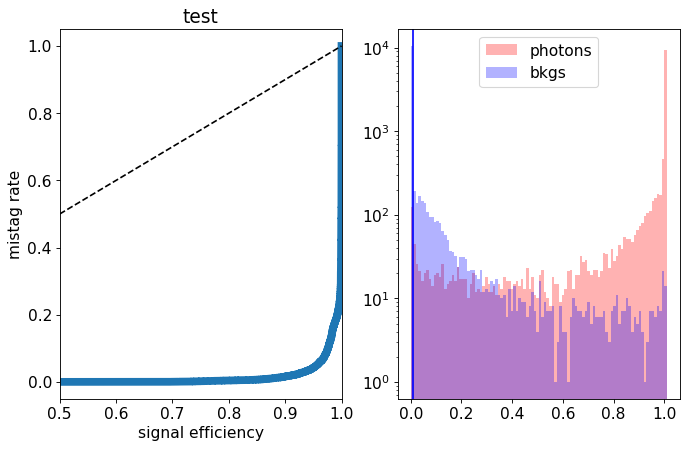

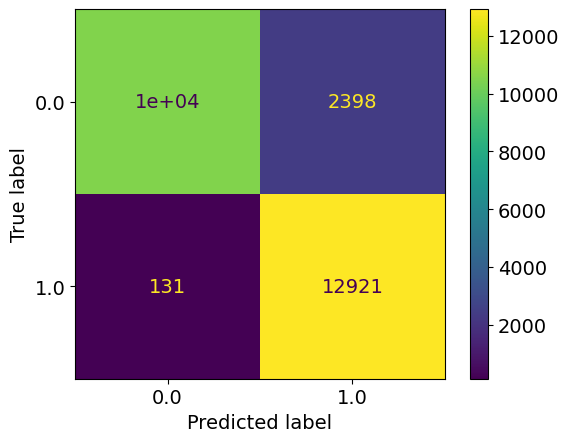

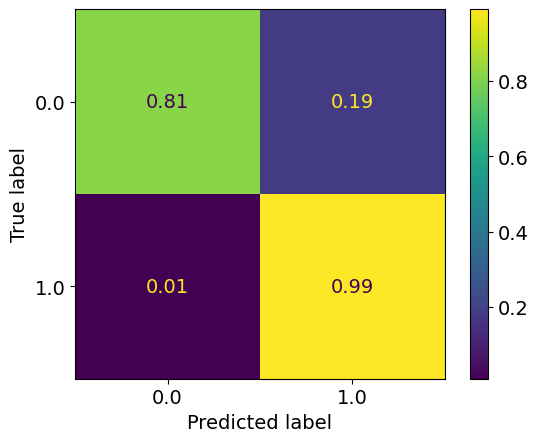

epoch: 250
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.20it/s]


train loss: 0.10926385383213187
train acc: 0.95497876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.11982111632823944
test acc: 0.95331174
epoch: 251
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10720337610799453
train acc: 0.95567274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.1608840919692408
test acc: 0.9499962
epoch: 252
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.10824261149230031
train acc: 0.95505583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.12910006195306778
test acc: 0.9518467
epoch: 253
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1088286662377374
train acc: 0.955239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.34it/s]


test loss: 0.1218740012158047
test acc: 0.95180815
epoch: 254
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10795308645233254
train acc: 0.95513296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.90it/s]


test loss: 0.14695973609658805
test acc: 0.950266
epoch: 255
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10677320958045176
train acc: 0.9554799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.29it/s]


test loss: 0.12436809306117622
test acc: 0.9543141
epoch: 256
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10643839112596015
train acc: 0.9557691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.159643197262829
test acc: 0.9478372
epoch: 257
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10654344237436449
train acc: 0.955451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.15746312520720743
test acc: 0.9493022
epoch: 258
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10772676830519141
train acc: 0.955933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.16553077304905112
test acc: 0.9467962
epoch: 259
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1061358291203576
train acc: 0.9555185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.15042813088406215
test acc: 0.9486468


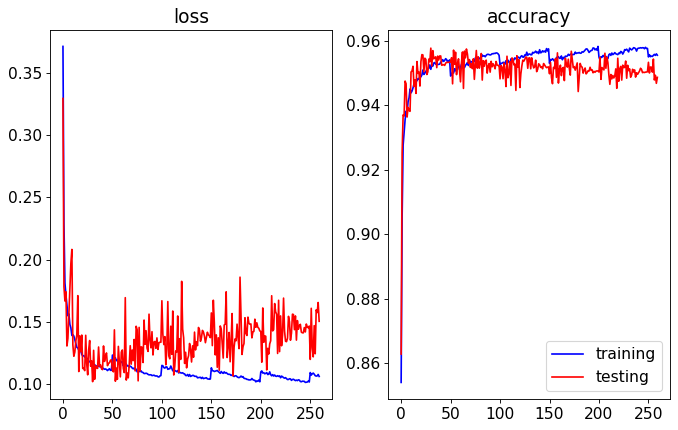

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


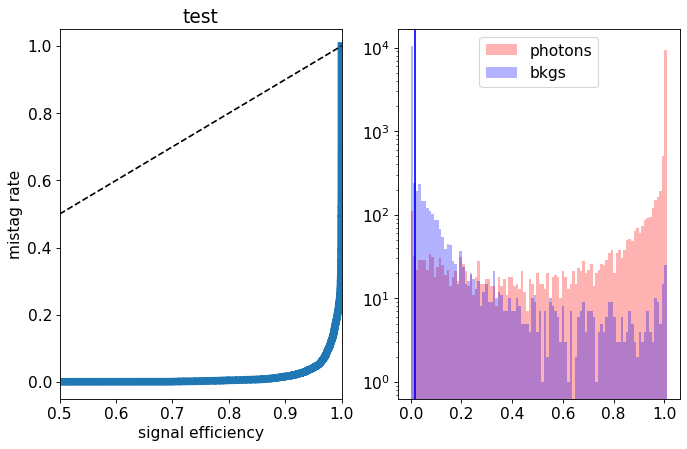

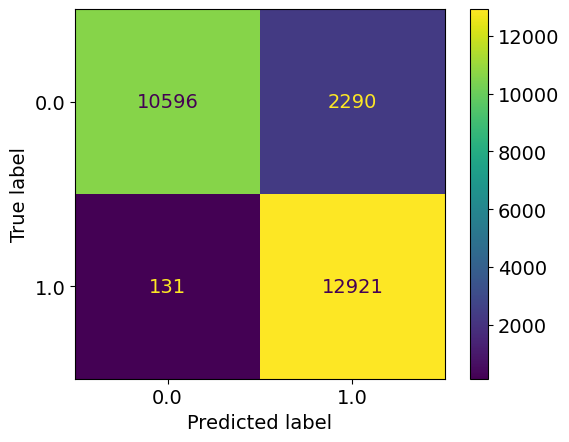

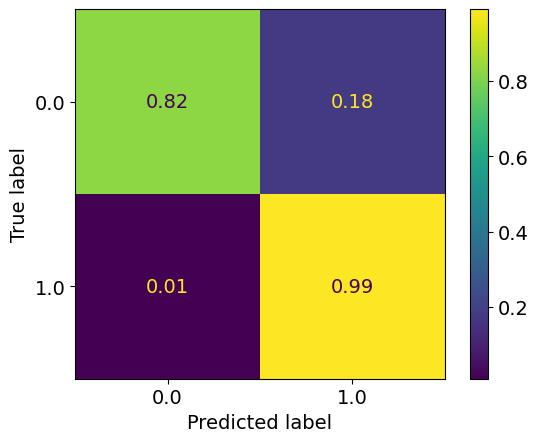

epoch: 260
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1085839650534481
train acc: 0.9551137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.12922327440570702
test acc: 0.95096
epoch: 261
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.10600469011619601
train acc: 0.95601004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.12612651322375645
test acc: 0.95423704
epoch: 262
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10535256099494207
train acc: 0.9568004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.90it/s]


test loss: 0.1485818170688369
test acc: 0.950266
epoch: 263
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10554604559619991
train acc: 0.95737875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.1611593927002766
test acc: 0.94722027
epoch: 264
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10657010012107089
train acc: 0.955933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.16132775660265575
test acc: 0.9485311
epoch: 265
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1045488334890735
train acc: 0.9566751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.1265008788217198
test acc: 0.9538515
epoch: 266
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10498694214173135
train acc: 0.95651126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.166512939740311
test acc: 0.94976485
epoch: 267
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10587892780414207
train acc: 0.9557884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.159823890267448
test acc: 0.9486082
epoch: 268
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10575995753610755
train acc: 0.9559715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.38it/s]


test loss: 0.14366281760687177
test acc: 0.94910944
epoch: 269
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10522344075358672
train acc: 0.956598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.16658150116828355
test acc: 0.9467191


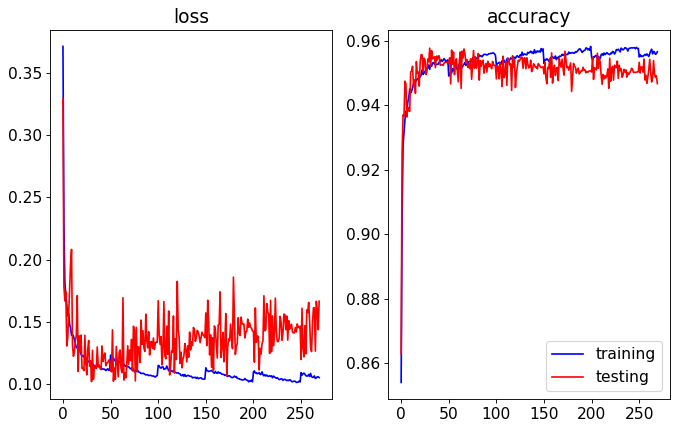

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


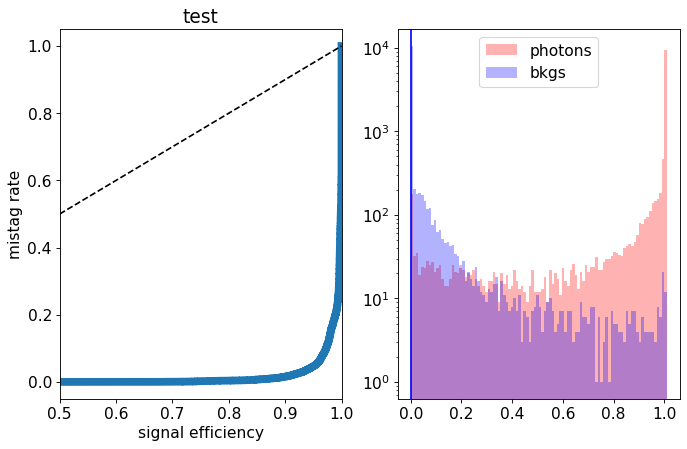

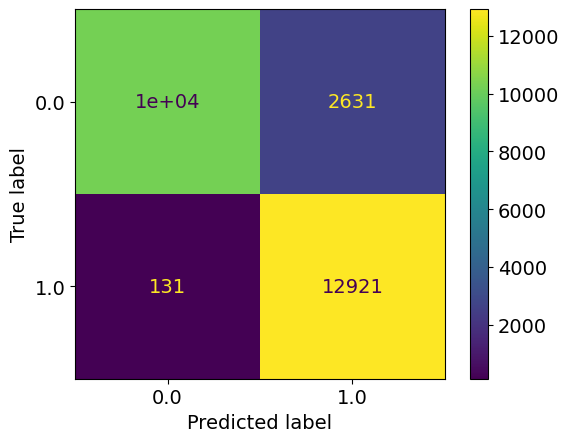

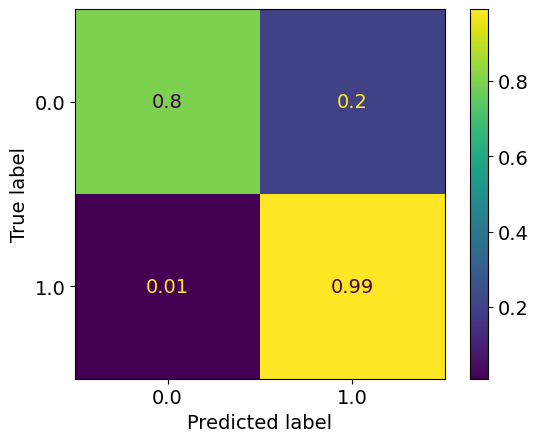

epoch: 270
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1060119636055362
train acc: 0.9561354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.1412119186398658
test acc: 0.9525792
epoch: 271
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10478104284905285
train acc: 0.9566462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.12906219573183494
test acc: 0.9514997
epoch: 272
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.37it/s]


train loss: 0.10485624138674984
train acc: 0.9563474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.16533550061285496
test acc: 0.94625646
epoch: 273
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10379766220646787
train acc: 0.9567137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.1466014508835294
test acc: 0.94802994
epoch: 274
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.1042508567774916
train acc: 0.9570703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.17344199849123304
test acc: 0.9460637
epoch: 275
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10387004420936452
train acc: 0.95738834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.1324254756962711
test acc: 0.95304185
epoch: 276
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10411886046129155
train acc: 0.95668477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.1577259334312244
test acc: 0.9494178
epoch: 277
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10437860193452395
train acc: 0.9570414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.14416750562800604
test acc: 0.9506515
epoch: 278
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10315085755865698
train acc: 0.9574751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.1530396741899577
test acc: 0.94949496
epoch: 279
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10408135206368617
train acc: 0.9574269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.14809496683830564
test acc: 0.9494178


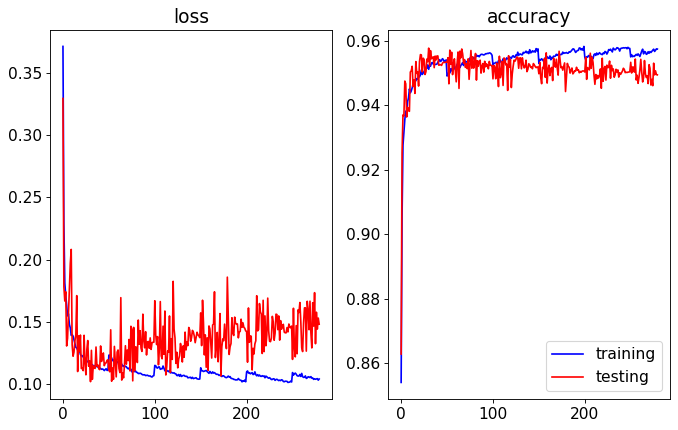

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.23it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


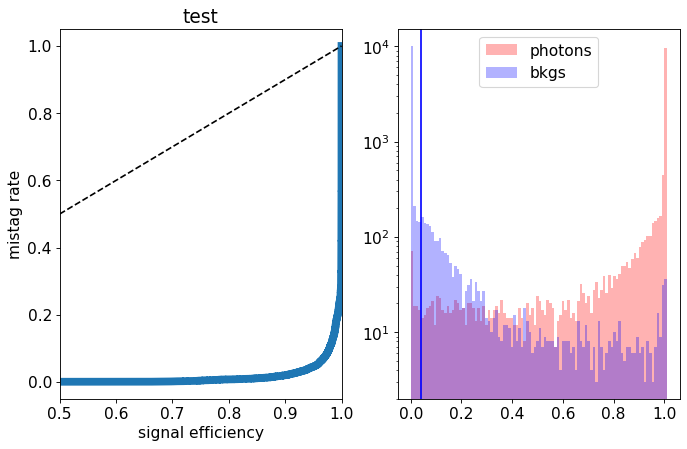

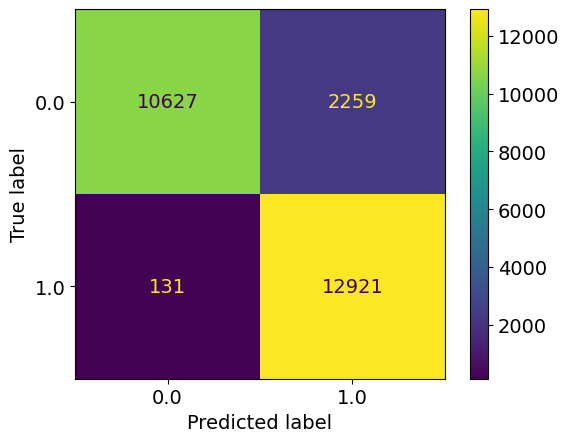

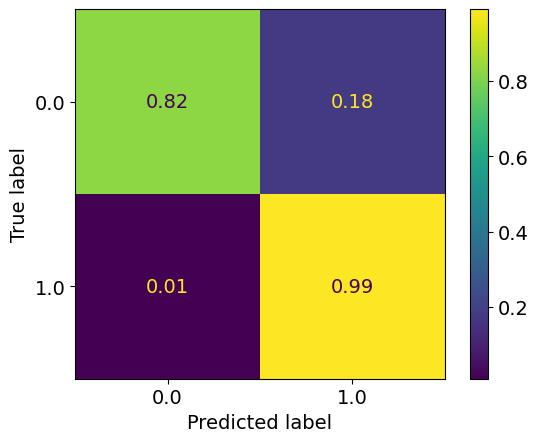

epoch: 280
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10317013404100617
train acc: 0.9575715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.14311282760040325
test acc: 0.9506515
epoch: 281
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10338563812261371
train acc: 0.95750403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.15090447664260864
test acc: 0.9485311
epoch: 282
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1028849291965107
train acc: 0.9576004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.81it/s]


test loss: 0.14794298786331306
test acc: 0.9526949
epoch: 283
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10406088975468122
train acc: 0.95693535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.15652809563008221
test acc: 0.9494178
epoch: 284
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10312530829038234
train acc: 0.9576968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.1486833237788894
test acc: 0.9506901
epoch: 285
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10183072770606576
train acc: 0.9582269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.14445795118808746
test acc: 0.9501504
epoch: 286
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10230242529873214
train acc: 0.9577257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.1490579450672323
test acc: 0.9510371
epoch: 287
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10244408783885096
train acc: 0.9572534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.16319509426301176
test acc: 0.9496877
epoch: 288
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10233240376490389
train acc: 0.957639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.17147892628881065
test acc: 0.9468733
epoch: 289
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10214528195947581
train acc: 0.95734984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.15168240327726712
test acc: 0.94980335


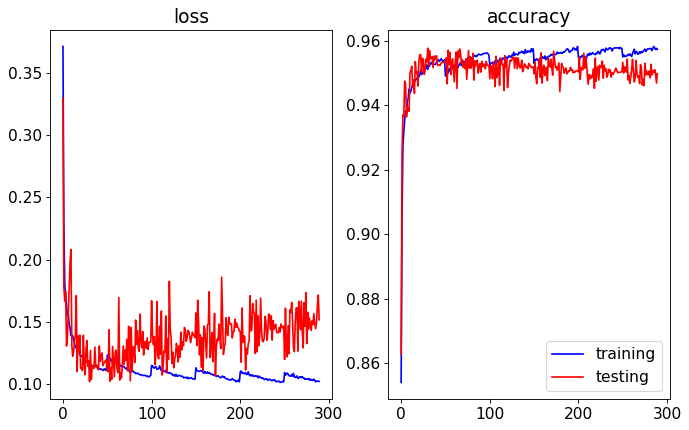

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


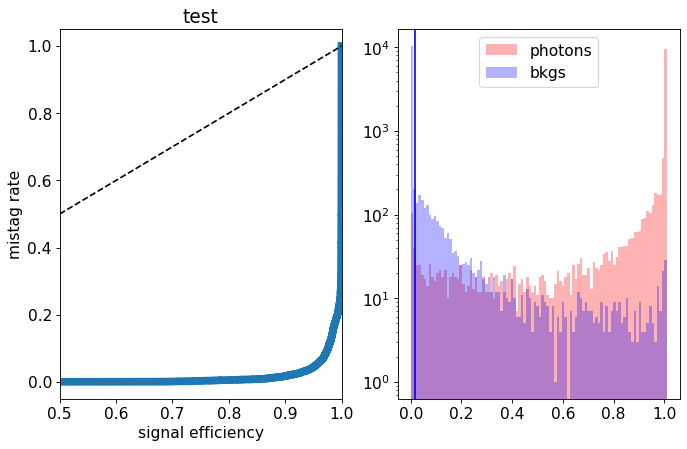

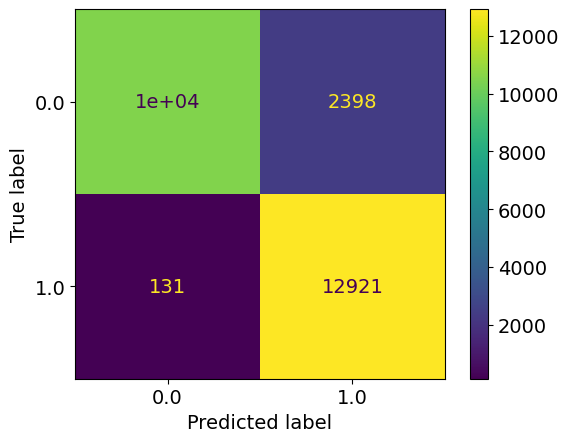

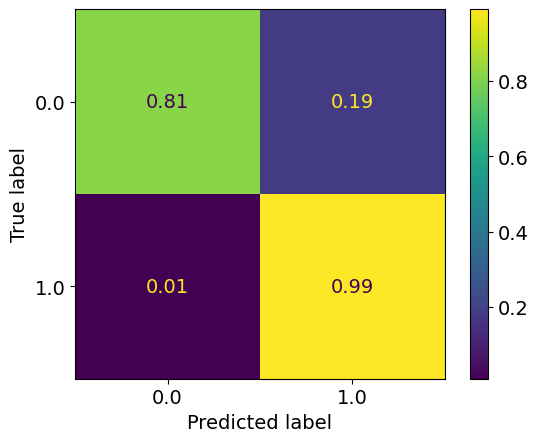

epoch: 290
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10182964754414696
train acc: 0.95843893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.07it/s]


test loss: 0.1594025423242287
test acc: 0.94899374
epoch: 291
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.1015356971607732
train acc: 0.95765823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.16051785867999901
test acc: 0.9486468
epoch: 292
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10155357446284652
train acc: 0.958092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.31it/s]


test loss: 0.1579321873458949
test acc: 0.9497263
epoch: 293
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10178404744994433
train acc: 0.9582076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.15907897393811832
test acc: 0.9491865
epoch: 294
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10123196110732294
train acc: 0.9578124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.16952234726737847
test acc: 0.9478757
epoch: 295
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10181241372675565
train acc: 0.95737875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.73it/s]


test loss: 0.1604742964898998
test acc: 0.94937927
epoch: 296
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10093446116829884
train acc: 0.95806307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16172778962010687
test acc: 0.949572
epoch: 297
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10099867830386741
train acc: 0.95869917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.158720848235217
test acc: 0.9490323
epoch: 298
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10092306653888239
train acc: 0.958198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.15912924977866086
test acc: 0.94910944
epoch: 299
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.1017838757420551
train acc: 0.95801485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.15936334956098686
test acc: 0.9490323


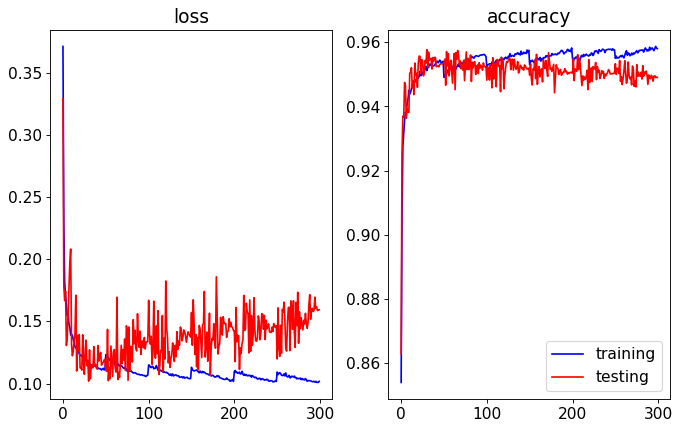

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


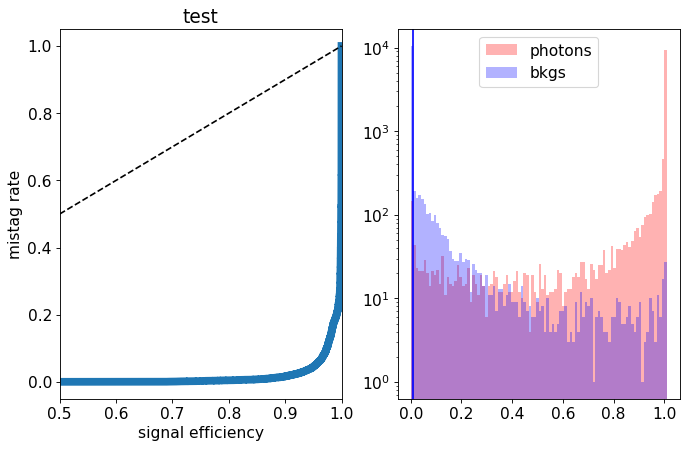

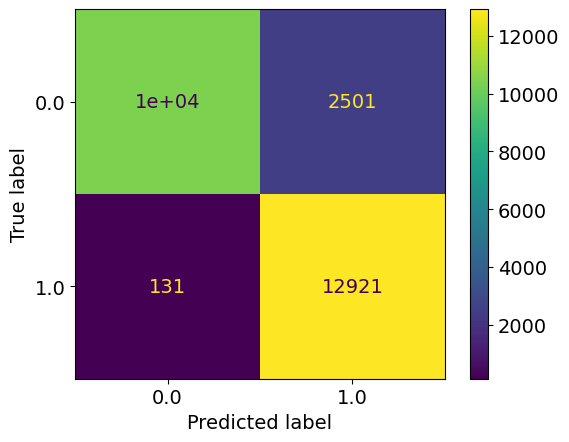

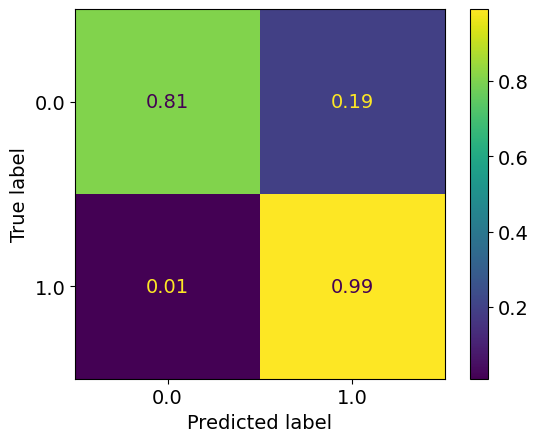

epoch: 300
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.10746879694778795
train acc: 0.9560197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.13it/s]


test loss: 0.18571296757595104
test acc: 0.94421315
epoch: 301
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.45it/s]


train loss: 0.10708476025934165
train acc: 0.9559619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.31it/s]


test loss: 0.13398039815100757
test acc: 0.95230937
epoch: 302
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.10531210593577754
train acc: 0.95645344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.40it/s]


test loss: 0.1631114362654361
test acc: 0.9477986
epoch: 303
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10706883315750629
train acc: 0.9555089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.35it/s]


test loss: 0.14980440231209452
test acc: 0.9498805
epoch: 304
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.1061960480288963
train acc: 0.9560968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.17925731820816343
test acc: 0.9444444
epoch: 305
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10680180762199998
train acc: 0.9559619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.16it/s]


test loss: 0.13196436993100427
test acc: 0.95338887
epoch: 306
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.1066211638164658
train acc: 0.9558366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.90it/s]


test loss: 0.16312717680226674
test acc: 0.9480685
epoch: 307
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10602300084395215
train acc: 0.9562607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.24it/s]


test loss: 0.13431780920787292
test acc: 0.9512299
epoch: 308
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.42it/s]


train loss: 0.10578986864558534
train acc: 0.9564438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.54it/s]


test loss: 0.14032850025052374
test acc: 0.95099854
epoch: 309
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10567002153465513
train acc: 0.95612574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.87it/s]


test loss: 0.21128613908182492
test acc: 0.94170713


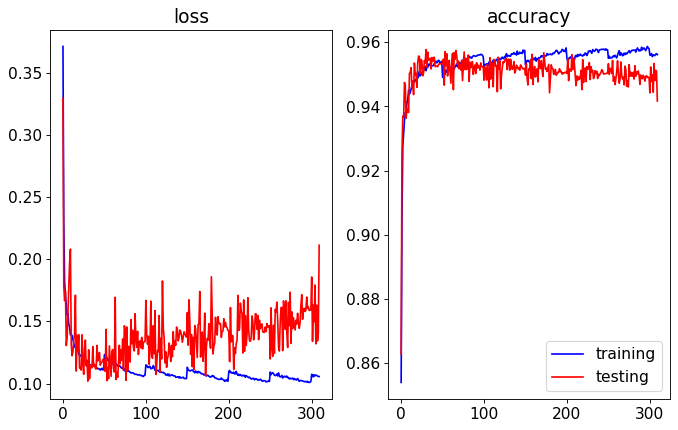

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


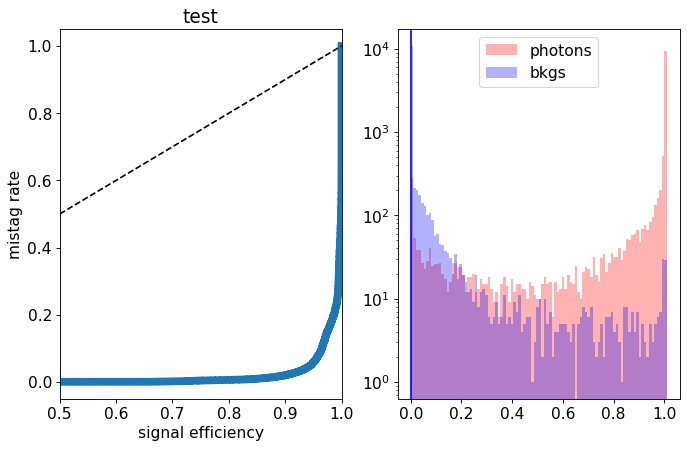

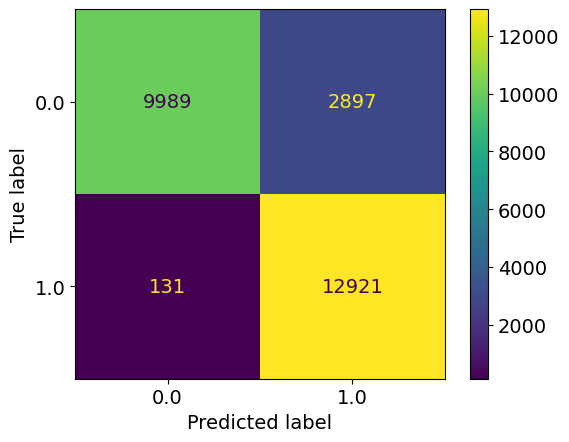

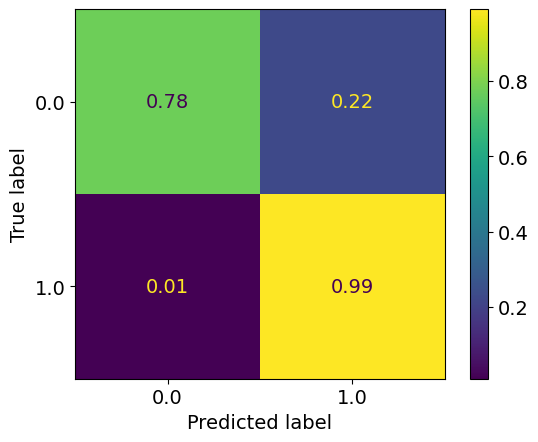

epoch: 310
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10517937311030537
train acc: 0.9568775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.210307046093724
test acc: 0.9440589
epoch: 311
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10635968185745912
train acc: 0.95601004


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.11402725699273022
test acc: 0.9551623
epoch: 312
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.106745929731799
train acc: 0.9561643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.37it/s]


test loss: 0.1613341850990599
test acc: 0.94791424
epoch: 313
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10593796766906804
train acc: 0.95636666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.12717716819183392
test acc: 0.9540828
epoch: 314
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10523058465450486
train acc: 0.9562703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.91it/s]


test loss: 0.15992924926633184
test acc: 0.94899374
epoch: 315
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.10601538424030205
train acc: 0.956598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.17557608878070657
test acc: 0.94274807
epoch: 316
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10473144420481831
train acc: 0.9566751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.16117123565213246
test acc: 0.94934076
epoch: 317
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.10532814225537239
train acc: 0.9562896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.32it/s]


test loss: 0.166817883876237
test acc: 0.94868535
epoch: 318
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.10501138934854827
train acc: 0.9568679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.26it/s]


test loss: 0.17459252205761996
test acc: 0.94602513
epoch: 319
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.10522082783927807
train acc: 0.9561643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.16807428578084166
test acc: 0.949572


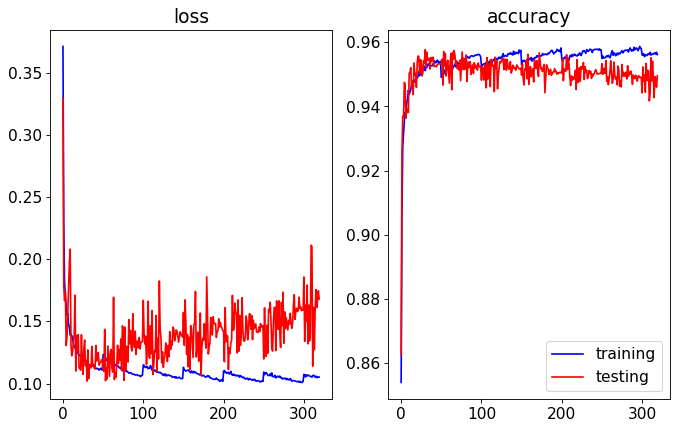

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


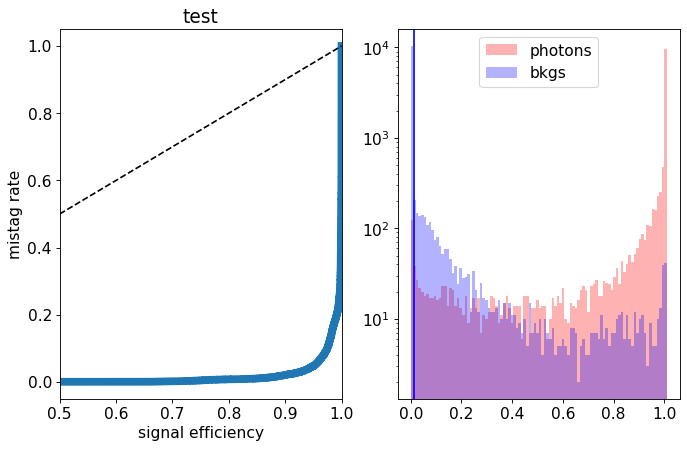

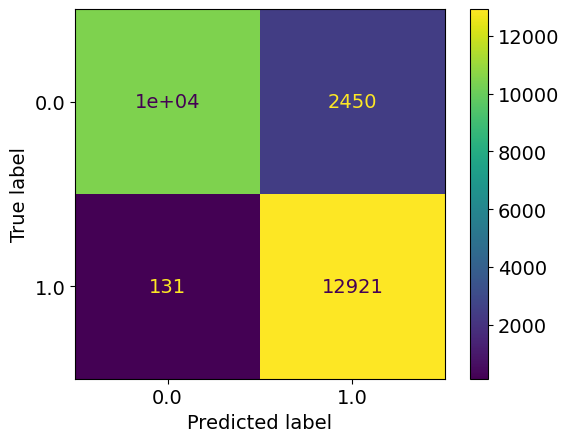

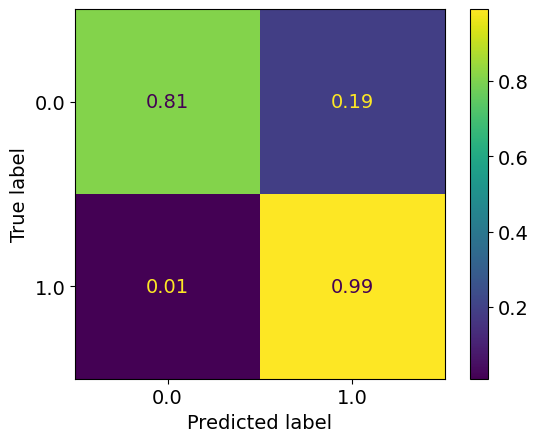

epoch: 320
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10478937526831048
train acc: 0.95645344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.16341273131018336
test acc: 0.9479914
epoch: 321
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1040177693256753
train acc: 0.9576293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.1541557450863448
test acc: 0.9463336
epoch: 322
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10277611783818702
train acc: 0.9571185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16143336502665823
test acc: 0.95034313
epoch: 323
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10425369454429328
train acc: 0.9569161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.18998497758399358
test acc: 0.9456782
epoch: 324
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10410845184946335
train acc: 0.95678115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.15908781659196725
test acc: 0.94922507
epoch: 325
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10421979056961964
train acc: 0.95720524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.14988297359509903
test acc: 0.94802994
epoch: 326
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.1043318888183274
train acc: 0.95669436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.15708815458823333
test acc: 0.9476829
epoch: 327
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10286935655712393
train acc: 0.9577546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.93it/s]


test loss: 0.14689884724264796
test acc: 0.94949496
epoch: 328
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10328212203834787
train acc: 0.95756185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.1411668566817587
test acc: 0.9510756
epoch: 329
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.53it/s]


train loss: 0.10255048419698815
train acc: 0.95756185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.14139498177577148
test acc: 0.95246357


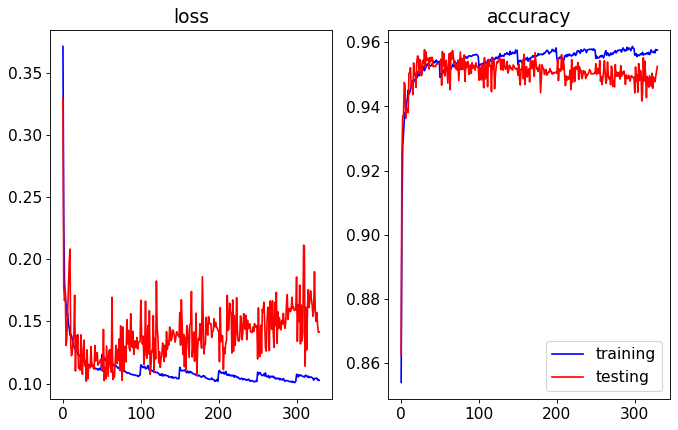

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.25it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


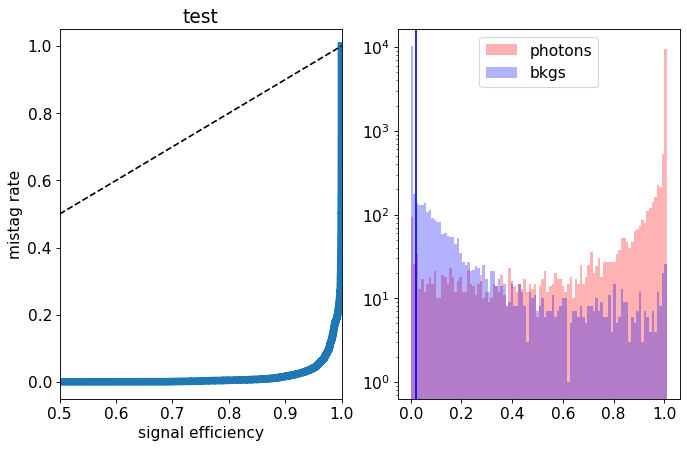

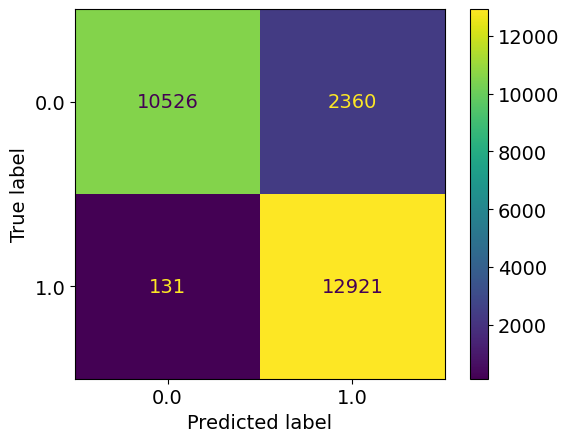

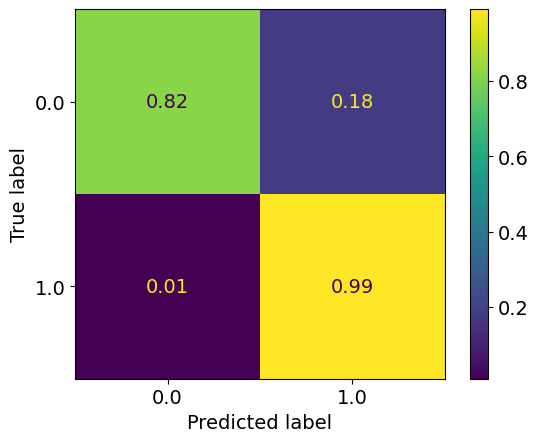

epoch: 330
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10311578709438357
train acc: 0.9575522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.16020679812539707
test acc: 0.9479914
epoch: 331
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10239877465660173
train acc: 0.95750403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.1514968177811666
test acc: 0.9479528
epoch: 332
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10288826479560378
train acc: 0.957398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.16512081450359387
test acc: 0.94617933
epoch: 333
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10231243384022244
train acc: 0.95770645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.16338975727558136
test acc: 0.9479914
epoch: 334
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10165337770315953
train acc: 0.9578221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.1726980170404369
test acc: 0.9454083
epoch: 335
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1018708120450119
train acc: 0.9577932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.16427134976468302
test acc: 0.9483769
epoch: 336
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10195398778584651
train acc: 0.9576679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.15959081477062267
test acc: 0.94668055
epoch: 337
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.10208322025964715
train acc: 0.95831364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.82it/s]


test loss: 0.1466503075577996
test acc: 0.9496877
epoch: 338
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.1010109434238059
train acc: 0.9582751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.37it/s]


test loss: 0.16021826202896508
test acc: 0.94814557
epoch: 339
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.10103973935794279
train acc: 0.95876664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.16013540971008214
test acc: 0.9473745


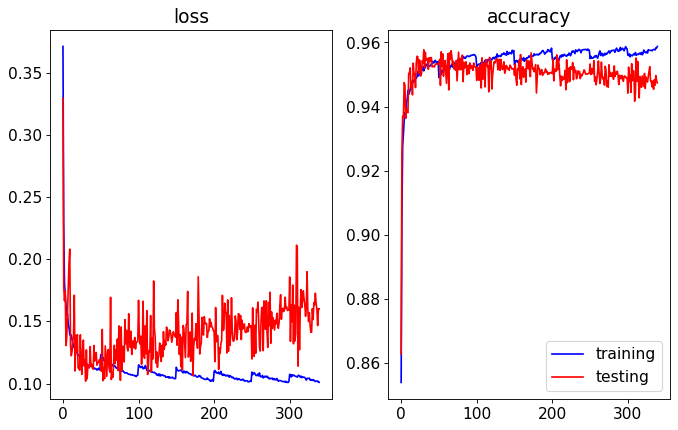

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


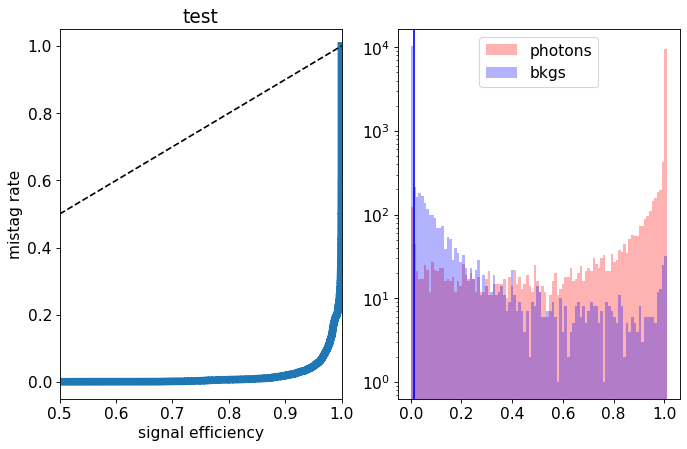

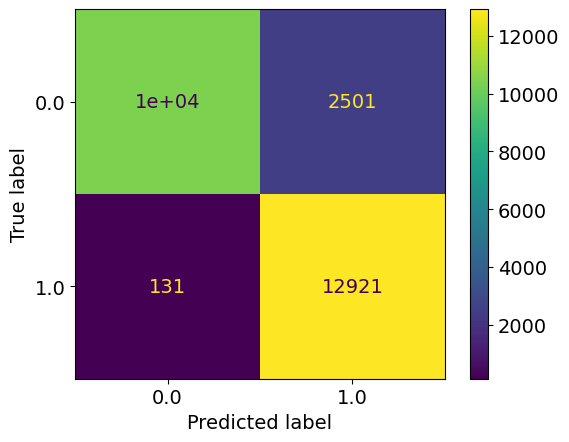

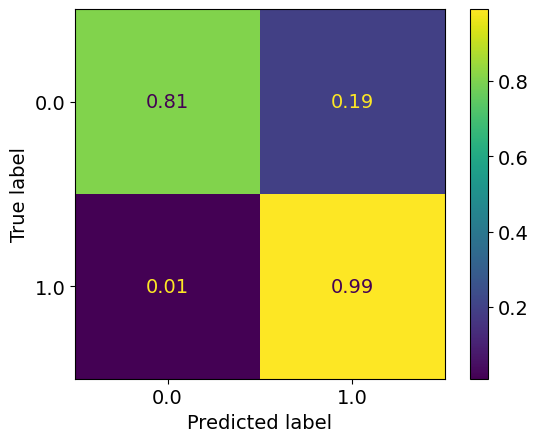

epoch: 340
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10146910684301674
train acc: 0.95800525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.25it/s]


test loss: 0.16137846135957676
test acc: 0.94802994
epoch: 341
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10157161227540473
train acc: 0.9583811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.17334202439947563
test acc: 0.9471432
epoch: 342
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10030344899506927
train acc: 0.9577932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.16255317628383636
test acc: 0.94826126
epoch: 343
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10121243976788714
train acc: 0.9581498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.16475813327865166
test acc: 0.9480685
epoch: 344
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10172130796261605
train acc: 0.9581112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.16692530262199315
test acc: 0.9477986
epoch: 345
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10137548887660738
train acc: 0.9583811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.15739344940944153
test acc: 0.9489167
epoch: 346
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10127259614322916
train acc: 0.958092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.16895419189875777
test acc: 0.94710463
epoch: 347
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10121447071863737
train acc: 0.9577835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.16739911975508387
test acc: 0.9473745
epoch: 348
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1011141847409954
train acc: 0.9581787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.16873555207117039
test acc: 0.9474131
epoch: 349
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10073368699219874
train acc: 0.9578799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.1676806357096542
test acc: 0.94749016


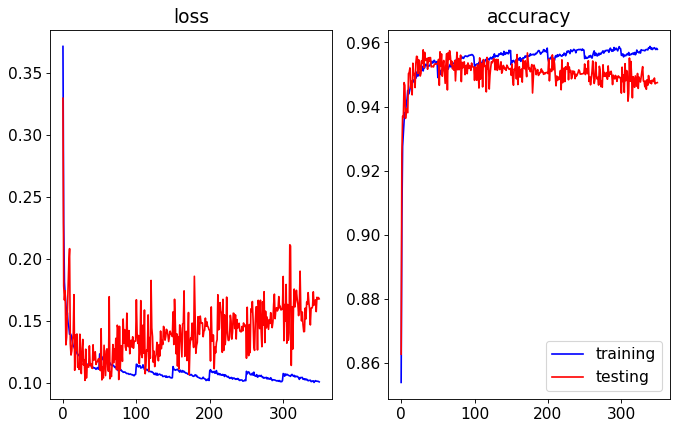

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


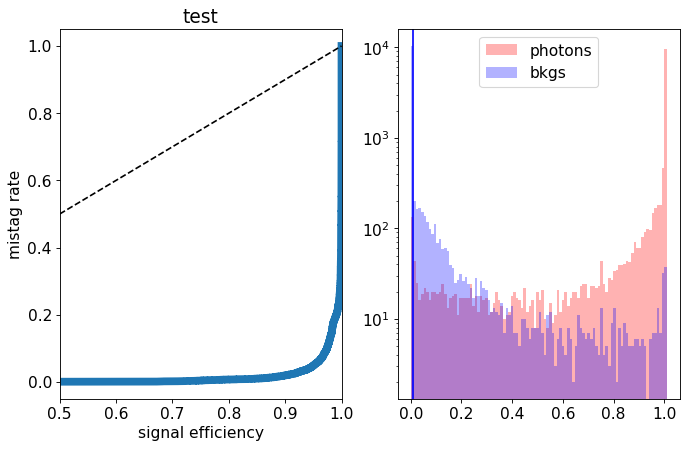

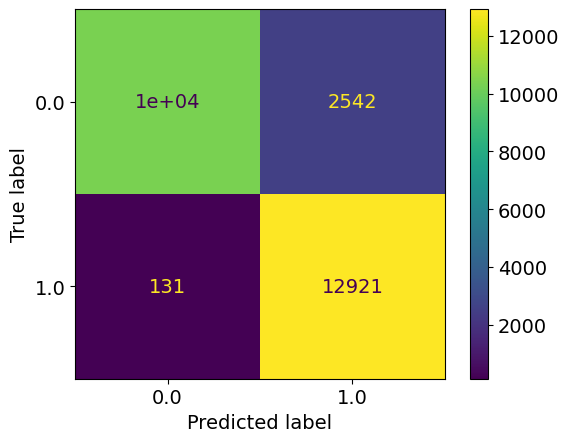

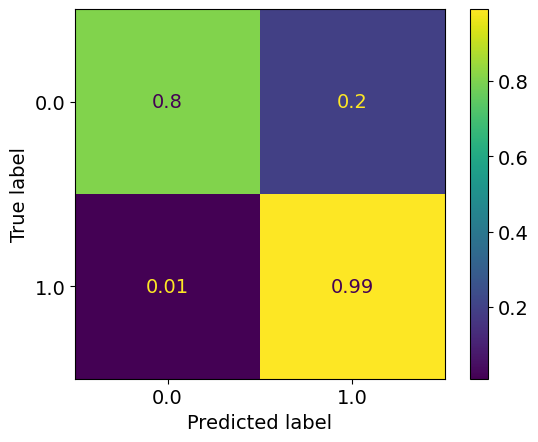

epoch: 350
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10662968792667278
train acc: 0.95575947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.17633603123778646
test acc: 0.9451384
epoch: 351
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1066009601029013
train acc: 0.955933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.1533060890029777
test acc: 0.95126843
epoch: 352
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.10701201341486391
train acc: 0.95591366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.14953609234230084
test acc: 0.94856966
epoch: 353
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.10601189405242832
train acc: 0.95571125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.92it/s]


test loss: 0.14468639360910113
test acc: 0.9512299
epoch: 354
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.43it/s]


train loss: 0.10604469839892636
train acc: 0.95535463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.26it/s]


test loss: 0.15903081609444183
test acc: 0.9508058
epoch: 355
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.48it/s]


train loss: 0.10610220236757587
train acc: 0.9558655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.10it/s]


test loss: 0.14879074997522615
test acc: 0.9509214
epoch: 356
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10476575339632917
train acc: 0.95612574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.129500554705208
test acc: 0.9535045
epoch: 357
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10567484335230955
train acc: 0.9565498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.15375476550649514
test acc: 0.94791424
epoch: 358
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1056149397368376
train acc: 0.9558751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.95it/s]


test loss: 0.16010073267600752
test acc: 0.949572
epoch: 359
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10461457448370884
train acc: 0.95681006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.15727778016166252
test acc: 0.95042026


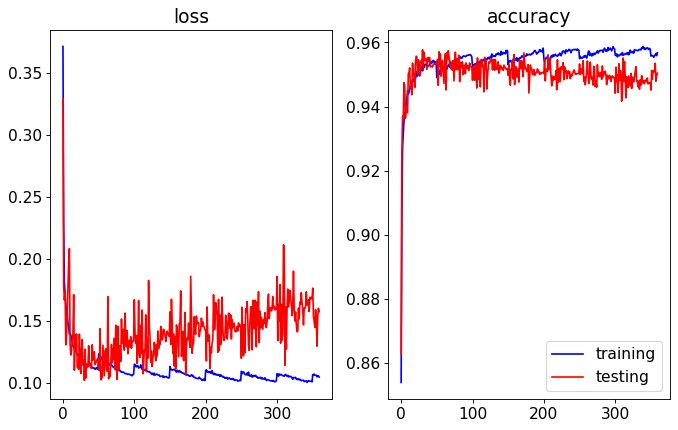

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.85it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


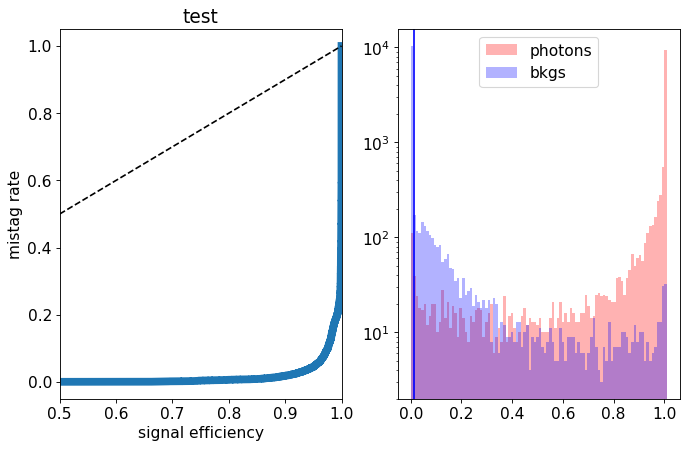

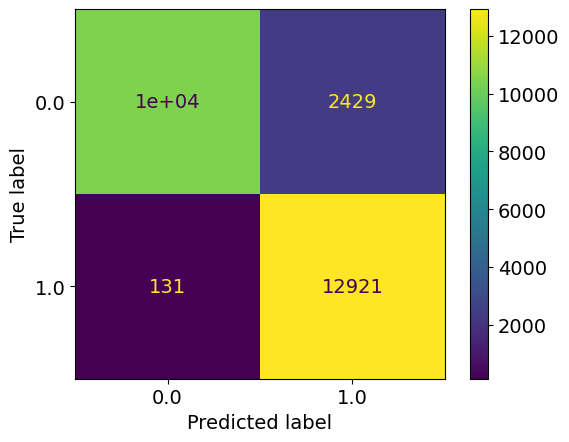

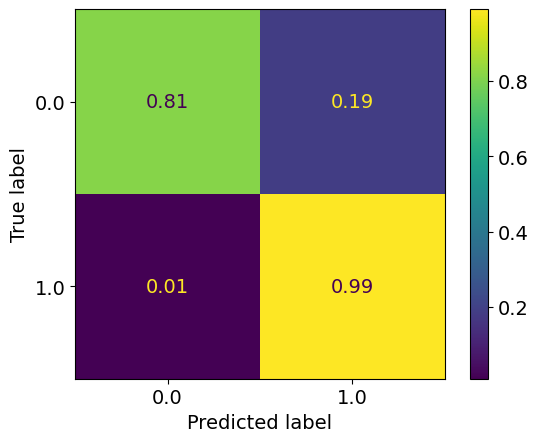

epoch: 360
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10537445088686971
train acc: 0.9568486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.17330109649761158
test acc: 0.9430951
epoch: 361
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10514280372272337
train acc: 0.95676184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.13581606508655983
test acc: 0.9516154
epoch: 362
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10522377099088162
train acc: 0.95723414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.15275655551390213
test acc: 0.9474131
epoch: 363
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10512565881702941
train acc: 0.95654017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.17485150017521597
test acc: 0.9445987
epoch: 364
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.10464105182300414
train acc: 0.95602936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.87it/s]


test loss: 0.1517410467971455
test acc: 0.9470275
epoch: 365
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10395767432072259
train acc: 0.9571185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.21708355234427887
test acc: 0.9402807
epoch: 366
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10484149927176492
train acc: 0.95636666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.24it/s]


test loss: 0.2100516124205156
test acc: 0.9447529
epoch: 367
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10412931592995031
train acc: 0.9565595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.14435298199003394
test acc: 0.95196235
epoch: 368
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10444767376935551
train acc: 0.95638597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.30it/s]


test loss: 0.19240121797404505
test acc: 0.9430951
epoch: 369
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10460535945058558
train acc: 0.9568775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.1533434187824076
test acc: 0.9498805


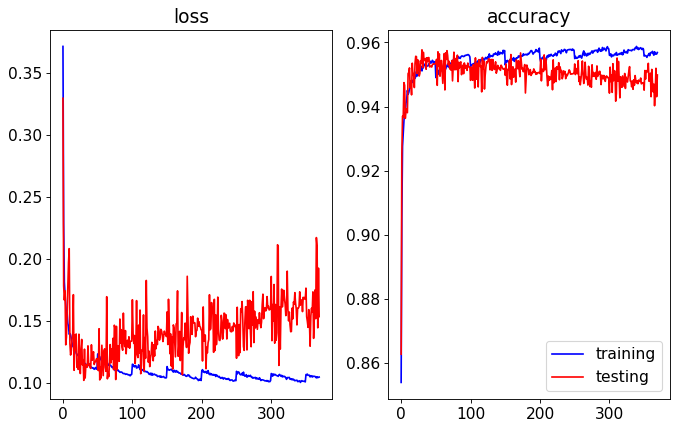

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


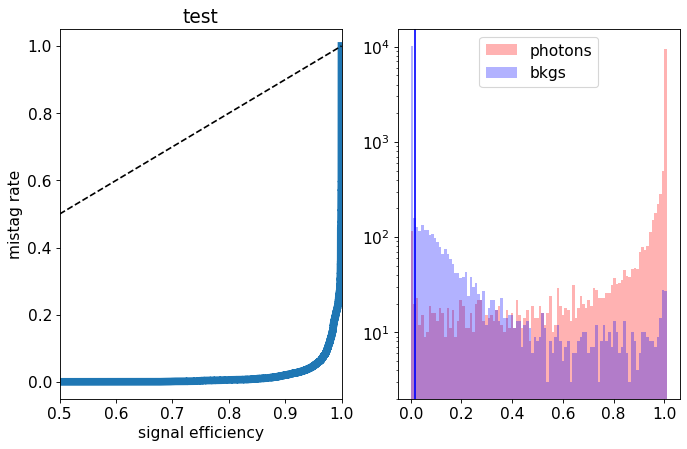

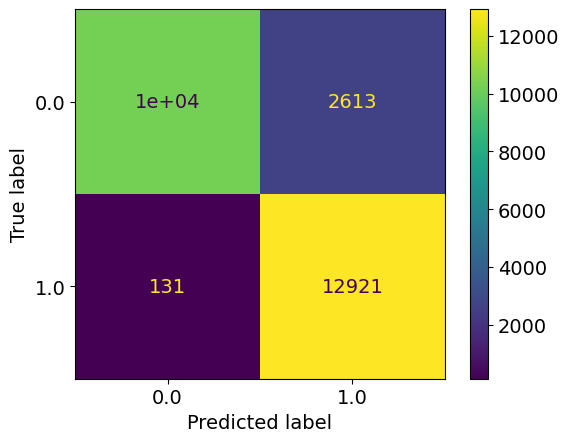

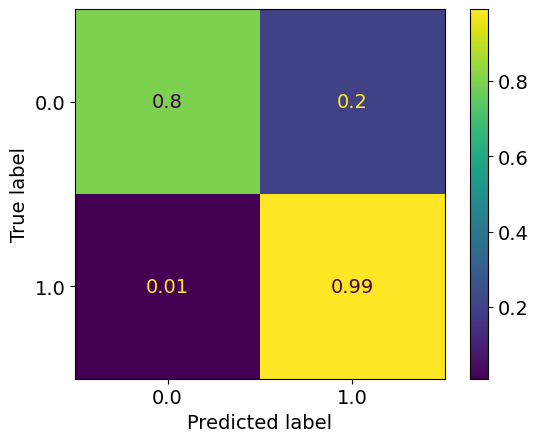

epoch: 370
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10431191708483448
train acc: 0.95668477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.19322227432646535
test acc: 0.94409746
epoch: 371
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10431515795819332
train acc: 0.95696425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.94it/s]


test loss: 0.17330092750489712
test acc: 0.9467577
epoch: 372
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.10303951877390029
train acc: 0.95767754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.1817607180300084
test acc: 0.9455239
epoch: 373
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1037171255215744
train acc: 0.9571185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.17238059673797002
test acc: 0.9486468
epoch: 374
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10295104687613559
train acc: 0.9576968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.18167714774608612
test acc: 0.9467191
epoch: 375
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10234538504498543
train acc: 0.95746547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.16893962228840048
test acc: 0.9490323
epoch: 376
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10281798079868272
train acc: 0.9581112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.17647637579251418
test acc: 0.94841546
epoch: 377
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10369430465160767
train acc: 0.9571185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.16383920694616708
test acc: 0.9496106
epoch: 378
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10256010203519998
train acc: 0.957639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.14277995750308037
test acc: 0.95315754
epoch: 379
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10263453256015832
train acc: 0.95723414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.51it/s]


test loss: 0.17484798654913902
test acc: 0.9483383


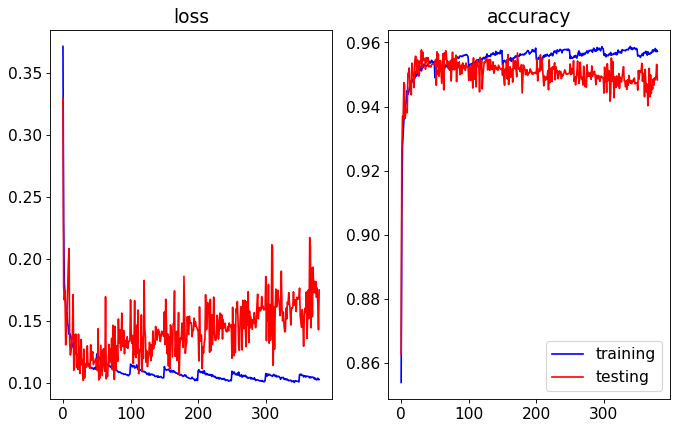

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


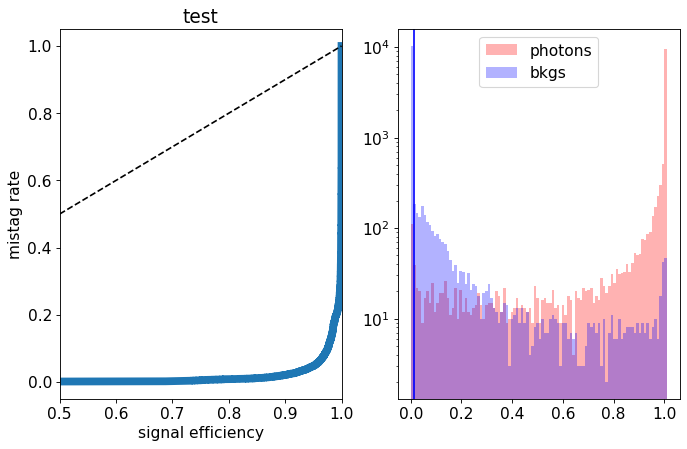

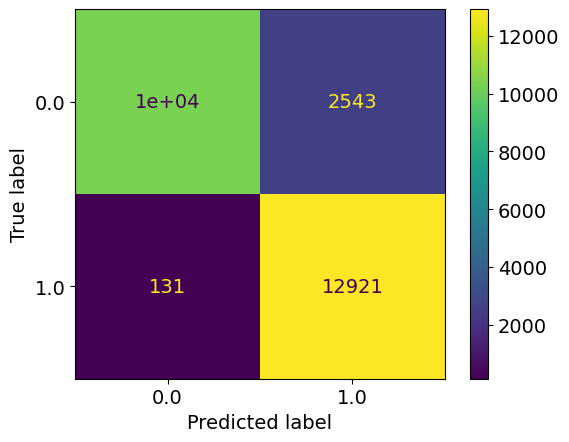

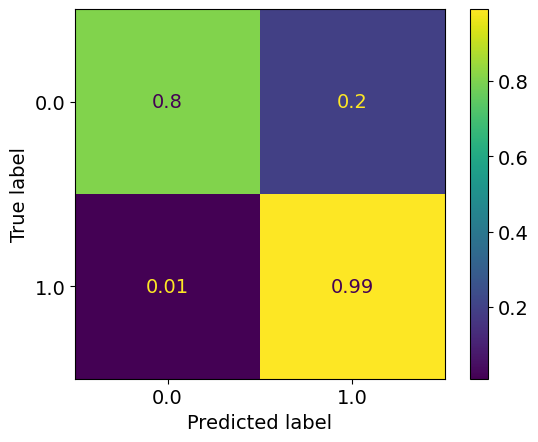

epoch: 380
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.10293915738604661
train acc: 0.9573113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.27it/s]


test loss: 0.18262786587530916
test acc: 0.9457938
epoch: 381
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.10214877542043697
train acc: 0.9578414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.05it/s]


test loss: 0.14983568154275417
test acc: 0.95115274
epoch: 382
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.49it/s]


train loss: 0.10171876929571173
train acc: 0.95767754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.15133064189417797
test acc: 0.95088285
epoch: 383
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10217493182489637
train acc: 0.9579281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.17545660856095227
test acc: 0.9461408
epoch: 384
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10216180166240373
train acc: 0.95753294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.76it/s]


test loss: 0.1770136286927895
test acc: 0.94598657
epoch: 385
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10132509056543339
train acc: 0.9581209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.1661805444481698
test acc: 0.94749016
epoch: 386
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10123033584714625
train acc: 0.95759076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.17922682264311748
test acc: 0.9462179
epoch: 387
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10171606822337718
train acc: 0.95767754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.17815367504954338
test acc: 0.94571674
epoch: 388
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10118003758047357
train acc: 0.9579667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.19it/s]


test loss: 0.17652894573455508
test acc: 0.9464492
epoch: 389
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.10126531882093132
train acc: 0.9585064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.18087530034509572
test acc: 0.9460637


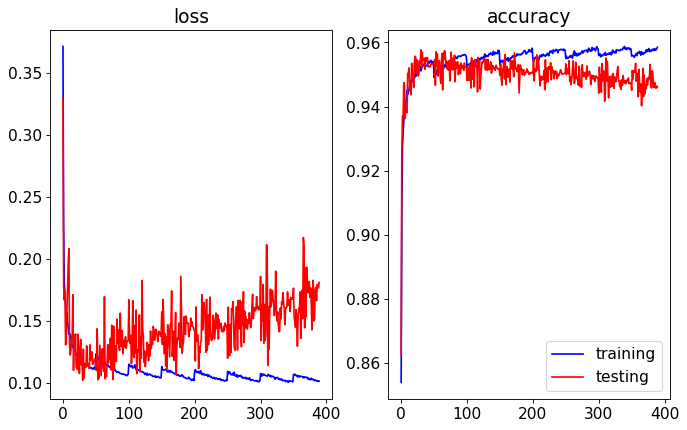

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


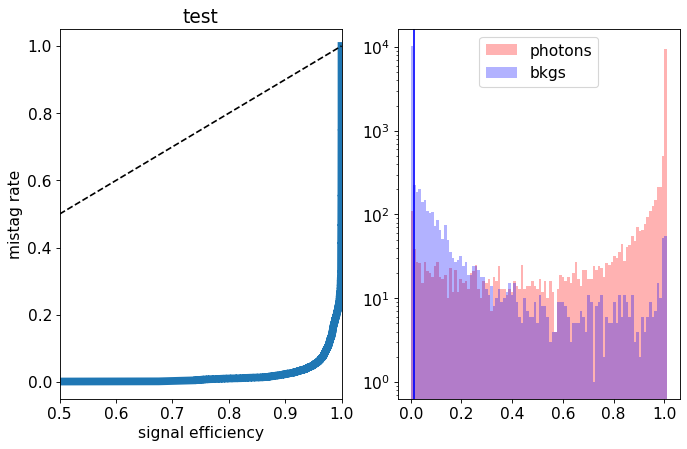

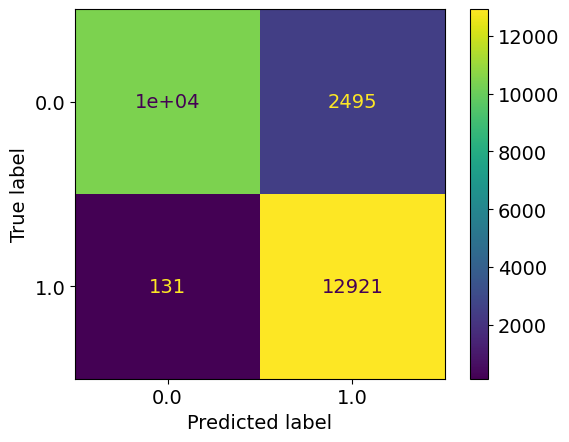

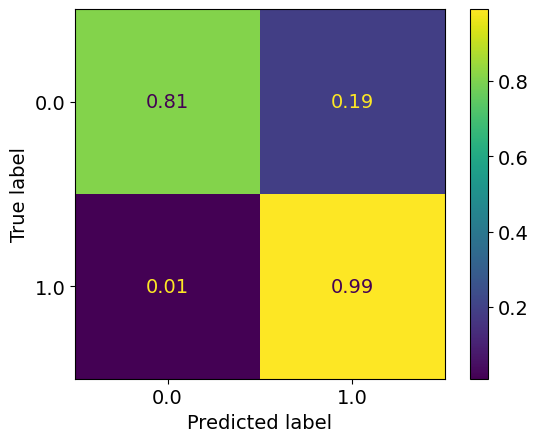

epoch: 390
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10136243317685376
train acc: 0.9578221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.21it/s]


test loss: 0.17051745070652527
test acc: 0.9474131
epoch: 391
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10084035256177704
train acc: 0.95846784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.17819429392164404
test acc: 0.9470275
epoch: 392
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10120599940849867
train acc: 0.9586317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.17542200349271297
test acc: 0.9469119
epoch: 393
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10082974935198105
train acc: 0.9584775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.17624009265141052
test acc: 0.9463721
epoch: 394
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.10025124712658755
train acc: 0.9588341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.18575402061370286
test acc: 0.94610226
epoch: 395
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10105647400796758
train acc: 0.95842934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.18213883059268648
test acc: 0.94617933
epoch: 396
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10017967633257023
train acc: 0.9584775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.17666931958361107
test acc: 0.94722027
epoch: 397
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10082756323104648
train acc: 0.95873773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.1781940201128071
test acc: 0.94668055
epoch: 398
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10067209700456245
train acc: 0.9579378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.18358680318025025
test acc: 0.9467962
epoch: 399
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10084455154534709
train acc: 0.95803416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]


test loss: 0.1812162697315216
test acc: 0.94695044


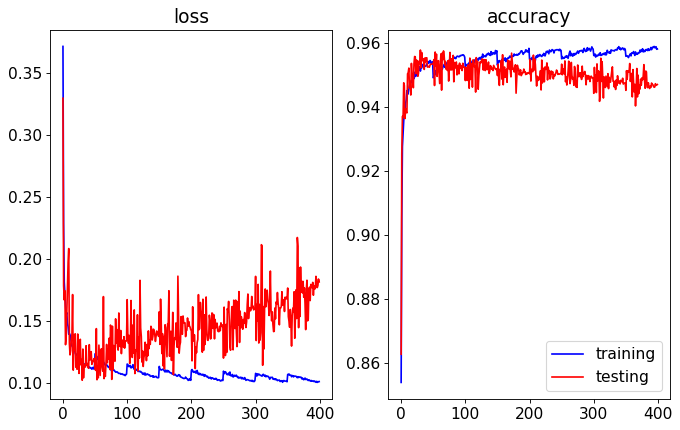

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


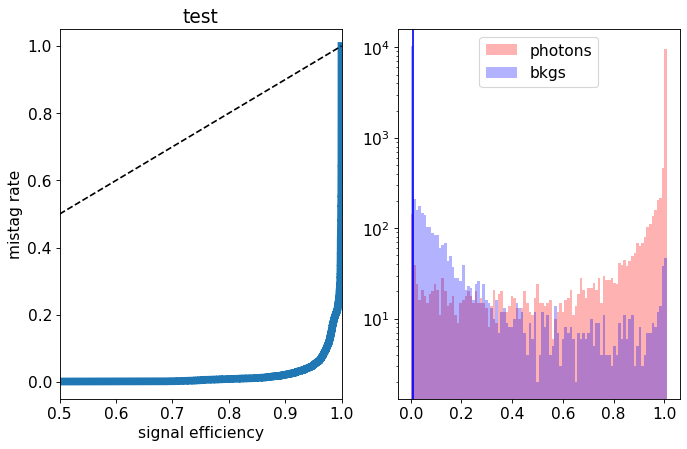

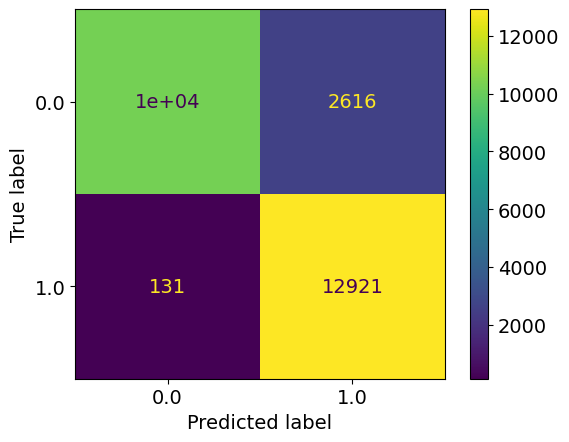

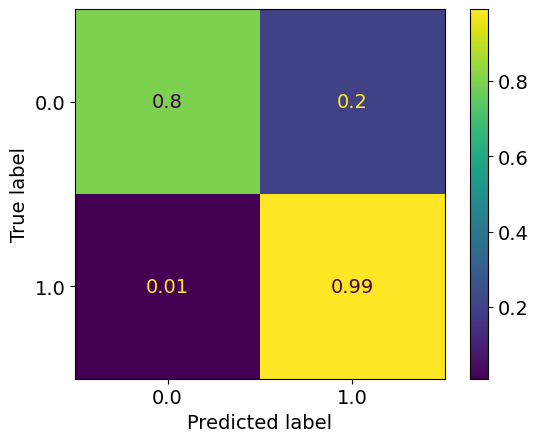

epoch: 400
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10561306977030858
train acc: 0.95618355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.21239669316194273
test acc: 0.94328785
epoch: 401
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10443100841403696
train acc: 0.95669436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.42it/s]


test loss: 0.1566687820648605
test acc: 0.9511142
epoch: 402
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10693097579685938
train acc: 0.9556245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.15455238571898502
test acc: 0.95022744
epoch: 403
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10503150509788811
train acc: 0.95668477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.61it/s]


test loss: 0.18586654791777785
test acc: 0.9422855
epoch: 404
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10476174644824397
train acc: 0.95683897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.16314297017048707
test acc: 0.94467574
epoch: 405
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10442292841011389
train acc: 0.95665586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.16591041687537322
test acc: 0.9462179
epoch: 406
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10542317634889845
train acc: 0.9560197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.1896444863893769
test acc: 0.94695044
epoch: 407
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.1049626491576261
train acc: 0.9565884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.1543050997636535
test acc: 0.94949496
epoch: 408
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1044526361144347
train acc: 0.9573402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.15130091306160798
test acc: 0.94964916
epoch: 409
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.1048564676604519
train acc: 0.95645344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.15153217705135996
test acc: 0.9482227


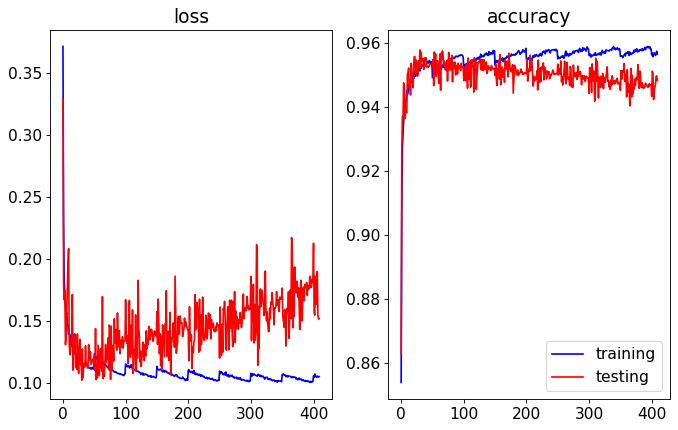

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


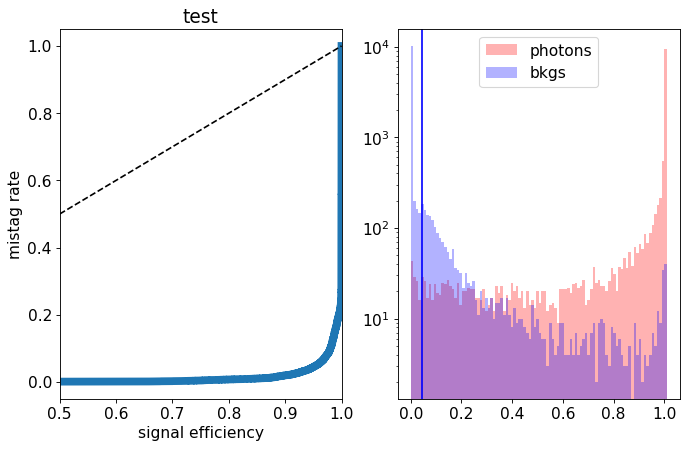

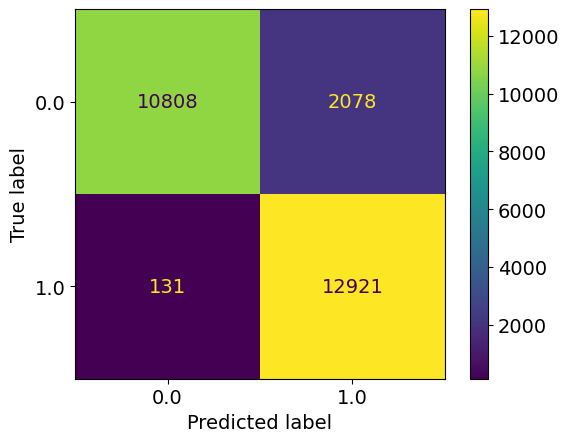

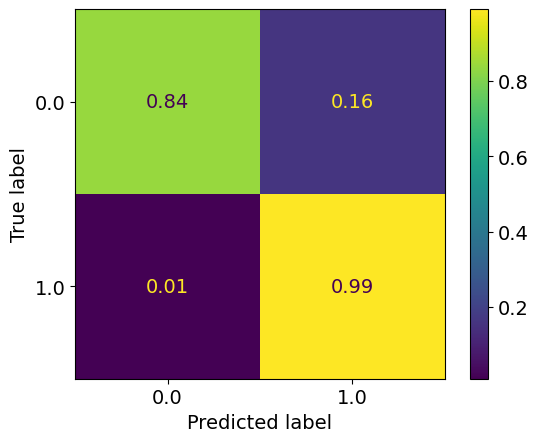

epoch: 410
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1039221888849501
train acc: 0.95676184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.15323165346953002
test acc: 0.94872385
epoch: 411
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10394068695389466
train acc: 0.9566751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.1507051307708025
test acc: 0.94856966
epoch: 412
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10425688528773412
train acc: 0.9570992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.15683251060545444
test acc: 0.94856966
epoch: 413
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10495133736746849
train acc: 0.9564631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.20it/s]


test loss: 0.18893895704637875
test acc: 0.94602513
epoch: 414
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.43it/s]


train loss: 0.10351411735563609
train acc: 0.95678115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.64it/s]


test loss: 0.1539509885690429
test acc: 0.94883955
epoch: 415
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10423366204334822
train acc: 0.95672333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.79it/s]


test loss: 0.20388338460840963
test acc: 0.94378906
epoch: 416
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.1036047529364597
train acc: 0.9570414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.51it/s]


test loss: 0.1799345272169872
test acc: 0.9463336
epoch: 417
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10244777553171092
train acc: 0.9565016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.20817615853791888
test acc: 0.9440589
epoch: 418
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10330831061381136
train acc: 0.9565305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.32it/s]


test loss: 0.1848098293624141
test acc: 0.9472974
epoch: 419
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.1038223475303953
train acc: 0.95710886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.16735688478431918
test acc: 0.95072865


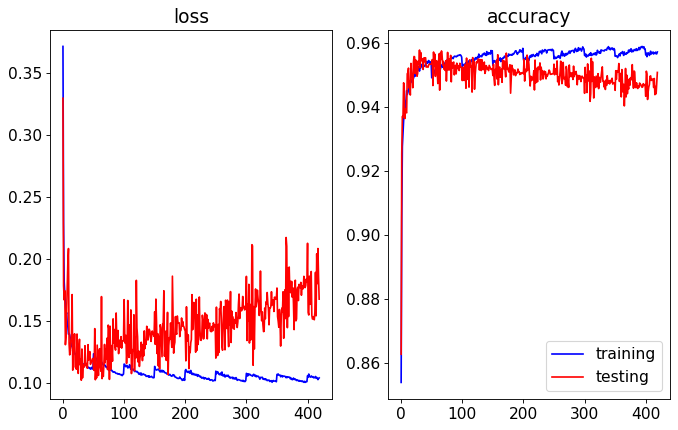

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.72it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


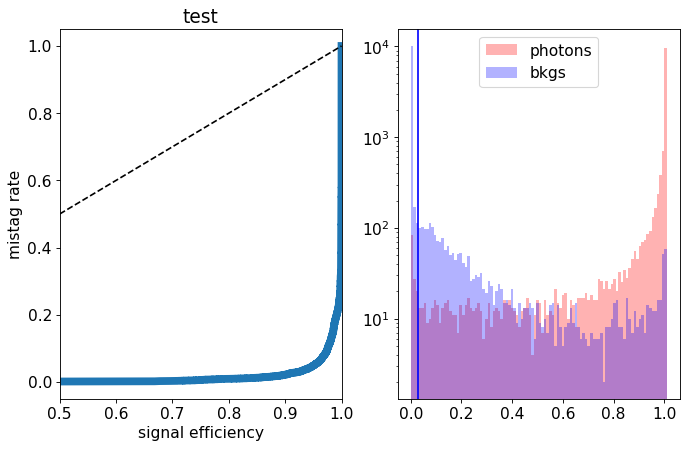

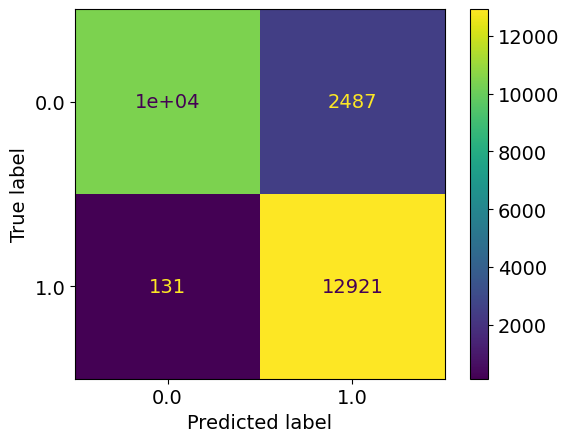

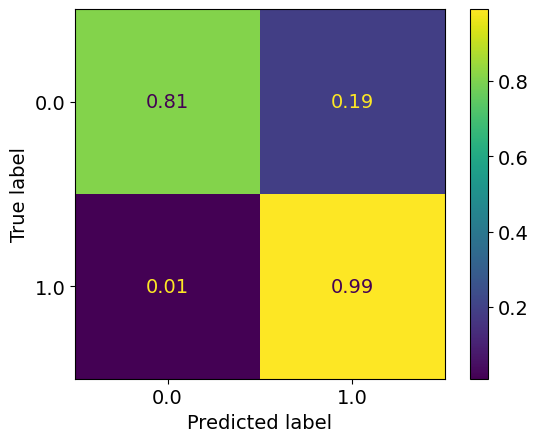

epoch: 420
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10345546061420716
train acc: 0.9578124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.2666677910495888
test acc: 0.9375048
epoch: 421
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.51it/s]


train loss: 0.10334856420583119
train acc: 0.95737875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.21it/s]


test loss: 0.1693801058625633
test acc: 0.94425166
epoch: 422
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.20it/s]


train loss: 0.10315291824712919
train acc: 0.9568293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.29it/s]


test loss: 0.17782431857829745
test acc: 0.9479528
epoch: 423
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.10247828979368155
train acc: 0.95765823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.23766562139446085
test acc: 0.9424397
epoch: 424
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10320639425102686
train acc: 0.95750403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.2034861504692923
test acc: 0.94575524
epoch: 425
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10245492968256074
train acc: 0.95774496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.06it/s]


test loss: 0.18474153276871552
test acc: 0.94749016
epoch: 426
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.10117724636903389
train acc: 0.95858353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.16823831708593803
test acc: 0.94818413
epoch: 427
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10127787559018658
train acc: 0.9581787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.178654601120136
test acc: 0.9464492
epoch: 428
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10176486366918322
train acc: 0.9575522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]


test loss: 0.1829192259094932
test acc: 0.94733596
epoch: 429
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10176740324049327
train acc: 0.95798594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.1822018293155865
test acc: 0.9475287


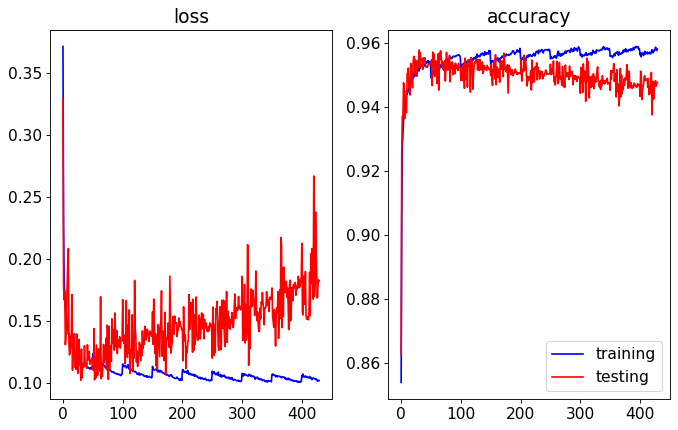

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.98it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


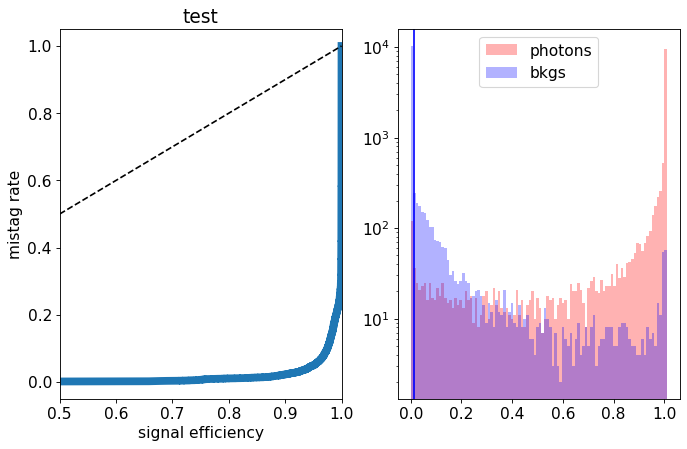

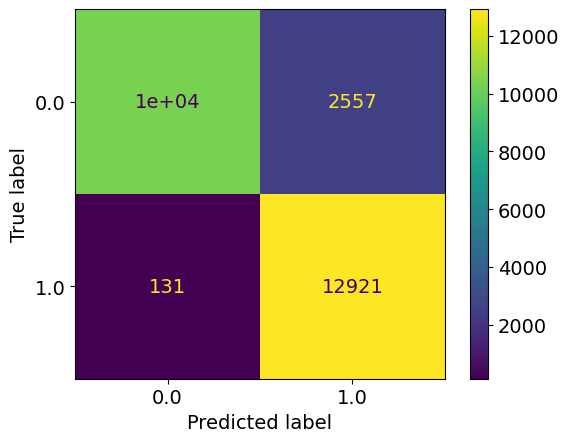

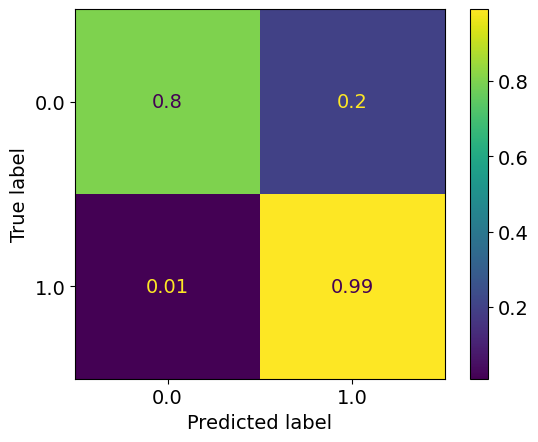

epoch: 430
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.42it/s]


train loss: 0.10157107359412089
train acc: 0.9585546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.22it/s]


test loss: 0.19549104198813438
test acc: 0.94652635
epoch: 431
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.1020296794184715
train acc: 0.9578703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.06it/s]


test loss: 0.20157307623462242
test acc: 0.944136
epoch: 432
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.10159138758058493
train acc: 0.9573691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.18it/s]


test loss: 0.18208029561422087
test acc: 0.94910944
epoch: 433
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.24it/s]


train loss: 0.10113988136280479
train acc: 0.95774496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.37it/s]


test loss: 0.19655279476534238
test acc: 0.94402033
epoch: 434
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.46it/s]


train loss: 0.10122162986525221
train acc: 0.9583522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.30it/s]


test loss: 0.18809287453239615
test acc: 0.9470275
epoch: 435
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.25it/s]


train loss: 0.10044966793129209
train acc: 0.957851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.66it/s]


test loss: 0.1549903152679855
test acc: 0.9497263
epoch: 436
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.09986993588636377
train acc: 0.9587185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.27it/s]


test loss: 0.1936659034002911
test acc: 0.9455239
epoch: 437
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.22it/s]


train loss: 0.09972838650462944
train acc: 0.95803416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.26it/s]


test loss: 0.18777646666223352
test acc: 0.9472974
epoch: 438
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10079906170251053
train acc: 0.9582076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.32it/s]


test loss: 0.1773135909302668
test acc: 0.94706607
epoch: 439
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.0991843616256135
train acc: 0.95836186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.14it/s]


test loss: 0.20104314928705042
test acc: 0.9454854


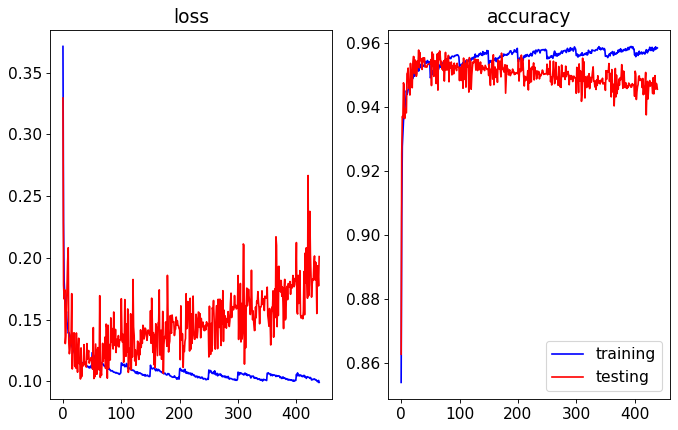

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


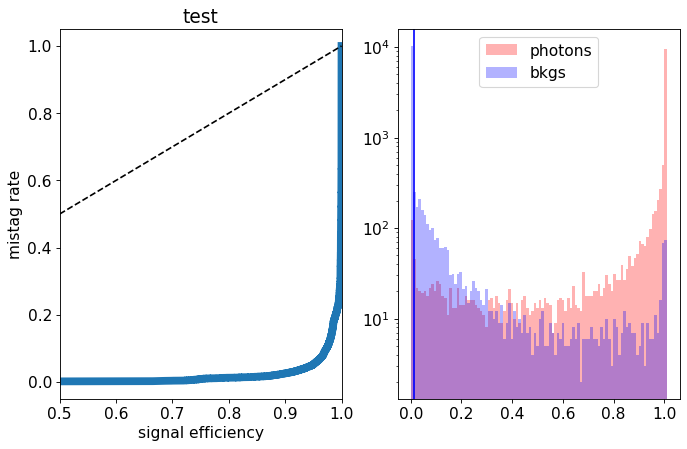

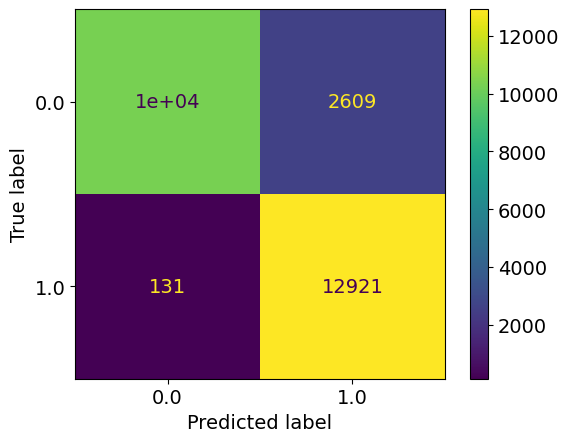

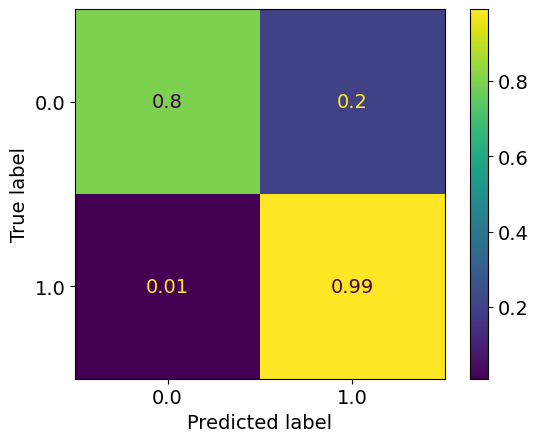

epoch: 440
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.09881034191977771
train acc: 0.95894015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.86it/s]


test loss: 0.17957725121893667
test acc: 0.948107
epoch: 441
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10021297749928657
train acc: 0.9587474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.19157701307399708
test acc: 0.94533116
epoch: 442
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.09961106554965753
train acc: 0.9590751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.18790785053914244
test acc: 0.9464492
epoch: 443
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10068005151142274
train acc: 0.9578221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.1751097362827171
test acc: 0.94814557
epoch: 444
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.36it/s]


train loss: 0.0995372093223423
train acc: 0.95867026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.23it/s]


test loss: 0.18814907392317598
test acc: 0.9455239
epoch: 445
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.50it/s]


train loss: 0.10052449062380488
train acc: 0.9583522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.00it/s]


test loss: 0.1824041772633791
test acc: 0.94668055
epoch: 446
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.29it/s]


train loss: 0.09935577183617333
train acc: 0.9594992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.99it/s]


test loss: 0.18656849895011296
test acc: 0.9467577
epoch: 447
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.09979870258642069
train acc: 0.95888233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.18571228567849507
test acc: 0.9464492
epoch: 448
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.09922916485222778
train acc: 0.95864135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.11it/s]


test loss: 0.1857106008312919
test acc: 0.9463721
epoch: 449
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.09927058870220459
train acc: 0.9589016


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.18672221424904736
test acc: 0.94641066


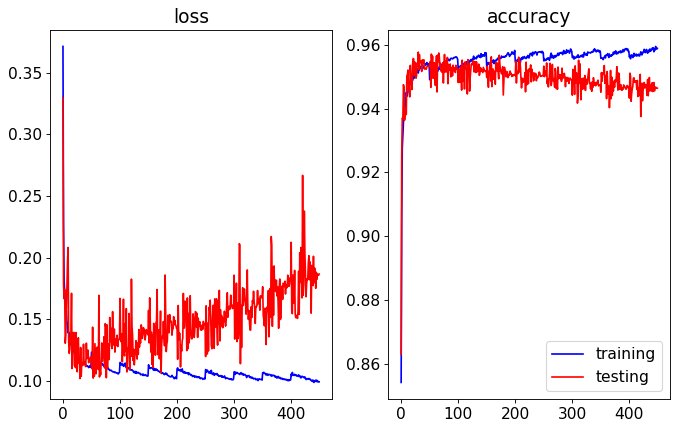

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


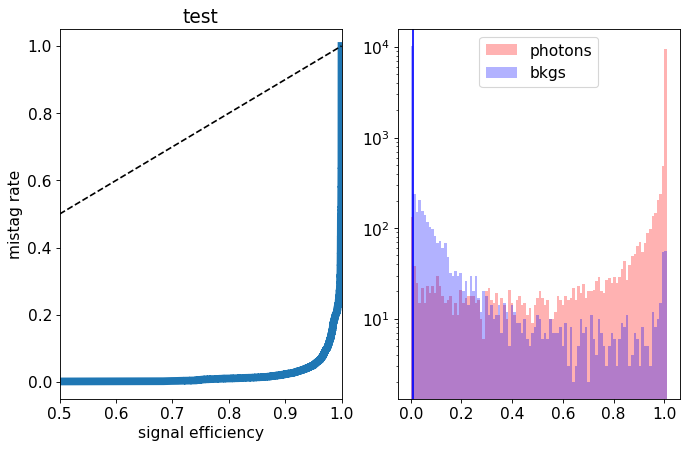

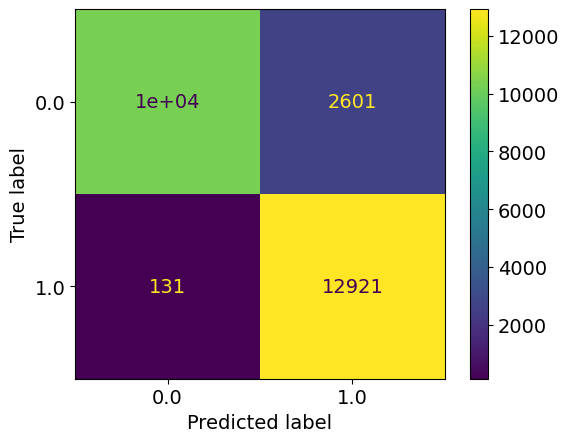

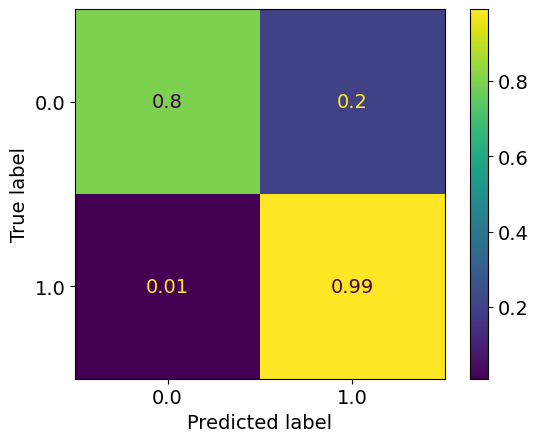

epoch: 450
Learning rate: 3.2976725905520253e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10606617988706324
train acc: 0.95590407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.1763300369070335
test acc: 0.9474516
epoch: 451
Learning rate: 0.0009990247337435532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10502428462395089
train acc: 0.9564052


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.34it/s]


test loss: 0.2327955707230351
test acc: 0.94313365
epoch: 452
Learning rate: 0.000996080077822461


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10397877970527362
train acc: 0.95726305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.1668204412880269
test acc: 0.9498805
epoch: 453
Learning rate: 0.0009911776204716335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.1045549987368501
train acc: 0.9560872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.22it/s]


test loss: 0.24088928594507955
test acc: 0.93607837
epoch: 454
Learning rate: 0.000984336709450514


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.56it/s]


train loss: 0.10469734276822537
train acc: 0.95630884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.20669331621717324
test acc: 0.944483
epoch: 455
Learning rate: 0.0009755843427095879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10358925426454213
train acc: 0.9575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.14928371052850375
test acc: 0.95153826
epoch: 456
Learning rate: 0.000964955061841806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.58it/s]


train loss: 0.10370204869033284
train acc: 0.9573402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]


test loss: 0.18680578148500485
test acc: 0.9476444
epoch: 457
Learning rate: 0.0009524908157626966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.34it/s]


train loss: 0.10422848970387023
train acc: 0.95695466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.15128964609043163
test acc: 0.95223224
epoch: 458
Learning rate: 0.0009382407951571619


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10376807836266612
train acc: 0.9569257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.89it/s]


test loss: 0.1756174522028728
test acc: 0.94617933
epoch: 459
Learning rate: 0.0009222612383463165


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.10334930116730619
train acc: 0.95728236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.02it/s]


test loss: 0.20380074615505608
test acc: 0.9454083


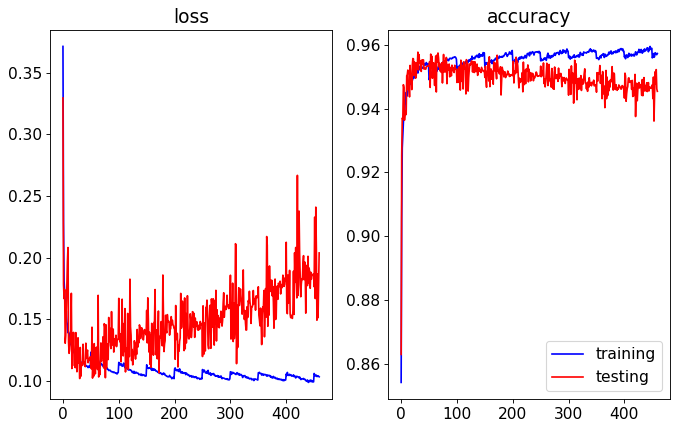

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


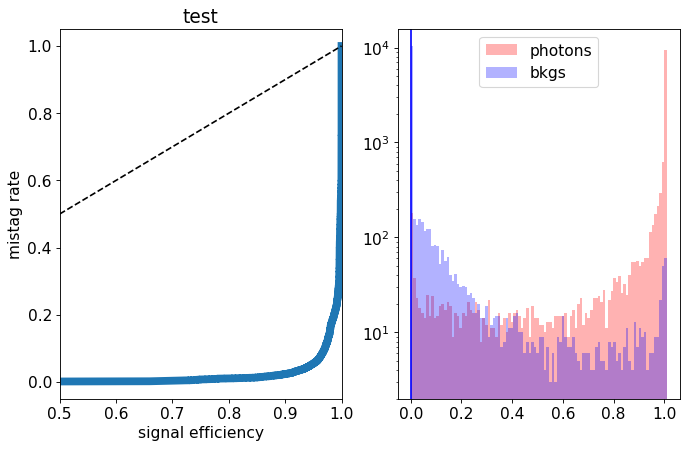

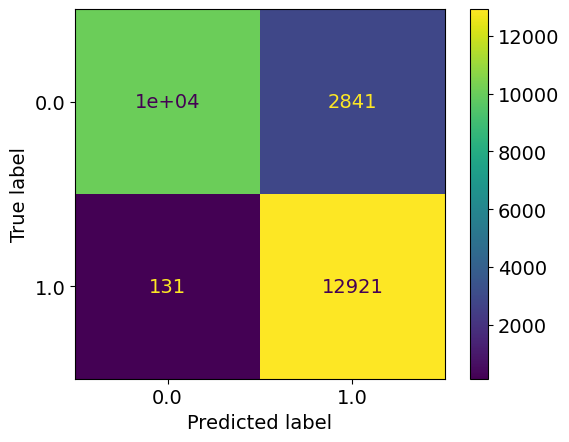

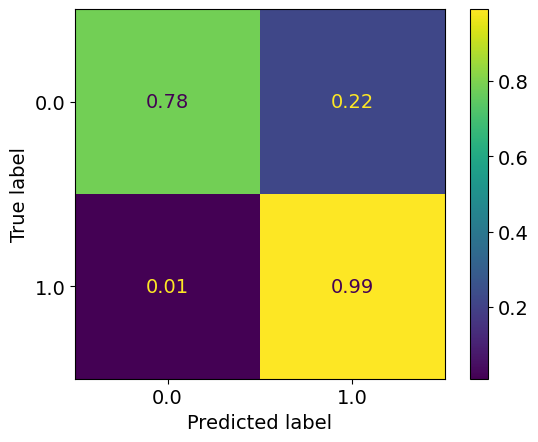

epoch: 460
Learning rate: 0.000904615209340528


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10277477966223149
train acc: 0.95693535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.1973488669503819
test acc: 0.9430565
epoch: 461
Learning rate: 0.0008853723489545782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.10386684007210538
train acc: 0.95665586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]


test loss: 0.1891745085066015
test acc: 0.9444444
epoch: 462
Learning rate: 0.0008646085999671838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10383894464614764
train acc: 0.9575522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.97it/s]


test loss: 0.14844503389163452
test acc: 0.9521551
epoch: 463
Learning rate: 0.0008424059074095434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10274808927078467
train acc: 0.9568775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.20it/s]


test loss: 0.1811173785139214
test acc: 0.9484926
epoch: 464
Learning rate: 0.0008188518951657369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10327762218913591
train acc: 0.957186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.88it/s]


test loss: 0.19920598901808262
test acc: 0.9474516
epoch: 465
Learning rate: 0.0007940395201612858


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10303842291408191
train acc: 0.9577257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.93it/s]


test loss: 0.1773466251113198
test acc: 0.950266
epoch: 466
Learning rate: 0.0007680667055046368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.10270851605028086
train acc: 0.95767754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.08it/s]


test loss: 0.25071325356310065
test acc: 0.9434035
epoch: 467
Learning rate: 0.0007410359540293894


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.59it/s]


train loss: 0.10278130395908576
train acc: 0.957398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.18571103939955885
test acc: 0.9457938
epoch: 468
Learning rate: 0.0007130539437624407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.10162496114569593
train acc: 0.9584197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.96it/s]


test loss: 0.2262047745964744
test acc: 0.94425166
epoch: 469
Learning rate: 0.0006842311069145499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.10246487627225805
train acc: 0.9571763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.18501495451412417
test acc: 0.94976485


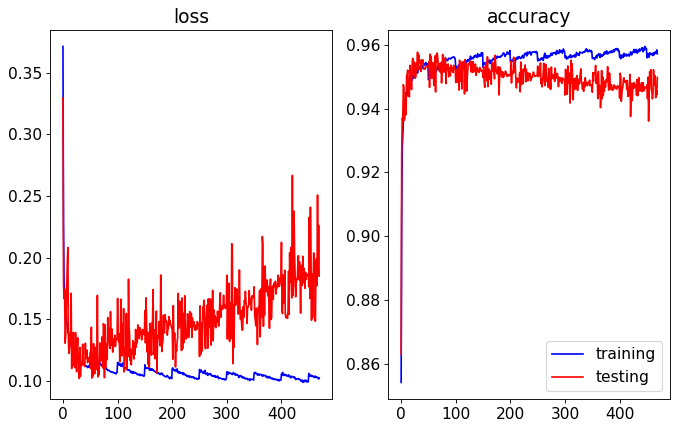

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.24it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


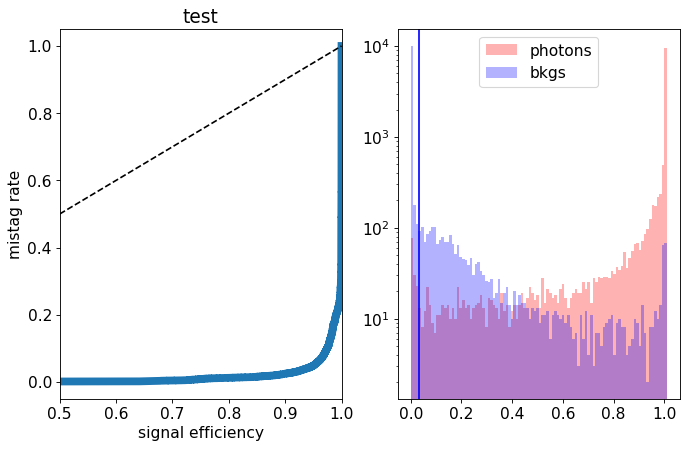

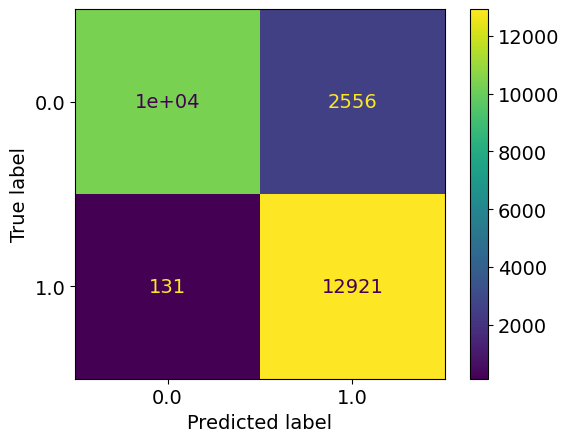

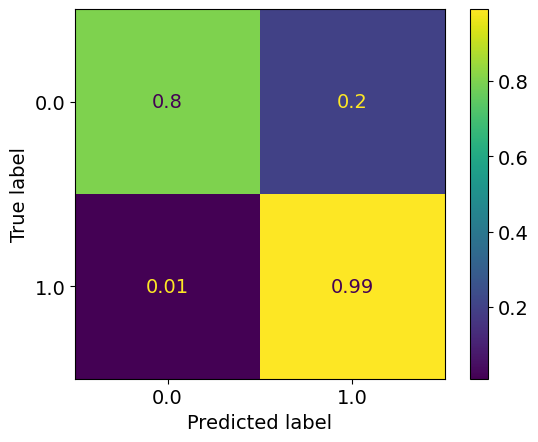

epoch: 470
Learning rate: 0.0006546811940548541


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.10130008030144465
train acc: 0.9575811


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.1741996001113545
test acc: 0.94937927
epoch: 471
Learning rate: 0.0006245208251893393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.52it/s]


train loss: 0.10208827433730826
train acc: 0.9572438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.58it/s]


test loss: 0.1430469687012109
test acc: 0.951731
epoch: 472
Learning rate: 0.000593869029514956


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.10159093806940007
train acc: 0.95773536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.15it/s]


test loss: 0.2307393178343773
test acc: 0.9412445
epoch: 473
Learning rate: 0.0005628467756657574


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.1021015705228541
train acc: 0.95732087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.16399139978668906
test acc: 0.95030457
epoch: 474
Learning rate: 0.0005315764943049667


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.28it/s]


train loss: 0.10217017986181844
train acc: 0.9581691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.33it/s]


test loss: 0.19011526385491545
test acc: 0.94344205
epoch: 475
Learning rate: 0.0005001815949470824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.47it/s]


train loss: 0.10117590375718354
train acc: 0.958198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.30it/s]


test loss: 0.22090837748890574
test acc: 0.94301796
epoch: 476
Learning rate: 0.000468785978916905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.26it/s]


train loss: 0.10154393328235328
train acc: 0.9582269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.19158697907220235
test acc: 0.94598657
epoch: 477
Learning rate: 0.00043751355036761254


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:30<00:00,  5.60it/s]


train loss: 0.10195773616002474
train acc: 0.9580823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.18it/s]


test loss: 0.20454671962017362
test acc: 0.9452155
epoch: 478
Learning rate: 0.0004064877272876758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.10101438649644741
train acc: 0.9583522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.51it/s]


test loss: 0.20606472495604644
test acc: 0.9442902
epoch: 479
Learning rate: 0.00037583095442644094


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.09999972870411901
train acc: 0.958651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.83it/s]


test loss: 0.21358263323252852
test acc: 0.9458324


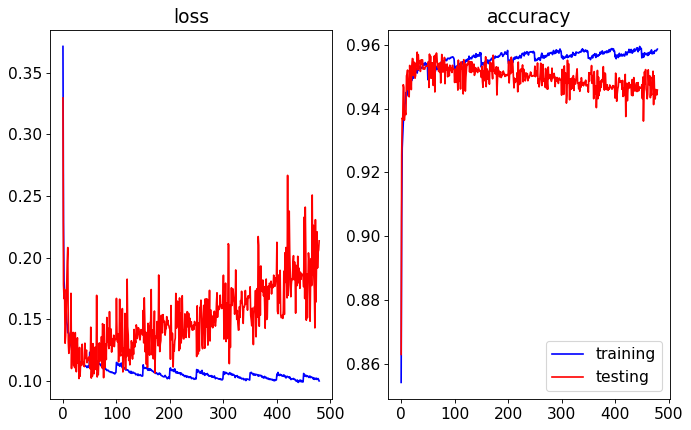

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


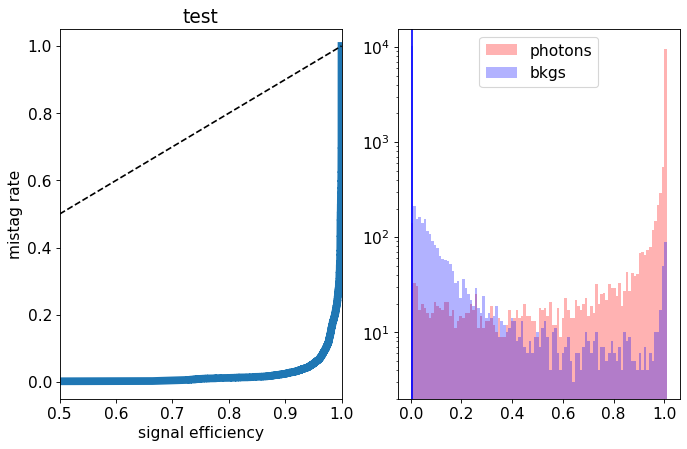

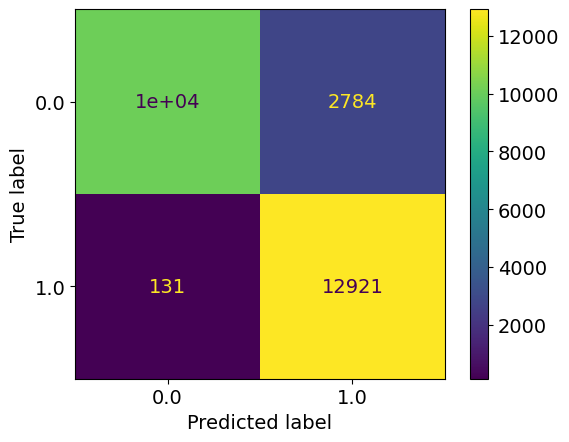

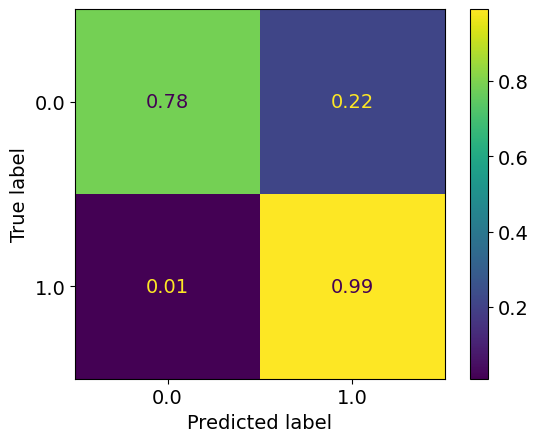

epoch: 480
Learning rate: 0.0003456642200606441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.10010407059695679
train acc: 0.95875704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.11it/s]


test loss: 0.1850137056952173
test acc: 0.94718176
epoch: 481
Learning rate: 0.00031610657850895686


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.10036650648868153
train acc: 0.9586221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.09it/s]


test loss: 0.20509060438383708
test acc: 0.9467962
epoch: 482
Learning rate: 0.0002872746802789821


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.42it/s]


train loss: 0.09942997376181487
train acc: 0.9590365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.19it/s]


test loss: 0.2331384467807683
test acc: 0.9440589
epoch: 483
Learning rate: 0.0002592823117009918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.23it/s]


train loss: 0.10012226517317611
train acc: 0.958892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.30it/s]


test loss: 0.18907616270536726
test acc: 0.94749016
epoch: 484
Learning rate: 0.0002322399458652668


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.09962751746522208
train acc: 0.9594606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.23it/s]


test loss: 0.18177939121696082
test acc: 0.94922507
epoch: 485
Learning rate: 0.00020625430663527884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.27it/s]


train loss: 0.09944558987727745
train acc: 0.95928717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.03it/s]


test loss: 0.21062562767077575
test acc: 0.9455625
epoch: 486
Learning rate: 0.00018142794745735962


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.57it/s]


train loss: 0.09877014194609803
train acc: 0.9589498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.13it/s]


test loss: 0.21906148608435283
test acc: 0.94479144
epoch: 487
Learning rate: 0.00015785884662909932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.35it/s]


train loss: 0.10052460117663951
train acc: 0.9580245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.98it/s]


test loss: 0.21669453551823442
test acc: 0.9456782
epoch: 488
Learning rate: 0.00013564002062376945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.54it/s]


train loss: 0.09978837149508427
train acc: 0.9592582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


test loss: 0.21228849024257876
test acc: 0.9454083
epoch: 489
Learning rate: 0.00011485915699679689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.33it/s]


train loss: 0.0992148339403847
train acc: 0.95894015


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.20564339140599425
test acc: 0.94641066


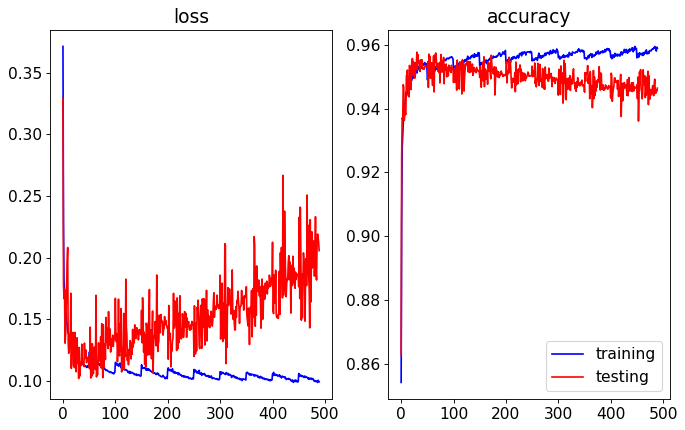

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


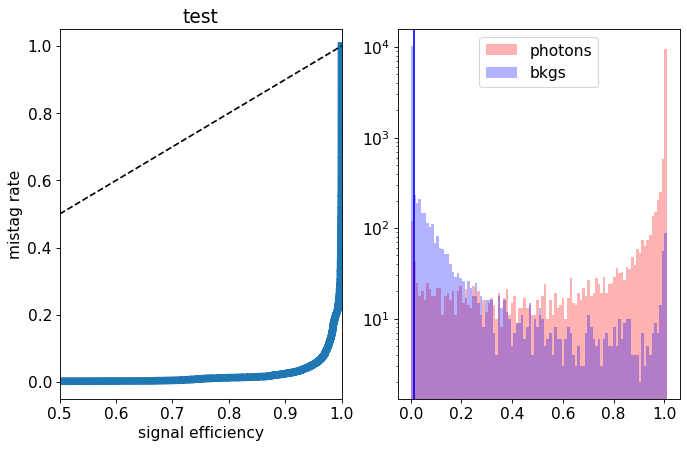

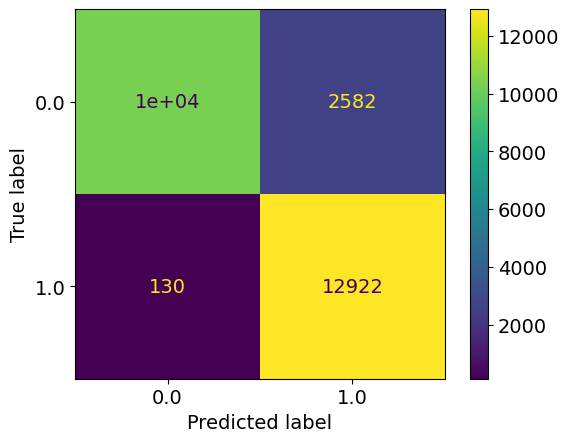

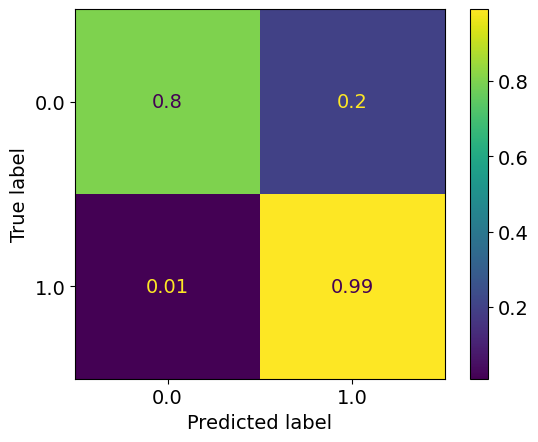

epoch: 490
Learning rate: 9.55982683230438e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.21it/s]


train loss: 0.09933975373389405
train acc: 0.9590269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.13it/s]


test loss: 0.22919106974520467
test acc: 0.9437505
epoch: 491
Learning rate: 7.793336853064254e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.43it/s]


train loss: 0.09900732857385122
train acc: 0.959104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.61it/s]


test loss: 0.22223331406712532
test acc: 0.9451384
epoch: 492
Learning rate: 6.19341729087487e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:33<00:00,  5.19it/s]


train loss: 0.09824681428471052
train acc: 0.9593353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.14it/s]


test loss: 0.23349109308963473
test acc: 0.9448685
epoch: 493
Learning rate: 4.766382297314442e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.44it/s]


train loss: 0.09912490097515156
train acc: 0.9591233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:03<00:00, 14.24it/s]


test loss: 0.21343033235858788
test acc: 0.9456782
epoch: 494
Learning rate: 3.517863727552312e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.32it/s]


train loss: 0.09910645206711885
train acc: 0.9587763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.12it/s]


test loss: 0.21123003841123797
test acc: 0.9456396
epoch: 495
Learning rate: 2.45278891398944e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.58it/s]


train loss: 0.0993290175764547
train acc: 0.9590173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 14.96it/s]


test loss: 0.21379620801996102
test acc: 0.9454083
epoch: 496
Learning rate: 1.5753612203285472e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.30it/s]


train loss: 0.09875412970092255
train acc: 0.9591618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.01it/s]


test loss: 0.22777700864455916
test acc: 0.94502276
epoch: 497
Learning rate: 8.890434528179504e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.0984182924979684
train acc: 0.9598847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.2191289778460156
test acc: 0.9450613
epoch: 498
Learning rate: 3.9654419413724384e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:32<00:00,  5.31it/s]


train loss: 0.09866677864180134
train acc: 0.95939314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.08it/s]


test loss: 0.22171511501073837
test acc: 0.94490707
epoch: 499
Learning rate: 9.98071138589296e-07


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173/173 [00:31<00:00,  5.55it/s]


train loss: 0.09797754005200601
train acc: 0.95989436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.04it/s]


test loss: 0.22161088985475627
test acc: 0.9449842


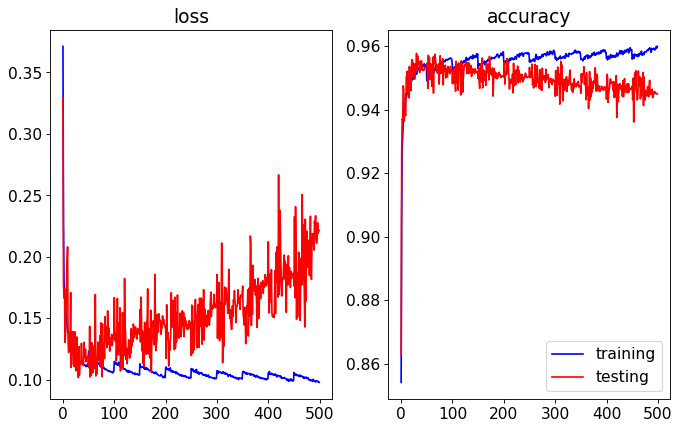

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


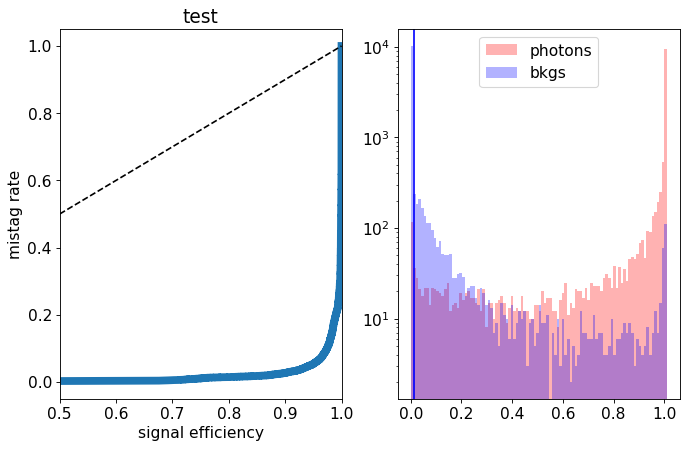

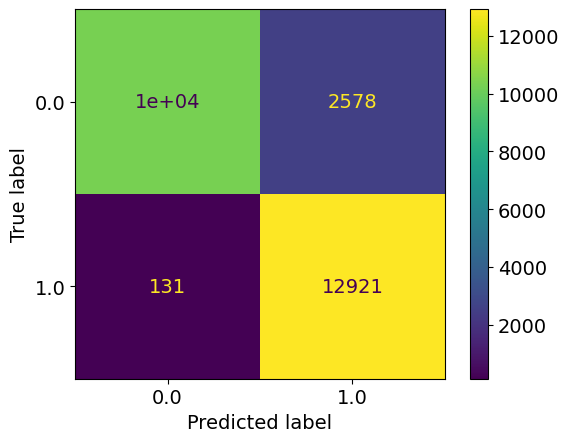

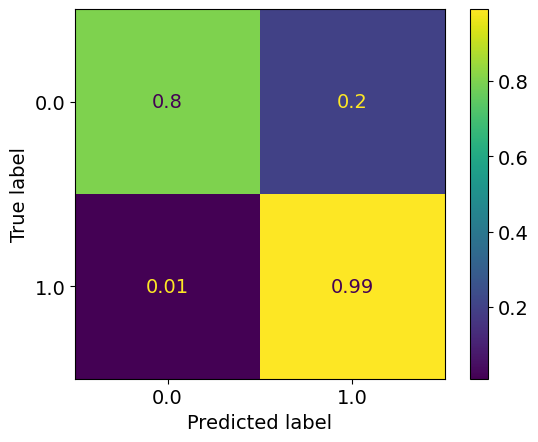

In [15]:
from tqdm import tqdm as tqdm


checkpoint_dir ="/home/llr/cms/cappati/HGC_models/PID_phopi/trainings/outdir_models_30-70_wLowptpho"
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [16]:
#print(epoch_size)

In [17]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 15.10it/s]


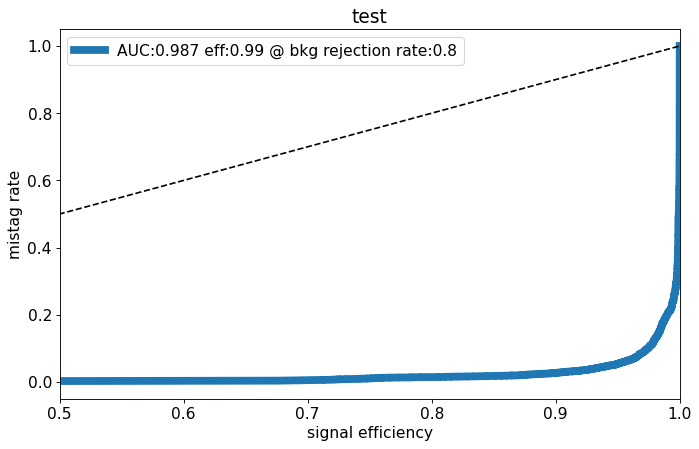

In [18]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

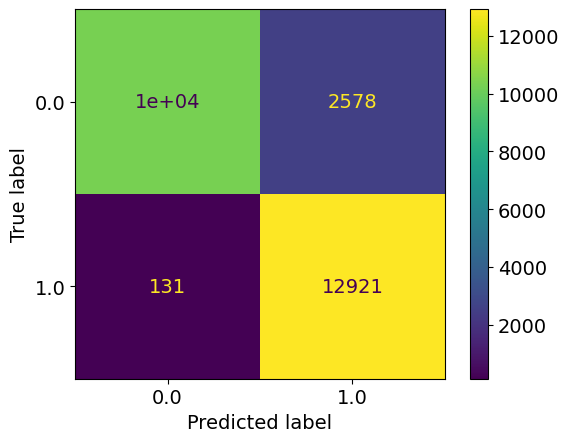

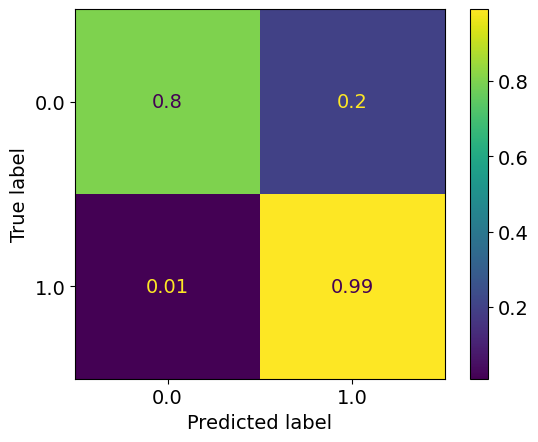

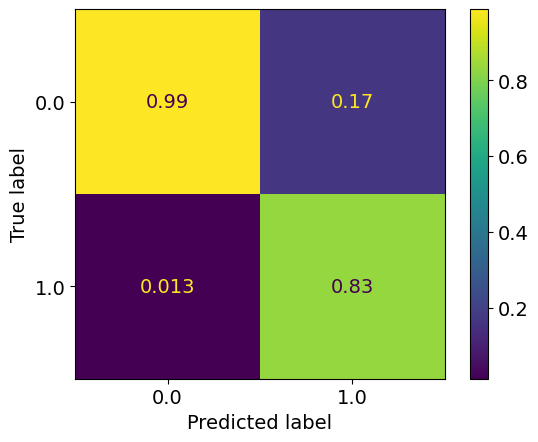

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()